## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


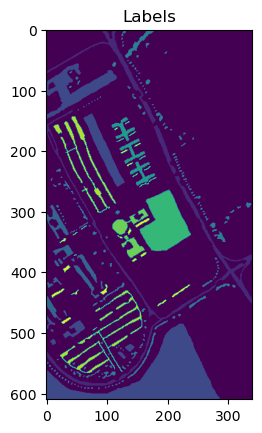

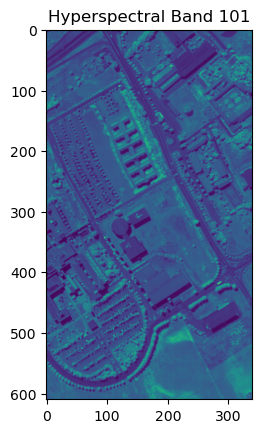

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 40 train


All datasets saved to the 'indices' folder.
(360, 5, 5, 103)
(45, 5, 5, 103)
(42371, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1183, PSNR: 7.2345


	 Training Batch [200/535], Loss: 0.0707, PSNR: 7.8508


	 Training Batch [400/535], Loss: 0.0317, PSNR: 12.9956


Epoch [1/50] Training Loss: 0.0561, PSNR: 11.1326
	[Val]   Batch [1/134] Loss: 0.0194, PSNR: 15.3077
	[Val]   Batch [10/134] Loss: 0.0172, PSNR: 17.6400
	[Val]   Batch [20/134] Loss: 0.0185, PSNR: 15.4430
	[Val]   Batch [30/134] Loss: 0.0200, PSNR: 14.9222
	[Val]   Batch [40/134] Loss: 0.0181, PSNR: 13.9600
	[Val]   Batch [50/134] Loss: 0.0193, PSNR: 15.1184
	[Val]   Batch [60/134] Loss: 0.0175, PSNR: 15.7761


	[Val]   Batch [70/134] Loss: 0.0167, PSNR: 15.9549
	[Val]   Batch [80/134] Loss: 0.0163, PSNR: 15.9447
	[Val]   Batch [90/134] Loss: 0.0171, PSNR: 15.9562
	[Val]   Batch [100/134] Loss: 0.0193, PSNR: 15.3605
	[Val]   Batch [110/134] Loss: 0.0196, PSNR: 13.8938
	[Val]   Batch [120/134] Loss: 0.0161, PSNR: 15.0230
	[Val]   Batch [130/134] Loss: 0.0177, PSNR: 13.0752
Epoch [1/50] Validation Loss: 0.0185, PSNR: 15.3153

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0177, PSNR: 15.6687


	 Training Batch [200/535], Loss: 0.0128, PSNR: 17.0794


	 Training Batch [400/535], Loss: 0.0088, PSNR: 18.6562


Epoch [2/50] Training Loss: 0.0119, PSNR: 17.3526
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7647
	[Val]   Batch [10/134] Loss: 0.0071, PSNR: 21.5116
	[Val]   Batch [20/134] Loss: 0.0077, PSNR: 19.2573
	[Val]   Batch [30/134] Loss: 0.0087, PSNR: 18.5435
	[Val]   Batch [40/134] Loss: 0.0078, PSNR: 17.6274
	[Val]   Batch [50/134] Loss: 0.0081, PSNR: 18.8804
	[Val]   Batch [60/134] Loss: 0.0071, PSNR: 19.6829


	[Val]   Batch [70/134] Loss: 0.0069, PSNR: 19.7564
	[Val]   Batch [80/134] Loss: 0.0066, PSNR: 19.8663
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8232
	[Val]   Batch [100/134] Loss: 0.0084, PSNR: 18.9741
	[Val]   Batch [110/134] Loss: 0.0079, PSNR: 17.8101
	[Val]   Batch [120/134] Loss: 0.0059, PSNR: 19.3576
	[Val]   Batch [130/134] Loss: 0.0071, PSNR: 17.0207
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0051

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0105, PSNR: 19.3310


	 Training Batch [200/535], Loss: 0.0063, PSNR: 18.8111


	 Training Batch [400/535], Loss: 0.0067, PSNR: 18.6172


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.6028
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2950
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.1391
	[Val]   Batch [20/134] Loss: 0.0052, PSNR: 20.9361
	[Val]   Batch [30/134] Loss: 0.0059, PSNR: 20.2087
	[Val]   Batch [40/134] Loss: 0.0054, PSNR: 19.2264
	[Val]   Batch [50/134] Loss: 0.0055, PSNR: 20.5698
	[Val]   Batch [60/134] Loss: 0.0048, PSNR: 21.3998


	[Val]   Batch [70/134] Loss: 0.0048, PSNR: 21.3719
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.5506
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4663
	[Val]   Batch [100/134] Loss: 0.0058, PSNR: 20.5578
	[Val]   Batch [110/134] Loss: 0.0052, PSNR: 19.6109
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.3401
	[Val]   Batch [130/134] Loss: 0.0047, PSNR: 18.7979
Epoch [3/50] Validation Loss: 0.0055, PSNR: 20.6132

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0059, PSNR: 20.3917


	 Training Batch [200/535], Loss: 0.0045, PSNR: 21.6151


	 Training Batch [400/535], Loss: 0.0050, PSNR: 21.1329


Epoch [4/50] Training Loss: 0.0050, PSNR: 21.0106
	[Val]   Batch [1/134] Loss: 0.0043, PSNR: 21.8858
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.6796
	[Val]   Batch [20/134] Loss: 0.0035, PSNR: 22.7006
	[Val]   Batch [30/134] Loss: 0.0039, PSNR: 21.9942
	[Val]   Batch [40/134] Loss: 0.0036, PSNR: 21.0143
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.4889
	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.8321


	[Val]   Batch [70/134] Loss: 0.0034, PSNR: 22.8790
	[Val]   Batch [80/134] Loss: 0.0032, PSNR: 23.0630
	[Val]   Batch [90/134] Loss: 0.0034, PSNR: 23.0188
	[Val]   Batch [100/134] Loss: 0.0040, PSNR: 22.2067
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.5569
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.0915
	[Val]   Batch [130/134] Loss: 0.0031, PSNR: 20.6554


Epoch [4/50] Validation Loss: 0.0038, PSNR: 22.2381

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0034, PSNR: 22.8373


	 Training Batch [200/535], Loss: 0.0038, PSNR: 22.3212


	 Training Batch [400/535], Loss: 0.0034, PSNR: 22.8697


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.4797
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.2759
	[Val]   Batch [10/134] Loss: 0.0024, PSNR: 26.1234
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.3744
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.6341
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.7022
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.2417
	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.1020


	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2735
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.4820
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.3960
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.7018
	[Val]   Batch [110/134] Loss: 0.0021, PSNR: 23.5007
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.8027


	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.3545
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.7220

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 22.8794


	 Training Batch [200/535], Loss: 0.0042, PSNR: 22.0109


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.3484


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.4233
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.9091
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7793
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.2055
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.4094
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.4882
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 25.0661
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7179


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 24.9441
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.1435
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0226
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4116
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.3967
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6602
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 23.1075
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.4297

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0037, PSNR: 22.5997


	 Training Batch [200/535], Loss: 0.0029, PSNR: 25.4214


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.2931


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0243
	[Val]   Batch [1/134] Loss: 0.0024, PSNR: 24.4293
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.2940
	[Val]   Batch [20/134] Loss: 0.0017, PSNR: 25.9022
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.0448
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.1728
	[Val]   Batch [50/134] Loss: 0.0017, PSNR: 25.7158


	[Val]   Batch [60/134] Loss: 0.0020, PSNR: 25.2321
	[Val]   Batch [70/134] Loss: 0.0019, PSNR: 25.5009
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.7128
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.5314
	[Val]   Batch [100/134] Loss: 0.0021, PSNR: 24.9999
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 25.1230
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.3739


	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.7433
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.0121

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 23.3165


	 Training Batch [200/535], Loss: 0.0034, PSNR: 22.9464


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.4700


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.5001
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9268
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.8154
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6642
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.6835
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.8783
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4052
	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.7390


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0230
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.2783
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0584
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.5954
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9053
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.1182
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3845
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6150

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 24.5719


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.5644


	 Training Batch [400/535], Loss: 0.0017, PSNR: 26.0340


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.8401
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1982
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1036
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.0610
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.0581
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.2634
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.7560
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.0563


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3160
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5976
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.3278
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.9313
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.3105
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5053
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7219
Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.9453

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 23.6214


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3321


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.2194


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.1456
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4699
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3591
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4574
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3970
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6312
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.0706
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3556


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6154
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9176
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6256
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2472
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.6857
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8780


	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0624
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2612

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.2658


	 Training Batch [200/535], Loss: 0.0022, PSNR: 24.6981


	 Training Batch [400/535], Loss: 0.0019, PSNR: 26.2941


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.4346
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.7630
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6905
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.9345
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8042
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0958
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4970
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7181


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9571
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2831
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9506
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6410
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.2151
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.3694
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5048
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6533

LOG: Epoch [12/50]


	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.2778


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.5444


	 Training Batch [400/535], Loss: 0.0021, PSNR: 24.9142


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5594
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8873
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8006
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0880
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.9230
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2250
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5922
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.8422


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.0715
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.4158
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0843
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.7603
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3153
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4382
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6004
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.7784

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.2779


	 Training Batch [200/535], Loss: 0.0015, PSNR: 27.5059


	 Training Batch [400/535], Loss: 0.0016, PSNR: 25.7481


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7724
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0891
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9710
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.4089
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1759
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4886
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8302


	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0712
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2793
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6518
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.3034
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9788
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5746
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6773


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8765
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0131

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.1936


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.5113


	 Training Batch [400/535], Loss: 0.0018, PSNR: 27.4627


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.8864
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2807
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1609
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6410
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4063
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.7563
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.0490
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3090


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5082
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9000
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5285
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1895
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.8554
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.9680
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1113
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2459

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.1471


	 Training Batch [200/535], Loss: 0.0017, PSNR: 27.6342


	 Training Batch [400/535], Loss: 0.0021, PSNR: 25.4227


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.0113
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4460
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3532
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9402
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6215
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0043
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2245
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5392


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7017
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1174
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7228
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3835
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.0623
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1849
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3577


Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4605

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.2386


	 Training Batch [200/535], Loss: 0.0015, PSNR: 28.3627


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2517


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2337
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5805
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4679
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1194
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7957
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1977
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3978
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6797


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8672
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2456
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8817
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5513
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2183
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3052
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4986
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6240

LOG: Epoch [17/50]


	 Training Batch [1/535], Loss: 0.0014, PSNR: 28.5840


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6764


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.3989


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4035
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8475
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6866
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.5085
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.1134
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5203
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.6832
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 27.9954


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1304
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5999
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1667
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8216
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5455
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6366
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8287
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9164

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 26.8635


	 Training Batch [200/535], Loss: 0.0011, PSNR: 26.0546


	 Training Batch [400/535], Loss: 0.0021, PSNR: 26.3135


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5546
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0433
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8381
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7760
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3331
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7485
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9109
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2258


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3654
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8132
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3973
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0290
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7286
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7868
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.0693
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1291

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.3672


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.9157


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.2658


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7324
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2546
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0114
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0454
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5932
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0026
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1157
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4997


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.6079
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0451
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6301
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2684
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9075
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9392
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3019
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.3566

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.7713


	 Training Batch [200/535], Loss: 0.0012, PSNR: 25.5068


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.4295


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9021
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4939
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.2091
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3075
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8599
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2731
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3524
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.8106


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.9068
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.3127
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9186
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5406
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.1046
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1244
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5546
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.6055

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.8084


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.4275


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.8356


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.0749
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6823
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3385
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4362
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0172
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3607
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4610
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0453


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1554
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5402
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1306
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7034
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0656
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1373
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6393
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.7454

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.2236


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1105


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2484


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.2689
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9803
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5951
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7912
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4035
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.7531
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.8149
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3724


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.5278
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8185
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4919
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.0921
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3687
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3220
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0272
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.0840

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.3813


	 Training Batch [200/535], Loss: 0.0009, PSNR: 27.0554


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.8581


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.4101
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2741
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7784
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9951
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6924
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9321
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0714
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6078


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7956
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0306
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7760
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3607
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4621
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3632
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.1899
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.3177

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0869


	 Training Batch [200/535], Loss: 0.0007, PSNR: 28.4584


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.1259


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6720
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.6606
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0876
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3976
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1259
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2858
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.4904


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9748
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.2102
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3794
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.1938
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7728
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7902
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6690


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5258
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.6994

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0609


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6661


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.5776


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.8019
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9437
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.2825
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5067
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3661
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.3637
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.6462
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1687


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4097
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5634
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4174
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9924
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8430
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7467
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5639
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.8796

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.7148


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.2325


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.8576


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0499
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2089
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4865
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7049
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6202
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5437
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8494
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3446


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6627
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.6975
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.6881
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.2606
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9315
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8461
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7622
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.1077

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6218


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.8380


	 Training Batch [400/535], Loss: 0.0010, PSNR: 30.1974


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1806
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.4827
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6490
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8348
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.8834
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6736
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0928
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4970


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8891
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8428
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8693
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5384
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0736
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8880
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8796
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.3121
Early stopping triggered at epoch 27. No improvement for 3 epochs.


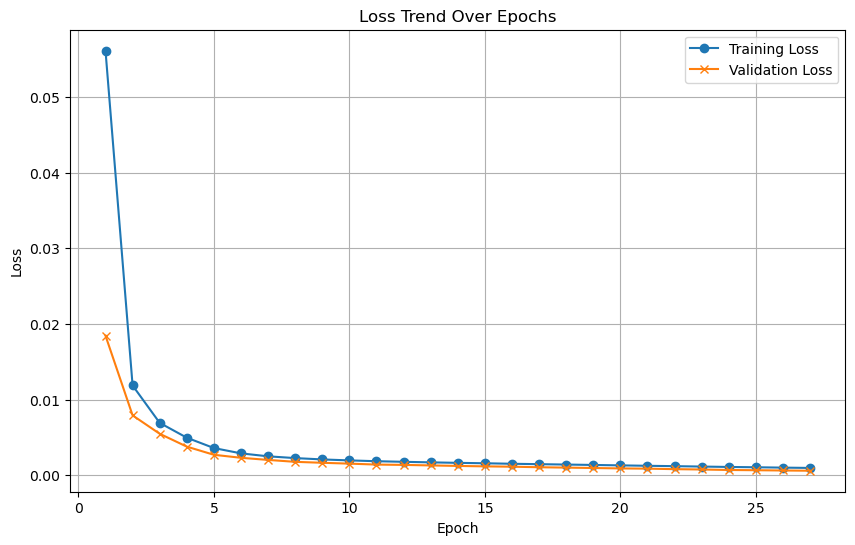

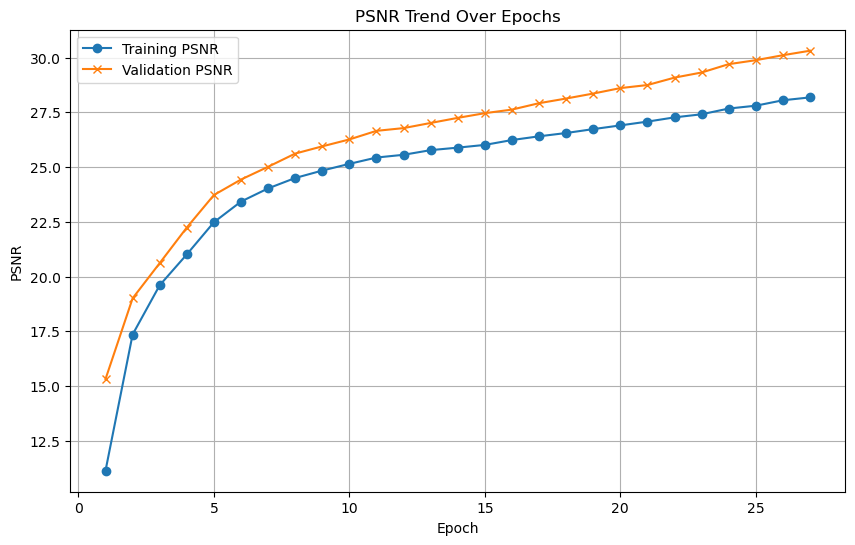

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/166 for test dataset.


    Processed batch 101/166 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2068
    Validation Batch [1/1], Loss: 2.2050
Validation Loss: 2.2050, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2050. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1378
    Validation Batch [1/1], Loss: 2.2050
Validation Loss: 2.2050, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0952
    Validation Batch [1/1], Loss: 2.2050
Validation Loss: 2.2050, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0735
    Validation Batch [1/1], Loss: 2.2049
Validation Loss: 2.2049, Validation Accuracy: 11.11%
Validation loss improved from 2.2050 to 2.2049. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] co

Epoch [11/1000] completed, Average Training Loss: 1.9088
    Validation Batch [1/1], Loss: 2.1951
Validation Loss: 2.1951, Validation Accuracy: 11.11%
Validation loss improved from 2.1991 to 2.1951. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.8836
    Validation Batch [1/1], Loss: 2.1893
Validation Loss: 2.1893, Validation Accuracy: 11.11%
Validation loss improved from 2.1951 to 2.1893. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 1.8692
    Validation Batch [1/1], Loss: 2.1807
Validation Loss: 2.1807, Validation Accuracy: 11.11%
Validation loss improved from 2.1893 to 2.1807. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 1.8372
    Validation Batch [1/1], Loss: 2.1678
Validation Loss: 2.1678, Validation Accuracy: 11.11%
Validation loss improved from 2.1807 to 2.1678. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [1

Epoch [27/1000] completed, Average Training Loss: 1.6286
    Validation Batch [1/1], Loss: 1.7525
Validation Loss: 1.7525, Validation Accuracy: 57.78%
Validation loss improved from 1.7873 to 1.7525. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 1.5975
    Validation Batch [1/1], Loss: 1.7214
Validation Loss: 1.7214, Validation Accuracy: 64.44%
Validation loss improved from 1.7525 to 1.7214. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 1.6201
    Validation Batch [1/1], Loss: 1.6922
Validation Loss: 1.6922, Validation Accuracy: 71.11%
Validation loss improved from 1.7214 to 1.6922. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 1.5904
    Validation Batch [1/1], Loss: 1.6588
Validation Loss: 1.6588, Validation Accuracy: 68.89%
Validation loss improved from 1.6922 to 1.6588. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [3

    Validation Batch [1/1], Loss: 1.4130
Validation Loss: 1.4130, Validation Accuracy: 71.11%
Validation loss improved from 1.4185 to 1.4130. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 1.3927
    Validation Batch [1/1], Loss: 1.3992
Validation Loss: 1.3992, Validation Accuracy: 75.56%
Validation loss improved from 1.4130 to 1.3992. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 1.3593
    Validation Batch [1/1], Loss: 1.3989
Validation Loss: 1.3989, Validation Accuracy: 84.44%
Validation loss improved from 1.3992 to 1.3989. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 1.3577
    Validation Batch [1/1], Loss: 1.3822
Validation Loss: 1.3822, Validation Accuracy: 84.44%
Validation loss improved from 1.3989 to 1.3822. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.3540
    Vali

Epoch [61/1000] completed, Average Training Loss: 1.1621
    Validation Batch [1/1], Loss: 1.1784
Validation Loss: 1.1784, Validation Accuracy: 88.89%
Validation loss improved from 1.1883 to 1.1784. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.1462
    Validation Batch [1/1], Loss: 1.1631
Validation Loss: 1.1631, Validation Accuracy: 88.89%
Validation loss improved from 1.1784 to 1.1631. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.1251
    Validation Batch [1/1], Loss: 1.1550
Validation Loss: 1.1550, Validation Accuracy: 91.11%
Validation loss improved from 1.1631 to 1.1550. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.1020
    Validation Batch [1/1], Loss: 1.1419
Validation Loss: 1.1419, Validation Accuracy: 91.11%
Validation loss improved from 1.1550 to 1.1419. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 0.9346
Validation Loss: 0.9346, Validation Accuracy: 88.89%
Validation loss improved from 0.9575 to 0.9346. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 0.8857
    Validation Batch [1/1], Loss: 0.9233
Validation Loss: 0.9233, Validation Accuracy: 91.11%
Validation loss improved from 0.9346 to 0.9233. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 0.8660
    Validation Batch [1/1], Loss: 0.9019
Validation Loss: 0.9019, Validation Accuracy: 88.89%
Validation loss improved from 0.9233 to 0.9019. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 0.8571
    Validation Batch [1/1], Loss: 0.8783
Validation Loss: 0.8783, Validation Accuracy: 88.89%
Validation loss improved from 0.9019 to 0.8783. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 0.8532
    Vali

Validation Loss: 0.6928, Validation Accuracy: 91.11%
Validation loss improved from 0.6977 to 0.6928. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 0.6398
    Validation Batch [1/1], Loss: 0.6738
Validation Loss: 0.6738, Validation Accuracy: 88.89%
Validation loss improved from 0.6928 to 0.6738. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 0.6494
    Validation Batch [1/1], Loss: 0.6635
Validation Loss: 0.6635, Validation Accuracy: 88.89%
Validation loss improved from 0.6738 to 0.6635. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 0.6269
    Validation Batch [1/1], Loss: 0.6720
Validation Loss: 0.6720, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 0.6284
    Validation Batch [1/1], Loss: 0.6739
Validation Loss: 0.6739

Epoch [110/1000] completed, Average Training Loss: 0.4734
    Validation Batch [1/1], Loss: 0.4995
Validation Loss: 0.4995, Validation Accuracy: 93.33%
Validation loss improved from 0.5131 to 0.4995. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 0.4591
    Validation Batch [1/1], Loss: 0.5055
Validation Loss: 0.5055, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 0.4724
    Validation Batch [1/1], Loss: 0.4787
Validation Loss: 0.4787, Validation Accuracy: 93.33%
Validation loss improved from 0.4995 to 0.4787. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 0.4317
    Validation Batch [1/1], Loss: 0.4725
Validation Loss: 0.4725, Validation Accuracy: 93.33%
Validation loss improved from 0.4787 to 0.4725. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000

Epoch [128/1000] completed, Average Training Loss: 0.3252
    Validation Batch [1/1], Loss: 0.3947
Validation Loss: 0.3947, Validation Accuracy: 93.33%
Validation loss improved from 0.4074 to 0.3947. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 0.3099
    Validation Batch [1/1], Loss: 0.3869
Validation Loss: 0.3869, Validation Accuracy: 93.33%
Validation loss improved from 0.3947 to 0.3869. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 0.3179
    Validation Batch [1/1], Loss: 0.4198
Validation Loss: 0.4198, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.2992
    Validation Batch [1/1], Loss: 0.3829
Validation Loss: 0.3829, Validation Accuracy: 91.11%
Validation loss improved from 0.3869 to 0.3829. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000

Epoch [145/1000] completed, Average Training Loss: 0.2333
    Validation Batch [1/1], Loss: 0.3404
Validation Loss: 0.3404, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.2220
    Validation Batch [1/1], Loss: 0.2931
Validation Loss: 0.2931, Validation Accuracy: 95.56%
Validation loss improved from 0.3244 to 0.2931. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.2374
    Validation Batch [1/1], Loss: 0.3188
Validation Loss: 0.3188, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.2087
    Validation Batch [1/1], Loss: 0.3584
Validation Loss: 0.3584, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training 

Epoch [162/1000] completed, Average Training Loss: 0.1640
    Validation Batch [1/1], Loss: 0.2859
Validation Loss: 0.2859, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.1734
    Validation Batch [1/1], Loss: 0.2600
Validation Loss: 0.2600, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.1702
    Validation Batch [1/1], Loss: 0.2490
Validation Loss: 0.2490, Validation Accuracy: 95.56%
Validation loss improved from 0.2558 to 0.2490. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.1653
    Validation Batch [1/1], Loss: 0.2535
Validation Loss: 0.2535, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training 

Epoch [179/1000] completed, Average Training Loss: 0.1367
    Validation Batch [1/1], Loss: 0.2633
Validation Loss: 0.2633, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 0.1178
    Validation Batch [1/1], Loss: 0.2350
Validation Loss: 0.2350, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.1219
    Validation Batch [1/1], Loss: 0.2159
Validation Loss: 0.2159, Validation Accuracy: 95.56%
Validation loss improved from 0.2254 to 0.2159. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 0.1215
    Validation Batch [1/1], Loss: 0.3655
Validation Loss: 0.3655, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training 

Epoch [197/1000] completed, Average Training Loss: 0.1006
    Validation Batch [1/1], Loss: 0.2345
Validation Loss: 0.2345, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.0964
    Validation Batch [1/1], Loss: 0.2634
Validation Loss: 0.2634, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.0948
    Validation Batch [1/1], Loss: 0.2547
Validation Loss: 0.2547, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.2648
Validation Loss: 0.2648, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.0914
  

Epoch [215/1000] completed, Average Training Loss: 0.0805
    Validation Batch [1/1], Loss: 0.2695
Validation Loss: 0.2695, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.1917
Validation Loss: 0.1917, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.0758
    Validation Batch [1/1], Loss: 0.1913
Validation Loss: 0.1913, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.0820
    Validation Batch [1/1], Loss: 0.2290
Validation Loss: 0.2290, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.0722
  

Epoch [232/1000] completed, Average Training Loss: 0.0627
    Validation Batch [1/1], Loss: 0.3149
Validation Loss: 0.3149, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.2209
Validation Loss: 0.2209, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.0666
    Validation Batch [1/1], Loss: 0.2327
Validation Loss: 0.2327, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.2016
Validation Loss: 0.2016, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.052

Epoch [250/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.2686
Validation Loss: 0.2686, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.2783
Validation Loss: 0.2783, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.2818
Validation Loss: 0.2818, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.2659
Validation Loss: 0.2659, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.053

Epoch [267/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.1841
Validation Loss: 0.1841, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.1898
Validation Loss: 0.1898, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0417
    Validation Batch [1/1], Loss: 0.1902
Validation Loss: 0.1902, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.2115
Validation Loss: 0.2115, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0440
  

Epoch [285/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.3176
Validation Loss: 0.3176, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.2065
Validation Loss: 0.2065, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.1740
Validation Loss: 0.1740, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.2036
Validation Loss: 0.2036, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.039

Epoch [302/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.1976
Validation Loss: 0.1976, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.0328
    Validation Batch [1/1], Loss: 0.1921
Validation Loss: 0.1921, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.0327
    Validation Batch [1/1], Loss: 0.1979
Validation Loss: 0.1979, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.1799
Validation Loss: 0.1799, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.033

    Validation Batch [1/1], Loss: 0.1945
Validation Loss: 0.1945, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0268
    Validation Batch [1/1], Loss: 0.1775
Validation Loss: 0.1775, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.2301
Validation Loss: 0.2301, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.2614
Validation Loss: 0.2614, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.3528
Validation Loss

Epoch [337/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.2192
Validation Loss: 0.2192, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.2173
Validation Loss: 0.2173, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.0276
    Validation Batch [1/1], Loss: 0.2203
Validation Loss: 0.2203, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.2479
Validation Loss: 0.2479, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.023

Epoch [355/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.2618
Validation Loss: 0.2618, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.0252
    Validation Batch [1/1], Loss: 0.2264
Validation Loss: 0.2264, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.0204
    Validation Batch [1/1], Loss: 0.2135
Validation Loss: 0.2135, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.0202
    Validation Batch [1/1], Loss: 0.1832
Validation Loss: 0.1832, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.025

Epoch [373/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.2637
Validation Loss: 0.2637, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 373. No improvement for 100 epochs.
Loading the best model weights...


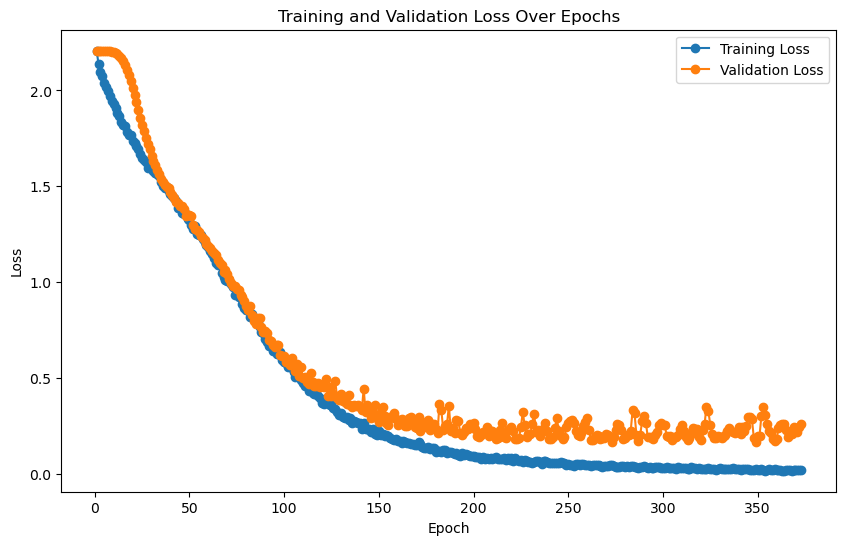

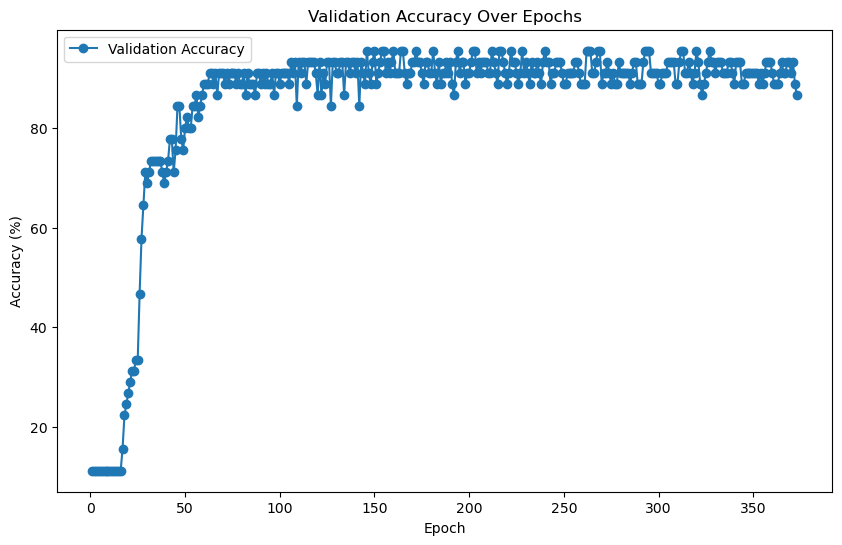


Evaluating on the test set...
    Test Batch [1/166], Loss: 0.2040



Final Test Loss: 0.3027, Test Accuracy: 91.44%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.


  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.


  Processed batch 90/166 for test dataset.
  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.


  Processed batch 140/166 for test dataset.
  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42371, 64), Test labels shape: (42371,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.80      0.62         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42371, 64)
Test labels shape: (42371,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3157  |  Val Loss: 2.0885
Validation loss improved from inf to 2.0885.


[Epoch 2/1000] Train Loss: 2.0167  |  Val Loss: 1.9290
Validation loss improved from 2.0885 to 1.9290.
[Epoch 3/1000] Train Loss: 1.8713  |  Val Loss: 1.8043
Validation loss improved from 1.9290 to 1.8043.
[Epoch 4/1000] Train Loss: 1.7438  |  Val Loss: 1.6844
Validation loss improved from 1.8043 to 1.6844.
[Epoch 5/1000] Train Loss: 1.6138  |  Val Loss: 1.5629
Validation loss improved from 1.6844 to 1.5629.
[Epoch 6/1000] Train Loss: 1.4886  |  Val Loss: 1.4432
Validation loss improved from 1.5629 to 1.4432.
[Epoch 7/1000] Train Loss: 1.3709  |  Val Loss: 1.3316
Validation loss improved from 1.4432 to 1.3316.
[Epoch 8/1000] Train Loss: 1.2614  |  Val Loss: 1.2331
Validation loss improved from 1.3316 to 1.2331.
[Epoch 9/1000] Train Loss: 1.1571  |  Val Loss: 1.1289
Validation loss improved from 1.2331 to 1.1289.
[Epoch 10/1000] Train Loss: 1.0706  |  Val Loss: 1.0320
Validation loss improved from 1.1289 to 1.0320.
[Epoch 11/1000] Train Loss: 0.9798  |  Val Loss: 0.9543
Validation loss 

[Epoch 12/1000] Train Loss: 0.8990  |  Val Loss: 0.8794
Validation loss improved from 0.9543 to 0.8794.
[Epoch 13/1000] Train Loss: 0.8257  |  Val Loss: 0.8132
Validation loss improved from 0.8794 to 0.8132.
[Epoch 14/1000] Train Loss: 0.7648  |  Val Loss: 0.7588
Validation loss improved from 0.8132 to 0.7588.
[Epoch 15/1000] Train Loss: 0.7097  |  Val Loss: 0.7016
Validation loss improved from 0.7588 to 0.7016.
[Epoch 16/1000] Train Loss: 0.6626  |  Val Loss: 0.6672
Validation loss improved from 0.7016 to 0.6672.


[Epoch 17/1000] Train Loss: 0.6239  |  Val Loss: 0.6163
Validation loss improved from 0.6672 to 0.6163.
[Epoch 18/1000] Train Loss: 0.5902  |  Val Loss: 0.5998
Validation loss improved from 0.6163 to 0.5998.
[Epoch 19/1000] Train Loss: 0.5550  |  Val Loss: 0.5560
Validation loss improved from 0.5998 to 0.5560.
[Epoch 20/1000] Train Loss: 0.5307  |  Val Loss: 0.5365
Validation loss improved from 0.5560 to 0.5365.
[Epoch 21/1000] Train Loss: 0.4912  |  Val Loss: 0.5041
Validation loss improved from 0.5365 to 0.5041.
[Epoch 22/1000] Train Loss: 0.4641  |  Val Loss: 0.4825
Validation loss improved from 0.5041 to 0.4825.
[Epoch 23/1000] Train Loss: 0.4508  |  Val Loss: 0.4581
Validation loss improved from 0.4825 to 0.4581.
[Epoch 24/1000] Train Loss: 0.4340  |  Val Loss: 0.4573
Validation loss improved from 0.4581 to 0.4573.
[Epoch 25/1000] Train Loss: 0.4015  |  Val Loss: 0.4433
Validation loss improved from 0.4573 to 0.4433.
[Epoch 26/1000] Train Loss: 0.3965  |  Val Loss: 0.4292
Validati

[Epoch 30/1000] Train Loss: 0.3466  |  Val Loss: 0.4034
Validation loss improved from 0.4083 to 0.4034.
[Epoch 31/1000] Train Loss: 0.3487  |  Val Loss: 0.3962
Validation loss improved from 0.4034 to 0.3962.
[Epoch 32/1000] Train Loss: 0.3383  |  Val Loss: 0.3936
Validation loss improved from 0.3962 to 0.3936.
[Epoch 33/1000] Train Loss: 0.3229  |  Val Loss: 0.4345
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 0.3076  |  Val Loss: 0.3911
Validation loss improved from 0.3936 to 0.3911.


[Epoch 35/1000] Train Loss: 0.3078  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.2976  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 37/1000] Train Loss: 0.2895  |  Val Loss: 0.3914
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 38/1000] Train Loss: 0.2809  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 39/1000] Train Loss: 0.2771  |  Val Loss: 0.3933
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 40/1000] Train Loss: 0.2711  |  Val Loss: 0.3976
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 41/1000] Train Loss: 0.2722  |  Val Loss: 0.4098
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 42/1000] Train Loss: 0.2689  |  Val Loss: 0.4163
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 43/1000] Train Loss: 0.2697  |  Val Loss: 0.3931
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 44/

[Epoch 47/1000] Train Loss: 0.2504  |  Val Loss: 0.3976
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 48/1000] Train Loss: 0.2464  |  Val Loss: 0.4239
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 49/1000] Train Loss: 0.2337  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 50/1000] Train Loss: 0.2279  |  Val Loss: 0.4477
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 51/1000] Train Loss: 0.2343  |  Val Loss: 0.4249
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 52/1000] Train Loss: 0.2281  |  Val Loss: 0.4447
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 53/1000] Train Loss: 0.2271  |  Val Loss: 0.4463
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 54/1000] Train Loss: 0.2159  |  Val Loss: 0.4772
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 55/1000] Train Loss: 0.2218  |  Val Loss: 0.4375
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 56/1000] Train Loss: 0.2174  |  Val Loss: 0.4848
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 57/1000] Train Loss: 0.2105  |  Val Loss: 0.4512
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 58/1000] Train Loss: 0.2116  |  Val Loss: 0.4632
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 59/1000] Train Loss: 0.1996  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 60/1000] Train Loss: 0.2035  |  Val Loss: 0.4587
!! Validation loss did NOT improve !! Patience: 26/100
[

[Epoch 64/1000] Train Loss: 0.2008  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 65/1000] Train Loss: 0.2008  |  Val Loss: 0.4920
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 66/1000] Train Loss: 0.1921  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 67/1000] Train Loss: 0.2001  |  Val Loss: 0.4858
!! Validation loss did NOT improve !! Patience: 33/100


[Epoch 68/1000] Train Loss: 0.1805  |  Val Loss: 0.5057
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 69/1000] Train Loss: 0.1880  |  Val Loss: 0.4826
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 70/1000] Train Loss: 0.1784  |  Val Loss: 0.5039
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 71/1000] Train Loss: 0.1750  |  Val Loss: 0.5065
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 72/1000] Train Loss: 0.1705  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 73/1000] Train Loss: 0.1679  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 74/1000] Train Loss: 0.1572  |  Val Loss: 0.5324
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 75/1000] Train Loss: 0.1590  |  Val Loss: 0.4961
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 76/1000] Train Loss: 0.1595  |  Val Loss: 0.5147
!! Validation loss did NOT improve !! Patience: 42/100
[

[Epoch 82/1000] Train Loss: 0.1384  |  Val Loss: 0.5544
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 83/1000] Train Loss: 0.1419  |  Val Loss: 0.5558
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 84/1000] Train Loss: 0.1462  |  Val Loss: 0.5390
!! Validation loss did NOT improve !! Patience: 50/100


[Epoch 85/1000] Train Loss: 0.1364  |  Val Loss: 0.5536
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 86/1000] Train Loss: 0.1335  |  Val Loss: 0.5636
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 87/1000] Train Loss: 0.1419  |  Val Loss: 0.5480
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 88/1000] Train Loss: 0.1455  |  Val Loss: 0.5490
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 89/1000] Train Loss: 0.1424  |  Val Loss: 0.5874
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 90/1000] Train Loss: 0.1340  |  Val Loss: 0.6110
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 91/1000] Train Loss: 0.1367  |  Val Loss: 0.5488
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 92/1000] Train Loss: 0.1230  |  Val Loss: 0.6144
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 93/1000] Train Loss: 0.1201  |  Val Loss: 0.5715
!! Validation loss did NOT improve !! Patience: 59/100
[

[Epoch 98/1000] Train Loss: 0.1123  |  Val Loss: 0.5775
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 99/1000] Train Loss: 0.1176  |  Val Loss: 0.6087
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 100/1000] Train Loss: 0.1108  |  Val Loss: 0.5978
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 101/1000] Train Loss: 0.1054  |  Val Loss: 0.5907
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 102/1000] Train Loss: 0.1127  |  Val Loss: 0.6158
!! Validation loss did NOT improve !! Patience: 68/100


[Epoch 103/1000] Train Loss: 0.1078  |  Val Loss: 0.6046
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 104/1000] Train Loss: 0.1042  |  Val Loss: 0.6272
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 105/1000] Train Loss: 0.1085  |  Val Loss: 0.5961
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 106/1000] Train Loss: 0.1026  |  Val Loss: 0.6593
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 107/1000] Train Loss: 0.1038  |  Val Loss: 0.6402
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 108/1000] Train Loss: 0.1014  |  Val Loss: 0.6085
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 109/1000] Train Loss: 0.0997  |  Val Loss: 0.6556
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 110/1000] Train Loss: 0.1003  |  Val Loss: 0.6028
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 111/1000] Train Loss: 0.1115  |  Val Loss: 0.6430
!! Validation loss did NOT improve !! Patience:

[Epoch 115/1000] Train Loss: 0.1074  |  Val Loss: 0.6662
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 116/1000] Train Loss: 0.1079  |  Val Loss: 0.6132
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 117/1000] Train Loss: 0.0918  |  Val Loss: 0.7083
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 118/1000] Train Loss: 0.1059  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 119/1000] Train Loss: 0.0845  |  Val Loss: 0.6767
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 120/1000] Train Loss: 0.0849  |  Val Loss: 0.6991
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 121/1000] Train Loss: 0.0866  |  Val Loss: 0.6669
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 122/1000] Train Loss: 0.0835  |  Val Loss: 0.6801
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 123/1000] Train Loss: 0.0864  |  Val Loss: 0.7107
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 124/1000] Train Loss: 0.0842  |  Val Loss: 0.6750
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 125/1000] Train Loss: 0.0947  |  Val Loss: 0.7148
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 126/1000] Train Loss: 0.0844  |  Val Loss: 0.7090
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 127/1000] Train Loss: 0.0778  |  Val Loss: 0.6745
!! Validation loss did NOT improve !! Patience:

[Epoch 132/1000] Train Loss: 0.0817  |  Val Loss: 0.7060
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 133/1000] Train Loss: 0.0879  |  Val Loss: 0.6977
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 134/1000] Train Loss: 0.0873  |  Val Loss: 0.7226
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 134 !!
No improvement for 100 epochs.


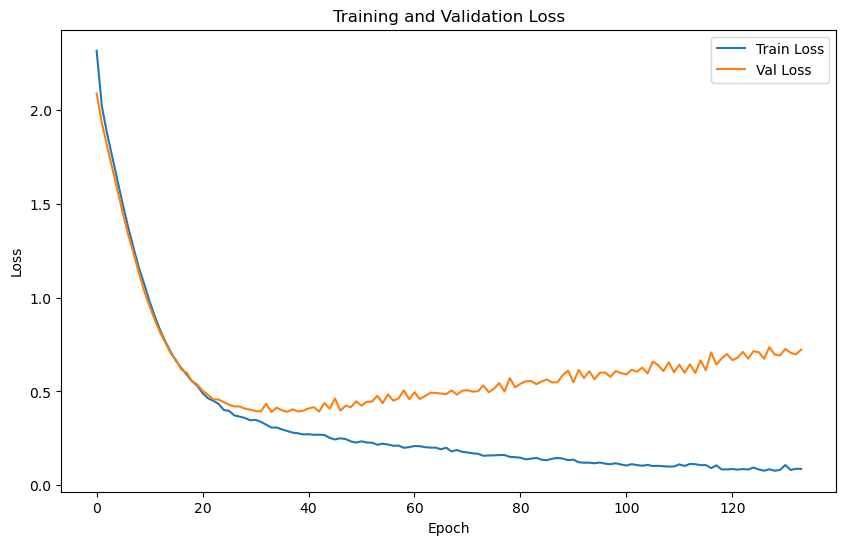

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0630 | Test Accuracy: 79.84%


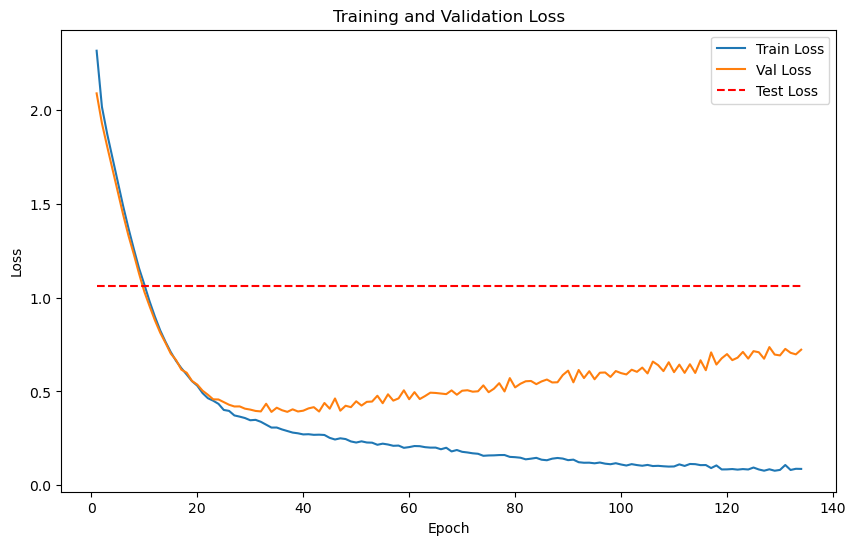

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.2138


    Batch [2/2], Train Loss: 7.9552
Epoch [1/2000], Avg Train Loss: 8.0845
Epoch [1/2000], Avg Val Loss: 3.9885
Validation loss improved from inf to 3.9885. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.1279
    Batch [2/2], Train Loss: 8.2614
Epoch [2/2000], Avg Train Loss: 8.1946
Epoch [2/2000], Avg Val Loss: 3.9146
Validation loss improved from 3.9885 to 3.9146. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.9454
    Batch [2/2], Train Loss: 7.7789
Epoch [3/2000], Avg Train Loss: 7.8621
Epoch [3/2000], Avg Val Loss: 3.8452
Validation loss improved from 3.9146 to 3.8452. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.7695
    Batch [2/2], Train Loss: 7.7580
Epoch [4/2000], Avg Train Loss: 7.7637
Epoch [4/2000], Avg Val Loss: 3.7798
Validation loss improved from 3.8452 to 3.7798. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.5080
    Batch [2/2], Train Loss

    Batch [1/2], Train Loss: 6.7935
    Batch [2/2], Train Loss: 6.6916
Epoch [13/2000], Avg Train Loss: 6.7425
Epoch [13/2000], Avg Val Loss: 3.3275
Validation loss improved from 3.3665 to 3.3275. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.5685
    Batch [2/2], Train Loss: 6.3530
Epoch [14/2000], Avg Train Loss: 6.4608
Epoch [14/2000], Avg Val Loss: 3.2908
Validation loss improved from 3.3275 to 3.2908. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.5464
    Batch [2/2], Train Loss: 6.5917
Epoch [15/2000], Avg Train Loss: 6.5691
Epoch [15/2000], Avg Val Loss: 3.2563
Validation loss improved from 3.2908 to 3.2563. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.3718
    Batch [2/2], Train Loss: 6.3001
Epoch [16/2000], Avg Train Loss: 6.3359
Epoch [16/2000], Avg Val Loss: 3.2241
Validation loss improved from 3.2563 to 3.2241. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.6580
Epoch [26/2000], Avg Train Loss: 5.6670
Epoch [26/2000], Avg Val Loss: 2.9994
Validation loss improved from 3.0158 to 2.9994. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.7007
    Batch [2/2], Train Loss: 5.5537
Epoch [27/2000], Avg Train Loss: 5.6272
Epoch [27/2000], Avg Val Loss: 2.9841
Validation loss improved from 2.9994 to 2.9841. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.6254
    Batch [2/2], Train Loss: 5.5129
Epoch [28/2000], Avg Train Loss: 5.5692
Epoch [28/2000], Avg Val Loss: 2.9698
Validation loss improved from 2.9841 to 2.9698. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.5663
    Batch [2/2], Train Loss: 5.5082
Epoch [29/2000], Avg Train Loss: 5.5373
Epoch [29/2000], Avg Val Loss: 2.9562
Validation loss improved from 2.9698 to 2.9562. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.3641
    Batch [2

    Batch [2/2], Train Loss: 5.1384
Epoch [39/2000], Avg Train Loss: 5.1716
Epoch [39/2000], Avg Val Loss: 2.8568
Validation loss improved from 2.8644 to 2.8568. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.1580
    Batch [2/2], Train Loss: 5.1296
Epoch [40/2000], Avg Train Loss: 5.1438
Epoch [40/2000], Avg Val Loss: 2.8494
Validation loss improved from 2.8568 to 2.8494. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.0867
    Batch [2/2], Train Loss: 5.0180
Epoch [41/2000], Avg Train Loss: 5.0523
Epoch [41/2000], Avg Val Loss: 2.8423
Validation loss improved from 2.8494 to 2.8423. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.0188
    Batch [2/2], Train Loss: 5.0471
Epoch [42/2000], Avg Train Loss: 5.0330
Epoch [42/2000], Avg Val Loss: 2.8354
Validation loss improved from 2.8423 to 2.8354. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 5.0302
    Batch [2

    Batch [1/2], Train Loss: 4.8391
    Batch [2/2], Train Loss: 4.7966
Epoch [54/2000], Avg Train Loss: 4.8178
Epoch [54/2000], Avg Val Loss: 2.7712
Validation loss improved from 2.7756 to 2.7712. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.7915
    Batch [2/2], Train Loss: 4.8223
Epoch [55/2000], Avg Train Loss: 4.8069
Epoch [55/2000], Avg Val Loss: 2.7669
Validation loss improved from 2.7712 to 2.7669. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.8561
    Batch [2/2], Train Loss: 4.7628
Epoch [56/2000], Avg Train Loss: 4.8094
Epoch [56/2000], Avg Val Loss: 2.7626
Validation loss improved from 2.7669 to 2.7626. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.7883
    Batch [2/2], Train Loss: 4.7023
Epoch [57/2000], Avg Train Loss: 4.7453
Epoch [57/2000], Avg Val Loss: 2.7584
Validation loss improved from 2.7626 to 2.7584. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.6608
Epoch [67/2000], Avg Train Loss: 4.6600
Epoch [67/2000], Avg Val Loss: 2.7184
Validation loss improved from 2.7221 to 2.7184. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 4.6542
    Batch [2/2], Train Loss: 4.5694
Epoch [68/2000], Avg Train Loss: 4.6118
Epoch [68/2000], Avg Val Loss: 2.7147
Validation loss improved from 2.7184 to 2.7147. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.6494
    Batch [2/2], Train Loss: 4.6094
Epoch [69/2000], Avg Train Loss: 4.6294
Epoch [69/2000], Avg Val Loss: 2.7110
Validation loss improved from 2.7147 to 2.7110. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 4.5586
    Batch [2/2], Train Loss: 4.6148
Epoch [70/2000], Avg Train Loss: 4.5867
Epoch [70/2000], Avg Val Loss: 2.7073
Validation loss improved from 2.7110 to 2.7073. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.6398
    Batch [2

    Batch [1/2], Train Loss: 4.5632
    Batch [2/2], Train Loss: 4.5100
Epoch [80/2000], Avg Train Loss: 4.5366
Epoch [80/2000], Avg Val Loss: 2.6719
Validation loss improved from 2.6753 to 2.6719. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.5055
    Batch [2/2], Train Loss: 4.5342
Epoch [81/2000], Avg Train Loss: 4.5198
Epoch [81/2000], Avg Val Loss: 2.6685
Validation loss improved from 2.6719 to 2.6685. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.4771
    Batch [2/2], Train Loss: 4.4326
Epoch [82/2000], Avg Train Loss: 4.4549
Epoch [82/2000], Avg Val Loss: 2.6652
Validation loss improved from 2.6685 to 2.6652. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.4646
    Batch [2/2], Train Loss: 4.4785
Epoch [83/2000], Avg Train Loss: 4.4716
Epoch [83/2000], Avg Val Loss: 2.6618
Validation loss improved from 2.6652 to 2.6618. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.4190
Epoch [92/2000], Avg Train Loss: 4.4056
Epoch [92/2000], Avg Val Loss: 2.6323
Validation loss improved from 2.6353 to 2.6323. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.3863
    Batch [2/2], Train Loss: 4.3857
Epoch [93/2000], Avg Train Loss: 4.3860
Epoch [93/2000], Avg Val Loss: 2.6293
Validation loss improved from 2.6323 to 2.6293. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 4.3918
    Batch [2/2], Train Loss: 4.3324
Epoch [94/2000], Avg Train Loss: 4.3621
Epoch [94/2000], Avg Val Loss: 2.6263
Validation loss improved from 2.6293 to 2.6263. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.4339
    Batch [2/2], Train Loss: 4.4185
Epoch [95/2000], Avg Train Loss: 4.4262
Epoch [95/2000], Avg Val Loss: 2.6234
Validation loss improved from 2.6263 to 2.6234. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.4347
    Batch [2

    Batch [2/2], Train Loss: 4.3416
Epoch [105/2000], Avg Train Loss: 4.3473
Epoch [105/2000], Avg Val Loss: 2.5955
Validation loss improved from 2.5982 to 2.5955. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 4.3351
    Batch [2/2], Train Loss: 4.3267
Epoch [106/2000], Avg Train Loss: 4.3309
Epoch [106/2000], Avg Val Loss: 2.5928
Validation loss improved from 2.5955 to 2.5928. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.2603
    Batch [2/2], Train Loss: 4.3895
Epoch [107/2000], Avg Train Loss: 4.3249
Epoch [107/2000], Avg Val Loss: 2.5901
Validation loss improved from 2.5928 to 2.5901. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.2746
    Batch [2/2], Train Loss: 4.2983
Epoch [108/2000], Avg Train Loss: 4.2864
Epoch [108/2000], Avg Val Loss: 2.5874
Validation loss improved from 2.5901 to 2.5874. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.3008


    Batch [2/2], Train Loss: 4.2998
Epoch [116/2000], Avg Train Loss: 4.2722
Epoch [116/2000], Avg Val Loss: 2.5659
Validation loss improved from 2.5686 to 2.5659. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 4.2716
    Batch [2/2], Train Loss: 4.2799
Epoch [117/2000], Avg Train Loss: 4.2757
Epoch [117/2000], Avg Val Loss: 2.5633
Validation loss improved from 2.5659 to 2.5633. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.2198
    Batch [2/2], Train Loss: 4.2201
Epoch [118/2000], Avg Train Loss: 4.2200
Epoch [118/2000], Avg Val Loss: 2.5607
Validation loss improved from 2.5633 to 2.5607. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 4.2578
    Batch [2/2], Train Loss: 4.2624
Epoch [119/2000], Avg Train Loss: 4.2601
Epoch [119/2000], Avg Val Loss: 2.5582
Validation loss improved from 2.5607 to 2.5582. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.2820


    Batch [2/2], Train Loss: 4.1821
Epoch [131/2000], Avg Train Loss: 4.1738
Epoch [131/2000], Avg Val Loss: 2.5313
Validation loss improved from 2.5335 to 2.5313. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.2168
    Batch [2/2], Train Loss: 4.2184
Epoch [132/2000], Avg Train Loss: 4.2176
Epoch [132/2000], Avg Val Loss: 2.5292
Validation loss improved from 2.5313 to 2.5292. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.2465
    Batch [2/2], Train Loss: 4.2229
Epoch [133/2000], Avg Train Loss: 4.2347
Epoch [133/2000], Avg Val Loss: 2.5271
Validation loss improved from 2.5292 to 2.5271. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.2184
    Batch [2/2], Train Loss: 4.1869
Epoch [134/2000], Avg Train Loss: 4.2026
Epoch [134/2000], Avg Val Loss: 2.5251
Validation loss improved from 2.5271 to 2.5251. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.1641


    Batch [1/2], Train Loss: 4.1780
    Batch [2/2], Train Loss: 4.1341
Epoch [142/2000], Avg Train Loss: 4.1561
Epoch [142/2000], Avg Val Loss: 2.5099
Validation loss improved from 2.5117 to 2.5099. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.1833
    Batch [2/2], Train Loss: 4.1875
Epoch [143/2000], Avg Train Loss: 4.1854
Epoch [143/2000], Avg Val Loss: 2.5081
Validation loss improved from 2.5099 to 2.5081. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.1350
    Batch [2/2], Train Loss: 4.1385
Epoch [144/2000], Avg Train Loss: 4.1367
Epoch [144/2000], Avg Val Loss: 2.5062
Validation loss improved from 2.5081 to 2.5062. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.1337
    Batch [2/2], Train Loss: 4.1466
Epoch [145/2000], Avg Train Loss: 4.1402
Epoch [145/2000], Avg Val Loss: 2.5043
Validation loss improved from 2.5062 to 2.5043. Saving model...

LOG: Epoch [146/2000] - Training


Epoch [156/2000], Avg Val Loss: 2.4849
Validation loss improved from 2.4866 to 2.4849. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.1424
    Batch [2/2], Train Loss: 4.1027
Epoch [157/2000], Avg Train Loss: 4.1226
Epoch [157/2000], Avg Val Loss: 2.4832
Validation loss improved from 2.4849 to 2.4832. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.0944
    Batch [2/2], Train Loss: 4.1052
Epoch [158/2000], Avg Train Loss: 4.0998
Epoch [158/2000], Avg Val Loss: 2.4814
Validation loss improved from 2.4832 to 2.4814. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.1140
    Batch [2/2], Train Loss: 4.0509
Epoch [159/2000], Avg Train Loss: 4.0824
Epoch [159/2000], Avg Val Loss: 2.4797
Validation loss improved from 2.4814 to 2.4797. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.1825
    Batch [2/2], Train Loss: 4.1227
Epoch [160/2000], Avg Train Loss: 4.1526


    Batch [1/2], Train Loss: 4.0861
    Batch [2/2], Train Loss: 4.0740
Epoch [166/2000], Avg Train Loss: 4.0801
Epoch [166/2000], Avg Val Loss: 2.4686
Validation loss improved from 2.4701 to 2.4686. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.0577
    Batch [2/2], Train Loss: 4.0602
Epoch [167/2000], Avg Train Loss: 4.0589
Epoch [167/2000], Avg Val Loss: 2.4672
Validation loss improved from 2.4686 to 2.4672. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.0828
    Batch [2/2], Train Loss: 4.0613
Epoch [168/2000], Avg Train Loss: 4.0720
Epoch [168/2000], Avg Val Loss: 2.4657
Validation loss improved from 2.4672 to 2.4657. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 4.0581
    Batch [2/2], Train Loss: 4.0534
Epoch [169/2000], Avg Train Loss: 4.0557
Epoch [169/2000], Avg Val Loss: 2.4641
Validation loss improved from 2.4657 to 2.4641. Saving model...

LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 4.0620
    Batch [2/2], Train Loss: 4.1002
Epoch [180/2000], Avg Train Loss: 4.0811
Epoch [180/2000], Avg Val Loss: 2.4475
Validation loss improved from 2.4489 to 2.4475. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 3.9987
    Batch [2/2], Train Loss: 4.0258
Epoch [181/2000], Avg Train Loss: 4.0123
Epoch [181/2000], Avg Val Loss: 2.4461
Validation loss improved from 2.4475 to 2.4461. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.0634
    Batch [2/2], Train Loss: 4.0546
Epoch [182/2000], Avg Train Loss: 4.0590
Epoch [182/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4461 to 2.4449. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 4.0578
    Batch [2/2], Train Loss: 4.0225
Epoch [183/2000], Avg Train Loss: 4.0401
Epoch [183/2000], Avg Val Loss: 2.4437
Validation loss improved from 2.4449 to 2.4437. Saving model...

LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 4.0429
    Batch [2/2], Train Loss: 3.9914
Epoch [191/2000], Avg Train Loss: 4.0172
Epoch [191/2000], Avg Val Loss: 2.4339
Validation loss improved from 2.4352 to 2.4339. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.0541
    Batch [2/2], Train Loss: 4.0046
Epoch [192/2000], Avg Train Loss: 4.0294
Epoch [192/2000], Avg Val Loss: 2.4327
Validation loss improved from 2.4339 to 2.4327. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.0254
    Batch [2/2], Train Loss: 3.9796
Epoch [193/2000], Avg Train Loss: 4.0025
Epoch [193/2000], Avg Val Loss: 2.4315
Validation loss improved from 2.4327 to 2.4315. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.0310
    Batch [2/2], Train Loss: 3.9770
Epoch [194/2000], Avg Train Loss: 4.0040
Epoch [194/2000], Avg Val Loss: 2.4303
Validation loss improved from 2.4315 to 2.4303. Saving model...

LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 3.9897
    Batch [2/2], Train Loss: 4.0663
Epoch [205/2000], Avg Train Loss: 4.0280
Epoch [205/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4189 to 2.4176. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.0096
    Batch [2/2], Train Loss: 3.9662
Epoch [206/2000], Avg Train Loss: 3.9879
Epoch [206/2000], Avg Val Loss: 2.4164
Validation loss improved from 2.4176 to 2.4164. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 3.9998
    Batch [2/2], Train Loss: 4.0316
Epoch [207/2000], Avg Train Loss: 4.0157
Epoch [207/2000], Avg Val Loss: 2.4151
Validation loss improved from 2.4164 to 2.4151. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.0024
    Batch [2/2], Train Loss: 4.0164
Epoch [208/2000], Avg Train Loss: 4.0094
Epoch [208/2000], Avg Val Loss: 2.4138
Validation loss improved from 2.4151 to 2.4138. Saving model...

LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 3.9626
    Batch [2/2], Train Loss: 3.9603
Epoch [216/2000], Avg Train Loss: 3.9615
Epoch [216/2000], Avg Val Loss: 2.4055
Validation loss improved from 2.4064 to 2.4055. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 3.9865
    Batch [2/2], Train Loss: 3.9979
Epoch [217/2000], Avg Train Loss: 3.9922
Epoch [217/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4055 to 2.4047. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.0047
    Batch [2/2], Train Loss: 3.9584
Epoch [218/2000], Avg Train Loss: 3.9816
Epoch [218/2000], Avg Val Loss: 2.4039
Validation loss improved from 2.4047 to 2.4039. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 3.9997
    Batch [2/2], Train Loss: 3.9557
Epoch [219/2000], Avg Train Loss: 3.9777
Epoch [219/2000], Avg Val Loss: 2.4031
Validation loss improved from 2.4039 to 2.4031. Saving model...

LOG: Epoch [220/2000] - Training


    Batch [2/2], Train Loss: 3.9158
Epoch [227/2000], Avg Train Loss: 3.9535
Epoch [227/2000], Avg Val Loss: 2.3959
Validation loss improved from 2.3968 to 2.3959. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 3.9860
    Batch [2/2], Train Loss: 4.0174
Epoch [228/2000], Avg Train Loss: 4.0017
Epoch [228/2000], Avg Val Loss: 2.3950
Validation loss improved from 2.3959 to 2.3950. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 3.9463
    Batch [2/2], Train Loss: 3.9376
Epoch [229/2000], Avg Train Loss: 3.9420
Epoch [229/2000], Avg Val Loss: 2.3941
Validation loss improved from 2.3950 to 2.3941. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 3.9311
    Batch [2/2], Train Loss: 3.9097
Epoch [230/2000], Avg Train Loss: 3.9204
Epoch [230/2000], Avg Val Loss: 2.3932
Validation loss improved from 2.3941 to 2.3932. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 3.9056


    Batch [1/2], Train Loss: 3.9538
    Batch [2/2], Train Loss: 3.9068
Epoch [243/2000], Avg Train Loss: 3.9303
Epoch [243/2000], Avg Val Loss: 2.3821
Validation loss improved from 2.3828 to 2.3821. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 3.8882
    Batch [2/2], Train Loss: 3.8943
Epoch [244/2000], Avg Train Loss: 3.8912
Epoch [244/2000], Avg Val Loss: 2.3814
Validation loss improved from 2.3821 to 2.3814. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 3.9058
    Batch [2/2], Train Loss: 3.9170
Epoch [245/2000], Avg Train Loss: 3.9114
Epoch [245/2000], Avg Val Loss: 2.3806
Validation loss improved from 2.3814 to 2.3806. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 3.9208
    Batch [2/2], Train Loss: 3.9318
Epoch [246/2000], Avg Train Loss: 3.9263
Epoch [246/2000], Avg Val Loss: 2.3797
Validation loss improved from 2.3806 to 2.3797. Saving model...

LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 3.9096
    Batch [2/2], Train Loss: 3.9573
Epoch [251/2000], Avg Train Loss: 3.9334
Epoch [251/2000], Avg Val Loss: 2.3751
Validation loss improved from 2.3760 to 2.3751. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 3.9001
    Batch [2/2], Train Loss: 3.8805
Epoch [252/2000], Avg Train Loss: 3.8903
Epoch [252/2000], Avg Val Loss: 2.3743
Validation loss improved from 2.3751 to 2.3743. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 3.8745
    Batch [2/2], Train Loss: 3.8914
Epoch [253/2000], Avg Train Loss: 3.8830
Epoch [253/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3743 to 2.3735. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 3.8992
    Batch [2/2], Train Loss: 3.9164
Epoch [254/2000], Avg Train Loss: 3.9078
Epoch [254/2000], Avg Val Loss: 2.3726
Validation loss improved from 2.3735 to 2.3726. Saving model...

LOG: Epoch [255/2000] - Training


    Batch [2/2], Train Loss: 3.8039
Epoch [267/2000], Avg Train Loss: 3.8393
Epoch [267/2000], Avg Val Loss: 2.3653
Validation loss improved from 2.3660 to 2.3653. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 3.8609
    Batch [2/2], Train Loss: 3.9074
Epoch [268/2000], Avg Train Loss: 3.8842
Epoch [268/2000], Avg Val Loss: 2.3645
Validation loss improved from 2.3653 to 2.3645. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 3.8818
    Batch [2/2], Train Loss: 3.8663
Epoch [269/2000], Avg Train Loss: 3.8741
Epoch [269/2000], Avg Val Loss: 2.3636
Validation loss improved from 2.3645 to 2.3636. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 3.8559
    Batch [2/2], Train Loss: 3.8602
Epoch [270/2000], Avg Train Loss: 3.8580
Epoch [270/2000], Avg Val Loss: 2.3630
Validation loss improved from 2.3636 to 2.3630. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 3.8795


    Batch [1/2], Train Loss: 3.8299
    Batch [2/2], Train Loss: 3.8648
Epoch [275/2000], Avg Train Loss: 3.8474
Epoch [275/2000], Avg Val Loss: 2.3605
Validation loss improved from 2.3609 to 2.3605. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 3.8739
    Batch [2/2], Train Loss: 3.8642
Epoch [276/2000], Avg Train Loss: 3.8690
Epoch [276/2000], Avg Val Loss: 2.3601
Validation loss improved from 2.3605 to 2.3601. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 3.8487
    Batch [2/2], Train Loss: 3.9296
Epoch [277/2000], Avg Train Loss: 3.8892
Epoch [277/2000], Avg Val Loss: 2.3596
Validation loss improved from 2.3601 to 2.3596. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 3.8460
    Batch [2/2], Train Loss: 3.8886
Epoch [278/2000], Avg Train Loss: 3.8673
Epoch [278/2000], Avg Val Loss: 2.3590
Validation loss improved from 2.3596 to 2.3590. Saving model...

LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 3.8303
    Batch [2/2], Train Loss: 3.8529
Epoch [293/2000], Avg Train Loss: 3.8416
Epoch [293/2000], Avg Val Loss: 2.3487
Validation loss improved from 2.3494 to 2.3487. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 3.8635
    Batch [2/2], Train Loss: 3.8515
Epoch [294/2000], Avg Train Loss: 3.8575
Epoch [294/2000], Avg Val Loss: 2.3482
Validation loss improved from 2.3487 to 2.3482. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 3.8815
    Batch [2/2], Train Loss: 3.8859
Epoch [295/2000], Avg Train Loss: 3.8837
Epoch [295/2000], Avg Val Loss: 2.3476
Validation loss improved from 2.3482 to 2.3476. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 3.8554
    Batch [2/2], Train Loss: 3.8431
Epoch [296/2000], Avg Train Loss: 3.8493
Epoch [296/2000], Avg Val Loss: 2.3470
Validation loss improved from 2.3476 to 2.3470. Saving model...

LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 3.8410
    Batch [2/2], Train Loss: 3.8414
Epoch [300/2000], Avg Train Loss: 3.8412
Epoch [300/2000], Avg Val Loss: 2.3449
Validation loss improved from 2.3454 to 2.3449. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 3.8723
    Batch [2/2], Train Loss: 3.8457
Epoch [301/2000], Avg Train Loss: 3.8590
Epoch [301/2000], Avg Val Loss: 2.3446
Validation loss improved from 2.3449 to 2.3446. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 3.8256
    Batch [2/2], Train Loss: 3.8456
Epoch [302/2000], Avg Train Loss: 3.8356
Epoch [302/2000], Avg Val Loss: 2.3442
Validation loss improved from 2.3446 to 2.3442. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 3.8755
    Batch [2/2], Train Loss: 3.8206
Epoch [303/2000], Avg Train Loss: 3.8480
Epoch [303/2000], Avg Val Loss: 2.3438
Validation loss improved from 2.3442 to 2.3438. Saving model...

LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 3.8343
    Batch [2/2], Train Loss: 3.8297
Epoch [319/2000], Avg Train Loss: 3.8320
Epoch [319/2000], Avg Val Loss: 2.3375
Validation loss improved from 2.3380 to 2.3375. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.8424
    Batch [2/2], Train Loss: 3.8325
Epoch [320/2000], Avg Train Loss: 3.8375
Epoch [320/2000], Avg Val Loss: 2.3371
Validation loss improved from 2.3375 to 2.3371. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 3.8277
    Batch [2/2], Train Loss: 3.8130
Epoch [321/2000], Avg Train Loss: 3.8203
Epoch [321/2000], Avg Val Loss: 2.3367
Validation loss improved from 2.3371 to 2.3367. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 3.7565
    Batch [2/2], Train Loss: 3.7637
Epoch [322/2000], Avg Train Loss: 3.7601
Epoch [322/2000], Avg Val Loss: 2.3362
Validation loss improved from 2.3367 to 2.3362. Saving model...

LOG: Epoch [323/2000] - Training


    Batch [2/2], Train Loss: 3.7635
Epoch [327/2000], Avg Train Loss: 3.8011
Epoch [327/2000], Avg Val Loss: 2.3331
Validation loss improved from 2.3338 to 2.3331. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 3.8242
    Batch [2/2], Train Loss: 3.7972
Epoch [328/2000], Avg Train Loss: 3.8107
Epoch [328/2000], Avg Val Loss: 2.3323
Validation loss improved from 2.3331 to 2.3323. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.7935
    Batch [2/2], Train Loss: 3.7993
Epoch [329/2000], Avg Train Loss: 3.7964
Epoch [329/2000], Avg Val Loss: 2.3315
Validation loss improved from 2.3323 to 2.3315. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.7971
    Batch [2/2], Train Loss: 3.7999
Epoch [330/2000], Avg Train Loss: 3.7985
Epoch [330/2000], Avg Val Loss: 2.3307
Validation loss improved from 2.3315 to 2.3307. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 3.8313


Epoch [342/2000], Avg Val Loss: 2.3250
Validation loss improved from 2.3253 to 2.3250. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.7921
    Batch [2/2], Train Loss: 3.7921
Epoch [343/2000], Avg Train Loss: 3.7921
Epoch [343/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3250 to 2.3247. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.7623
    Batch [2/2], Train Loss: 3.7957
Epoch [344/2000], Avg Train Loss: 3.7790
Epoch [344/2000], Avg Val Loss: 2.3245
Validation loss improved from 2.3247 to 2.3245. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.7778
    Batch [2/2], Train Loss: 3.8262
Epoch [345/2000], Avg Train Loss: 3.8020
Epoch [345/2000], Avg Val Loss: 2.3242
Validation loss improved from 2.3245 to 2.3242. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 3.7759
    Batch [2/2], Train Loss: 3.7948
Epoch [346/2000], Avg Train Loss: 3.7854


Epoch [351/2000], Avg Val Loss: 2.3225
Validation loss improved from 2.3229 to 2.3225. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 3.7530
    Batch [2/2], Train Loss: 3.7639
Epoch [352/2000], Avg Train Loss: 3.7585
Epoch [352/2000], Avg Val Loss: 2.3219
Validation loss improved from 2.3225 to 2.3219. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 3.7845
    Batch [2/2], Train Loss: 3.8145
Epoch [353/2000], Avg Train Loss: 3.7995
Epoch [353/2000], Avg Val Loss: 2.3215
Validation loss improved from 2.3219 to 2.3215. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 3.7662
    Batch [2/2], Train Loss: 3.8277
Epoch [354/2000], Avg Train Loss: 3.7970
Epoch [354/2000], Avg Val Loss: 2.3210
Validation loss improved from 2.3215 to 2.3210. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 3.8011
    Batch [2/2], Train Loss: 3.8028
Epoch [355/2000], Avg Train Loss: 3.8019


    Batch [1/2], Train Loss: 3.8187
    Batch [2/2], Train Loss: 3.7462
Epoch [367/2000], Avg Train Loss: 3.7825
Epoch [367/2000], Avg Val Loss: 2.3145
Validation loss improved from 2.3149 to 2.3145. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.8272
    Batch [2/2], Train Loss: 3.7612
Epoch [368/2000], Avg Train Loss: 3.7942
Epoch [368/2000], Avg Val Loss: 2.3140
Validation loss improved from 2.3145 to 2.3140. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.7053
    Batch [2/2], Train Loss: 3.7599
Epoch [369/2000], Avg Train Loss: 3.7326
Epoch [369/2000], Avg Val Loss: 2.3136
Validation loss improved from 2.3140 to 2.3136. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.7539
    Batch [2/2], Train Loss: 3.8168
Epoch [370/2000], Avg Train Loss: 3.7854
Epoch [370/2000], Avg Val Loss: 2.3132
Validation loss improved from 2.3136 to 2.3132. Saving model...

LOG: Epoch [371/2000] - Training


    Batch [2/2], Train Loss: 3.7493
Epoch [378/2000], Avg Train Loss: 3.7605
Epoch [378/2000], Avg Val Loss: 2.3107
Validation loss improved from 2.3108 to 2.3107. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 3.7754
    Batch [2/2], Train Loss: 3.7513
Epoch [379/2000], Avg Train Loss: 3.7634
Epoch [379/2000], Avg Val Loss: 2.3105
Validation loss improved from 2.3107 to 2.3105. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 3.7591
    Batch [2/2], Train Loss: 3.7690
Epoch [380/2000], Avg Train Loss: 3.7641
Epoch [380/2000], Avg Val Loss: 2.3102
Validation loss improved from 2.3105 to 2.3102. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 3.7343
    Batch [2/2], Train Loss: 3.7429
Epoch [381/2000], Avg Train Loss: 3.7386
Epoch [381/2000], Avg Val Loss: 2.3097
Validation loss improved from 2.3102 to 2.3097. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 3.7489


    Batch [1/2], Train Loss: 3.7280
    Batch [2/2], Train Loss: 3.7455
Epoch [393/2000], Avg Train Loss: 3.7368
Epoch [393/2000], Avg Val Loss: 2.3058
Validation loss improved from 2.3060 to 2.3058. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 3.7234
    Batch [2/2], Train Loss: 3.7702
Epoch [394/2000], Avg Train Loss: 3.7468
Epoch [394/2000], Avg Val Loss: 2.3056
Validation loss improved from 2.3058 to 2.3056. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 3.7765
    Batch [2/2], Train Loss: 3.7845
Epoch [395/2000], Avg Train Loss: 3.7805
Epoch [395/2000], Avg Val Loss: 2.3054
Validation loss improved from 2.3056 to 2.3054. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.7592
    Batch [2/2], Train Loss: 3.7786
Epoch [396/2000], Avg Train Loss: 3.7689
Epoch [396/2000], Avg Val Loss: 2.3052
Validation loss improved from 2.3054 to 2.3052. Saving model...

LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 3.7697
    Batch [2/2], Train Loss: 3.7361
Epoch [404/2000], Avg Train Loss: 3.7529
Epoch [404/2000], Avg Val Loss: 2.3022
Validation loss improved from 2.3027 to 2.3022. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.6957
    Batch [2/2], Train Loss: 3.7495
Epoch [405/2000], Avg Train Loss: 3.7226
Epoch [405/2000], Avg Val Loss: 2.3017
Validation loss improved from 2.3022 to 2.3017. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.7005
    Batch [2/2], Train Loss: 3.7101
Epoch [406/2000], Avg Train Loss: 3.7053
Epoch [406/2000], Avg Val Loss: 2.3011
Validation loss improved from 2.3017 to 2.3011. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.6627
    Batch [2/2], Train Loss: 3.7332
Epoch [407/2000], Avg Train Loss: 3.6979
Epoch [407/2000], Avg Val Loss: 2.3004
Validation loss improved from 2.3011 to 2.3004. Saving model...

LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 3.7536
    Batch [2/2], Train Loss: 3.6871
Epoch [417/2000], Avg Train Loss: 3.7203
Epoch [417/2000], Avg Val Loss: 2.2970
Validation loss improved from 2.2974 to 2.2970. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.7805
    Batch [2/2], Train Loss: 3.7238
Epoch [418/2000], Avg Train Loss: 3.7521
Epoch [418/2000], Avg Val Loss: 2.2968
Validation loss improved from 2.2970 to 2.2968. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.7793
    Batch [2/2], Train Loss: 3.7076
Epoch [419/2000], Avg Train Loss: 3.7435
Epoch [419/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2968 to 2.2967. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.7475
    Batch [2/2], Train Loss: 3.7716
Epoch [420/2000], Avg Train Loss: 3.7595
Epoch [420/2000], Avg Val Loss: 2.2964
Validation loss improved from 2.2967 to 2.2964. Saving model...

LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 3.6973
    Batch [2/2], Train Loss: 3.7455
Epoch [430/2000], Avg Train Loss: 3.7214
Epoch [430/2000], Avg Val Loss: 2.2910
Validation loss improved from 2.2916 to 2.2910. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.7167
    Batch [2/2], Train Loss: 3.7687
Epoch [431/2000], Avg Train Loss: 3.7427
Epoch [431/2000], Avg Val Loss: 2.2905
Validation loss improved from 2.2910 to 2.2905. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.7301
    Batch [2/2], Train Loss: 3.6967
Epoch [432/2000], Avg Train Loss: 3.7134
Epoch [432/2000], Avg Val Loss: 2.2900
Validation loss improved from 2.2905 to 2.2900. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 3.7365
    Batch [2/2], Train Loss: 3.7096
Epoch [433/2000], Avg Train Loss: 3.7230
Epoch [433/2000], Avg Val Loss: 2.2897
Validation loss improved from 2.2900 to 2.2897. Saving model...

LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 3.7810
    Batch [2/2], Train Loss: 3.7011
Epoch [442/2000], Avg Train Loss: 3.7411
Epoch [442/2000], Avg Val Loss: 2.2855
Validation loss improved from 2.2857 to 2.2855. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 3.7070
    Batch [2/2], Train Loss: 3.7091
Epoch [443/2000], Avg Train Loss: 3.7081
Epoch [443/2000], Avg Val Loss: 2.2853
Validation loss improved from 2.2855 to 2.2853. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 3.6570
    Batch [2/2], Train Loss: 3.7338
Epoch [444/2000], Avg Train Loss: 3.6954
Epoch [444/2000], Avg Val Loss: 2.2850
Validation loss improved from 2.2853 to 2.2850. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 3.7114
    Batch [2/2], Train Loss: 3.6566
Epoch [445/2000], Avg Train Loss: 3.6840
Epoch [445/2000], Avg Val Loss: 2.2848
Validation loss improved from 2.2850 to 2.2848. Saving model...

LOG: Epoch [446/2000] - Training


    Batch [2/2], Train Loss: 3.7118
Epoch [454/2000], Avg Train Loss: 3.7149
Epoch [454/2000], Avg Val Loss: 2.2856
Validation loss did not improve. Patience: 7/100

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.6759
    Batch [2/2], Train Loss: 3.6862
Epoch [455/2000], Avg Train Loss: 3.6811
Epoch [455/2000], Avg Val Loss: 2.2858
Validation loss did not improve. Patience: 8/100

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 3.7184
    Batch [2/2], Train Loss: 3.7095
Epoch [456/2000], Avg Train Loss: 3.7139
Epoch [456/2000], Avg Val Loss: 2.2861
Validation loss did not improve. Patience: 9/100

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 3.7167
    Batch [2/2], Train Loss: 3.7193
Epoch [457/2000], Avg Train Loss: 3.7180
Epoch [457/2000], Avg Val Loss: 2.2864
Validation loss did not improve. Patience: 10/100

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 3.7213
    Batch [2/2], Train Loss: 3.6954
Epoch [458/2000], Avg T

    Batch [2/2], Train Loss: 3.6747
Epoch [464/2000], Avg Train Loss: 3.6832
Epoch [464/2000], Avg Val Loss: 2.2864
Validation loss did not improve. Patience: 17/100

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.6982
    Batch [2/2], Train Loss: 3.6520
Epoch [465/2000], Avg Train Loss: 3.6751
Epoch [465/2000], Avg Val Loss: 2.2864
Validation loss did not improve. Patience: 18/100

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.7174
    Batch [2/2], Train Loss: 3.7076
Epoch [466/2000], Avg Train Loss: 3.7125
Epoch [466/2000], Avg Val Loss: 2.2864
Validation loss did not improve. Patience: 19/100

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.6567
    Batch [2/2], Train Loss: 3.7099
Epoch [467/2000], Avg Train Loss: 3.6833
Epoch [467/2000], Avg Val Loss: 2.2863
Validation loss did not improve. Patience: 20/100

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 3.6694
    Batch [2/2], Train Loss: 3.6568
Epoch [468/2000], Av

    Batch [2/2], Train Loss: 3.6726
Epoch [478/2000], Avg Train Loss: 3.6634
Epoch [478/2000], Avg Val Loss: 2.2809
Validation loss improved from 2.2813 to 2.2809. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 3.6546
    Batch [2/2], Train Loss: 3.6743
Epoch [479/2000], Avg Train Loss: 3.6645
Epoch [479/2000], Avg Val Loss: 2.2806
Validation loss improved from 2.2809 to 2.2806. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 3.6605
    Batch [2/2], Train Loss: 3.6978
Epoch [480/2000], Avg Train Loss: 3.6792
Epoch [480/2000], Avg Val Loss: 2.2803
Validation loss improved from 2.2806 to 2.2803. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.6919
    Batch [2/2], Train Loss: 3.6987
Epoch [481/2000], Avg Train Loss: 3.6953
Epoch [481/2000], Avg Val Loss: 2.2800
Validation loss improved from 2.2803 to 2.2800. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 3.7311


    Batch [2/2], Train Loss: 3.6388
Epoch [489/2000], Avg Train Loss: 3.6487
Epoch [489/2000], Avg Val Loss: 2.2792
Validation loss improved from 2.2795 to 2.2792. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 3.6673
    Batch [2/2], Train Loss: 3.6369
Epoch [490/2000], Avg Train Loss: 3.6521
Epoch [490/2000], Avg Val Loss: 2.2789
Validation loss improved from 2.2792 to 2.2789. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.6278
    Batch [2/2], Train Loss: 3.6818
Epoch [491/2000], Avg Train Loss: 3.6548
Epoch [491/2000], Avg Val Loss: 2.2788
Validation loss improved from 2.2789 to 2.2788. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.6823
    Batch [2/2], Train Loss: 3.6784
Epoch [492/2000], Avg Train Loss: 3.6804
Epoch [492/2000], Avg Val Loss: 2.2787
Validation loss improved from 2.2788 to 2.2787. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 3.6856


    Batch [2/2], Train Loss: 3.5814
Epoch [503/2000], Avg Train Loss: 3.6360
Epoch [503/2000], Avg Val Loss: 2.2774
Validation loss did not improve. Patience: 4/100

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.6463
    Batch [2/2], Train Loss: 3.6829
Epoch [504/2000], Avg Train Loss: 3.6646
Epoch [504/2000], Avg Val Loss: 2.2775
Validation loss did not improve. Patience: 5/100

LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 3.6741
    Batch [2/2], Train Loss: 3.6343
Epoch [505/2000], Avg Train Loss: 3.6542
Epoch [505/2000], Avg Val Loss: 2.2777
Validation loss did not improve. Patience: 6/100

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 3.6423
    Batch [2/2], Train Loss: 3.6812
Epoch [506/2000], Avg Train Loss: 3.6617
Epoch [506/2000], Avg Val Loss: 2.2774
Validation loss did not improve. Patience: 7/100

LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 3.6064
    Batch [2/2], Train Loss: 3.6360
Epoch [507/2000], Avg Tr

    Batch [2/2], Train Loss: 3.6478
Epoch [514/2000], Avg Train Loss: 3.6620
Epoch [514/2000], Avg Val Loss: 2.2742
Validation loss improved from 2.2747 to 2.2742. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.6575
    Batch [2/2], Train Loss: 3.6750
Epoch [515/2000], Avg Train Loss: 3.6662
Epoch [515/2000], Avg Val Loss: 2.2739
Validation loss improved from 2.2742 to 2.2739. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.6710
    Batch [2/2], Train Loss: 3.6584
Epoch [516/2000], Avg Train Loss: 3.6647
Epoch [516/2000], Avg Val Loss: 2.2736
Validation loss improved from 2.2739 to 2.2736. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.6682
    Batch [2/2], Train Loss: 3.6665
Epoch [517/2000], Avg Train Loss: 3.6673
Epoch [517/2000], Avg Val Loss: 2.2734
Validation loss improved from 2.2736 to 2.2734. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.6361


    Batch [2/2], Train Loss: 3.6472
Epoch [529/2000], Avg Train Loss: 3.6638
Epoch [529/2000], Avg Val Loss: 2.2728
Validation loss did not improve. Patience: 5/100

LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 3.6398
    Batch [2/2], Train Loss: 3.6218
Epoch [530/2000], Avg Train Loss: 3.6308
Epoch [530/2000], Avg Val Loss: 2.2729
Validation loss did not improve. Patience: 6/100

LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 3.6414
    Batch [2/2], Train Loss: 3.6427
Epoch [531/2000], Avg Train Loss: 3.6421
Epoch [531/2000], Avg Val Loss: 2.2730
Validation loss did not improve. Patience: 7/100

LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 3.6655
    Batch [2/2], Train Loss: 3.6804
Epoch [532/2000], Avg Train Loss: 3.6729
Epoch [532/2000], Avg Val Loss: 2.2730
Validation loss did not improve. Patience: 8/100

LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 3.6125
    Batch [2/2], Train Loss: 3.6541
Epoch [533/2000], Avg Tr

    Batch [1/2], Train Loss: 3.6218
    Batch [2/2], Train Loss: 3.6775
Epoch [542/2000], Avg Train Loss: 3.6497
Epoch [542/2000], Avg Val Loss: 2.2726
Validation loss did not improve. Patience: 3/100

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.6232
    Batch [2/2], Train Loss: 3.6715
Epoch [543/2000], Avg Train Loss: 3.6474
Epoch [543/2000], Avg Val Loss: 2.2727
Validation loss did not improve. Patience: 4/100

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.6556
    Batch [2/2], Train Loss: 3.6494
Epoch [544/2000], Avg Train Loss: 3.6525
Epoch [544/2000], Avg Val Loss: 2.2727
Validation loss did not improve. Patience: 5/100

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 3.6369
    Batch [2/2], Train Loss: 3.6697
Epoch [545/2000], Avg Train Loss: 3.6533
Epoch [545/2000], Avg Val Loss: 2.2724
Validation loss did not improve. Patience: 6/100

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 3.5935
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.6961
Epoch [553/2000], Avg Train Loss: 3.6340
Epoch [553/2000], Avg Val Loss: 2.2708
Validation loss improved from 2.2715 to 2.2708. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 3.6009
    Batch [2/2], Train Loss: 3.6368
Epoch [554/2000], Avg Train Loss: 3.6189
Epoch [554/2000], Avg Val Loss: 2.2701
Validation loss improved from 2.2708 to 2.2701. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 3.6484
    Batch [2/2], Train Loss: 3.6384
Epoch [555/2000], Avg Train Loss: 3.6434
Epoch [555/2000], Avg Val Loss: 2.2692
Validation loss improved from 2.2701 to 2.2692. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 3.5584
    Batch [2/2], Train Loss: 3.6351
Epoch [556/2000], Avg Train Loss: 3.5968
Epoch [556/2000], Avg Val Loss: 2.2684
Validation loss improved from 2.2692 to 2.2684. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 3.6318


    Batch [1/2], Train Loss: 3.6517
    Batch [2/2], Train Loss: 3.6102
Epoch [565/2000], Avg Train Loss: 3.6309
Epoch [565/2000], Avg Val Loss: 2.2685
Validation loss did not improve. Patience: 4/100

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.6432
    Batch [2/2], Train Loss: 3.6297
Epoch [566/2000], Avg Train Loss: 3.6364
Epoch [566/2000], Avg Val Loss: 2.2691
Validation loss did not improve. Patience: 5/100

LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 3.6271
    Batch [2/2], Train Loss: 3.6653
Epoch [567/2000], Avg Train Loss: 3.6462
Epoch [567/2000], Avg Val Loss: 2.2699
Validation loss did not improve. Patience: 6/100

LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 3.7010
    Batch [2/2], Train Loss: 3.5937
Epoch [568/2000], Avg Train Loss: 3.6473
Epoch [568/2000], Avg Val Loss: 2.2706
Validation loss did not improve. Patience: 7/100

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 3.5597
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.5790
Epoch [577/2000], Avg Train Loss: 3.6042
Epoch [577/2000], Avg Val Loss: 2.2712
Validation loss did not improve. Patience: 16/100

LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 3.6226
    Batch [2/2], Train Loss: 3.6671
Epoch [578/2000], Avg Train Loss: 3.6449
Epoch [578/2000], Avg Val Loss: 2.2713
Validation loss did not improve. Patience: 17/100

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 3.6186
    Batch [2/2], Train Loss: 3.6093
Epoch [579/2000], Avg Train Loss: 3.6140
Epoch [579/2000], Avg Val Loss: 2.2715
Validation loss did not improve. Patience: 18/100

LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 3.6336
    Batch [2/2], Train Loss: 3.6097
Epoch [580/2000], Avg Train Loss: 3.6216
Epoch [580/2000], Avg Val Loss: 2.2718
Validation loss did not improve. Patience: 19/100

LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 3.6117
    Batch [2/2], Train Loss: 3.6067
Epoch [581/2000], Av

    Batch [1/2], Train Loss: 3.6102
    Batch [2/2], Train Loss: 3.6314
Epoch [591/2000], Avg Train Loss: 3.6208
Epoch [591/2000], Avg Val Loss: 2.2737
Validation loss did not improve. Patience: 30/100

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 3.6133
    Batch [2/2], Train Loss: 3.6069
Epoch [592/2000], Avg Train Loss: 3.6101
Epoch [592/2000], Avg Val Loss: 2.2740
Validation loss did not improve. Patience: 31/100

LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 3.5715
    Batch [2/2], Train Loss: 3.6048
Epoch [593/2000], Avg Train Loss: 3.5882
Epoch [593/2000], Avg Val Loss: 2.2739
Validation loss did not improve. Patience: 32/100

LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 3.5937
    Batch [2/2], Train Loss: 3.6293
Epoch [594/2000], Avg Train Loss: 3.6115
Epoch [594/2000], Avg Val Loss: 2.2735
Validation loss did not improve. Patience: 33/100

LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 3.6022
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.6029
Epoch [600/2000], Avg Train Loss: 3.5761
Epoch [600/2000], Avg Val Loss: 2.2713
Validation loss did not improve. Patience: 39/100

LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 3.6291
    Batch [2/2], Train Loss: 3.6082
Epoch [601/2000], Avg Train Loss: 3.6186
Epoch [601/2000], Avg Val Loss: 2.2713
Validation loss did not improve. Patience: 40/100

LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 3.6651
    Batch [2/2], Train Loss: 3.6041
Epoch [602/2000], Avg Train Loss: 3.6346
Epoch [602/2000], Avg Val Loss: 2.2714
Validation loss did not improve. Patience: 41/100

LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 3.5886
    Batch [2/2], Train Loss: 3.5571
Epoch [603/2000], Avg Train Loss: 3.5728
Epoch [603/2000], Avg Val Loss: 2.2715
Validation loss did not improve. Patience: 42/100

LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 3.6169
    Batch [2/2], Train Loss: 3.5637
Epoch [604/2000], Av

    Batch [2/2], Train Loss: 3.5812
Epoch [616/2000], Avg Train Loss: 3.5650
Epoch [616/2000], Avg Val Loss: 2.2683
Validation loss did not improve. Patience: 55/100

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.5708
    Batch [2/2], Train Loss: 3.5627
Epoch [617/2000], Avg Train Loss: 3.5667
Epoch [617/2000], Avg Val Loss: 2.2680
Validation loss did not improve. Patience: 56/100

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.6227
    Batch [2/2], Train Loss: 3.5572
Epoch [618/2000], Avg Train Loss: 3.5899
Epoch [618/2000], Avg Val Loss: 2.2674
Validation loss did not improve. Patience: 57/100

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.5814
    Batch [2/2], Train Loss: 3.5420
Epoch [619/2000], Avg Train Loss: 3.5617
Epoch [619/2000], Avg Val Loss: 2.2667
Validation loss did not improve. Patience: 58/100

LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 3.5508
    Batch [2/2], Train Loss: 3.5537
Epoch [620/2000], Av

    Batch [2/2], Train Loss: 3.6045
Epoch [621/2000], Avg Train Loss: 3.5880
Epoch [621/2000], Avg Val Loss: 2.2654
Validation loss improved from 2.2658 to 2.2654. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 3.5662
    Batch [2/2], Train Loss: 3.5812
Epoch [622/2000], Avg Train Loss: 3.5737
Epoch [622/2000], Avg Val Loss: 2.2648
Validation loss improved from 2.2654 to 2.2648. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 3.5916
    Batch [2/2], Train Loss: 3.5671
Epoch [623/2000], Avg Train Loss: 3.5794
Epoch [623/2000], Avg Val Loss: 2.2643
Validation loss improved from 2.2648 to 2.2643. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.5612
    Batch [2/2], Train Loss: 3.6051
Epoch [624/2000], Avg Train Loss: 3.5831
Epoch [624/2000], Avg Val Loss: 2.2638
Validation loss improved from 2.2643 to 2.2638. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.6140


    Batch [2/2], Train Loss: 3.5394
Epoch [631/2000], Avg Train Loss: 3.5551
Epoch [631/2000], Avg Val Loss: 2.2638
Validation loss did not improve. Patience: 4/100

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 3.5889
    Batch [2/2], Train Loss: 3.5781
Epoch [632/2000], Avg Train Loss: 3.5835
Epoch [632/2000], Avg Val Loss: 2.2640
Validation loss did not improve. Patience: 5/100

LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 3.5839
    Batch [2/2], Train Loss: 3.5407
Epoch [633/2000], Avg Train Loss: 3.5623
Epoch [633/2000], Avg Val Loss: 2.2645
Validation loss did not improve. Patience: 6/100

LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 3.6062
    Batch [2/2], Train Loss: 3.5612
Epoch [634/2000], Avg Train Loss: 3.5837
Epoch [634/2000], Avg Val Loss: 2.2646
Validation loss did not improve. Patience: 7/100

LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 3.5878
    Batch [2/2], Train Loss: 3.6193
Epoch [635/2000], Avg Tr

    Batch [2/2], Train Loss: 3.5682
Epoch [644/2000], Avg Train Loss: 3.5557
Epoch [644/2000], Avg Val Loss: 2.2642
Validation loss did not improve. Patience: 17/100

LOG: Epoch [645/2000] - Training
    Batch [1/2], Train Loss: 3.5392
    Batch [2/2], Train Loss: 3.5594
Epoch [645/2000], Avg Train Loss: 3.5493
Epoch [645/2000], Avg Val Loss: 2.2640
Validation loss did not improve. Patience: 18/100

LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 3.5605
    Batch [2/2], Train Loss: 3.6009
Epoch [646/2000], Avg Train Loss: 3.5807
Epoch [646/2000], Avg Val Loss: 2.2638
Validation loss did not improve. Patience: 19/100

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 3.5546
    Batch [2/2], Train Loss: 3.5885
Epoch [647/2000], Avg Train Loss: 3.5715
Epoch [647/2000], Avg Val Loss: 2.2637
Validation loss did not improve. Patience: 20/100

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.5749
    Batch [2/2], Train Loss: 3.5430
Epoch [648/2000], Av

Epoch [655/2000], Avg Val Loss: 2.2612
Validation loss improved from 2.2618 to 2.2612. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 3.5179
    Batch [2/2], Train Loss: 3.5540
Epoch [656/2000], Avg Train Loss: 3.5360
Epoch [656/2000], Avg Val Loss: 2.2607
Validation loss improved from 2.2612 to 2.2607. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/2], Train Loss: 3.5437
    Batch [2/2], Train Loss: 3.6126
Epoch [657/2000], Avg Train Loss: 3.5782
Epoch [657/2000], Avg Val Loss: 2.2602
Validation loss improved from 2.2607 to 2.2602. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 3.5355
    Batch [2/2], Train Loss: 3.5618
Epoch [658/2000], Avg Train Loss: 3.5487
Epoch [658/2000], Avg Val Loss: 2.2601
Validation loss improved from 2.2602 to 2.2601. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 3.5310
    Batch [2/2], Train Loss: 3.5782
Epoch [659/2000], Avg Train Loss: 3.5546


    Batch [2/2], Train Loss: 3.5143
Epoch [668/2000], Avg Train Loss: 3.5257
Epoch [668/2000], Avg Val Loss: 2.2674
Validation loss did not improve. Patience: 10/100

LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 3.5739
    Batch [2/2], Train Loss: 3.5647
Epoch [669/2000], Avg Train Loss: 3.5693
Epoch [669/2000], Avg Val Loss: 2.2681
Validation loss did not improve. Patience: 11/100

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 3.5606
    Batch [2/2], Train Loss: 3.5753
Epoch [670/2000], Avg Train Loss: 3.5680
Epoch [670/2000], Avg Val Loss: 2.2686
Validation loss did not improve. Patience: 12/100

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.5879
    Batch [2/2], Train Loss: 3.5910
Epoch [671/2000], Avg Train Loss: 3.5894
Epoch [671/2000], Avg Val Loss: 2.2687
Validation loss did not improve. Patience: 13/100

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.5415
    Batch [2/2], Train Loss: 3.5517
Epoch [672/2000], Av

    Batch [2/2], Train Loss: 3.5897
Epoch [680/2000], Avg Train Loss: 3.5342
Epoch [680/2000], Avg Val Loss: 2.2682
Validation loss did not improve. Patience: 22/100

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 3.5677
    Batch [2/2], Train Loss: 3.5493
Epoch [681/2000], Avg Train Loss: 3.5585
Epoch [681/2000], Avg Val Loss: 2.2679
Validation loss did not improve. Patience: 23/100

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 3.5268
    Batch [2/2], Train Loss: 3.5404
Epoch [682/2000], Avg Train Loss: 3.5336
Epoch [682/2000], Avg Val Loss: 2.2674
Validation loss did not improve. Patience: 24/100

LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 3.5538
    Batch [2/2], Train Loss: 3.5479
Epoch [683/2000], Avg Train Loss: 3.5509
Epoch [683/2000], Avg Val Loss: 2.2668
Validation loss did not improve. Patience: 25/100

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 3.5636
    Batch [2/2], Train Loss: 3.5144
Epoch [684/2000], Av

    Batch [2/2], Train Loss: 3.5272
Epoch [692/2000], Avg Train Loss: 3.5385
Epoch [692/2000], Avg Val Loss: 2.2655
Validation loss did not improve. Patience: 34/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 3.5355
    Batch [2/2], Train Loss: 3.5148
Epoch [693/2000], Avg Train Loss: 3.5251
Epoch [693/2000], Avg Val Loss: 2.2654
Validation loss did not improve. Patience: 35/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 3.5590
    Batch [2/2], Train Loss: 3.5537
Epoch [694/2000], Avg Train Loss: 3.5563
Epoch [694/2000], Avg Val Loss: 2.2657
Validation loss did not improve. Patience: 36/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 3.5188
    Batch [2/2], Train Loss: 3.5184
Epoch [695/2000], Avg Train Loss: 3.5186
Epoch [695/2000], Avg Val Loss: 2.2660
Validation loss did not improve. Patience: 37/100

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.5137
    Batch [2/2], Train Loss: 3.5904
Epoch [696/2000], Av

Epoch [705/2000], Avg Val Loss: 2.2683
Validation loss did not improve. Patience: 47/100

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 3.5545
    Batch [2/2], Train Loss: 3.5581
Epoch [706/2000], Avg Train Loss: 3.5563
Epoch [706/2000], Avg Val Loss: 2.2687
Validation loss did not improve. Patience: 48/100

LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 3.4899
    Batch [2/2], Train Loss: 3.6137
Epoch [707/2000], Avg Train Loss: 3.5518
Epoch [707/2000], Avg Val Loss: 2.2690
Validation loss did not improve. Patience: 49/100

LOG: Epoch [708/2000] - Training
    Batch [1/2], Train Loss: 3.5417
    Batch [2/2], Train Loss: 3.5206
Epoch [708/2000], Avg Train Loss: 3.5311
Epoch [708/2000], Avg Val Loss: 2.2692
Validation loss did not improve. Patience: 50/100

LOG: Epoch [709/2000] - Training
    Batch [1/2], Train Loss: 3.5378
    Batch [2/2], Train Loss: 3.5275
Epoch [709/2000], Avg Train Loss: 3.5326
Epoch [709/2000], Avg Val Loss: 2.2692
Validation loss d

    Batch [2/2], Train Loss: 3.5158
Epoch [715/2000], Avg Train Loss: 3.5236
Epoch [715/2000], Avg Val Loss: 2.2702
Validation loss did not improve. Patience: 57/100

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 3.5029
    Batch [2/2], Train Loss: 3.5069
Epoch [716/2000], Avg Train Loss: 3.5049
Epoch [716/2000], Avg Val Loss: 2.2707
Validation loss did not improve. Patience: 58/100

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 3.5228
    Batch [2/2], Train Loss: 3.5021
Epoch [717/2000], Avg Train Loss: 3.5124
Epoch [717/2000], Avg Val Loss: 2.2708
Validation loss did not improve. Patience: 59/100

LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 3.5385
    Batch [2/2], Train Loss: 3.5432
Epoch [718/2000], Avg Train Loss: 3.5408
Epoch [718/2000], Avg Val Loss: 2.2711
Validation loss did not improve. Patience: 60/100

LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss: 3.5486
    Batch [2/2], Train Loss: 3.5566
Epoch [719/2000], Av

Epoch [732/2000], Avg Val Loss: 2.2768
Validation loss did not improve. Patience: 74/100

LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 3.4997
    Batch [2/2], Train Loss: 3.5040
Epoch [733/2000], Avg Train Loss: 3.5018
Epoch [733/2000], Avg Val Loss: 2.2770
Validation loss did not improve. Patience: 75/100

LOG: Epoch [734/2000] - Training
    Batch [1/2], Train Loss: 3.5418
    Batch [2/2], Train Loss: 3.5230
Epoch [734/2000], Avg Train Loss: 3.5324
Epoch [734/2000], Avg Val Loss: 2.2774
Validation loss did not improve. Patience: 76/100

LOG: Epoch [735/2000] - Training
    Batch [1/2], Train Loss: 3.5004
    Batch [2/2], Train Loss: 3.5041
Epoch [735/2000], Avg Train Loss: 3.5022
Epoch [735/2000], Avg Val Loss: 2.2778
Validation loss did not improve. Patience: 77/100

LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 3.5114
    Batch [2/2], Train Loss: 3.5347
Epoch [736/2000], Avg Train Loss: 3.5231
Epoch [736/2000], Avg Val Loss: 2.2781
Validation loss d

    Batch [2/2], Train Loss: 3.5069
Epoch [741/2000], Avg Train Loss: 3.5175
Epoch [741/2000], Avg Val Loss: 2.2796
Validation loss did not improve. Patience: 83/100

LOG: Epoch [742/2000] - Training
    Batch [1/2], Train Loss: 3.5160
    Batch [2/2], Train Loss: 3.5178
Epoch [742/2000], Avg Train Loss: 3.5169
Epoch [742/2000], Avg Val Loss: 2.2797
Validation loss did not improve. Patience: 84/100

LOG: Epoch [743/2000] - Training
    Batch [1/2], Train Loss: 3.5329
    Batch [2/2], Train Loss: 3.5349
Epoch [743/2000], Avg Train Loss: 3.5339
Epoch [743/2000], Avg Val Loss: 2.2797
Validation loss did not improve. Patience: 85/100

LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 3.4977
    Batch [2/2], Train Loss: 3.5214
Epoch [744/2000], Avg Train Loss: 3.5095
Epoch [744/2000], Avg Val Loss: 2.2793
Validation loss did not improve. Patience: 86/100

LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 3.5033
    Batch [2/2], Train Loss: 3.5016
Epoch [745/2000], Av

    Batch [2/2], Train Loss: 3.4574
Epoch [757/2000], Avg Train Loss: 3.4973
Epoch [757/2000], Avg Val Loss: 2.2747
Validation loss did not improve. Patience: 99/100

LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 3.4993
    Batch [2/2], Train Loss: 3.4821
Epoch [758/2000], Avg Train Loss: 3.4907
Epoch [758/2000], Avg Val Loss: 2.2742
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 758. No improvement for 100 epochs.


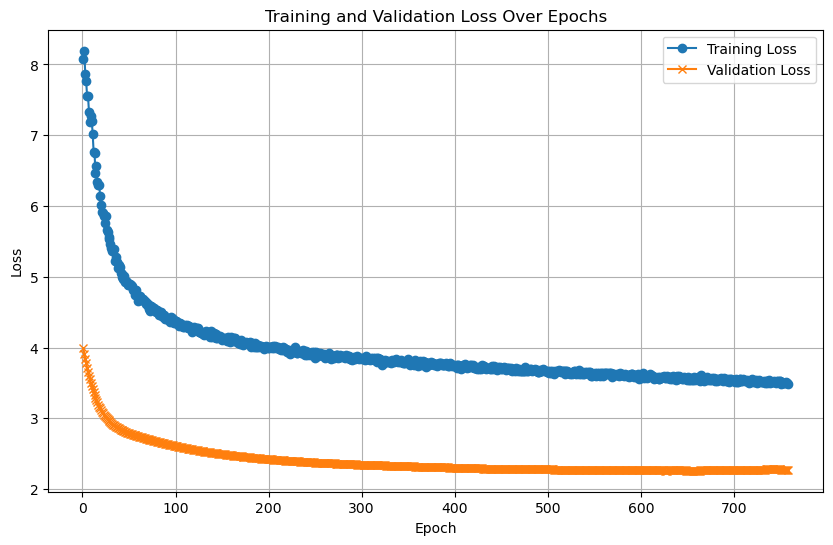

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/166], Loss: 6.2865
Test Batch [20/166], Loss: 5.7956
Test Batch [30/166], Loss: 5.6614
Test Batch [40/166], Loss: 5.9706
Test Batch [50/166], Loss: 5.5646
Test Batch [60/166], Loss: 5.9366
Test Batch [70/166], Loss: 5.9710


Test Batch [80/166], Loss: 5.4410
Test Batch [90/166], Loss: 5.8277
Test Batch [100/166], Loss: 5.9084
Test Batch [110/166], Loss: 5.4883
Test Batch [120/166], Loss: 5.3841
Test Batch [130/166], Loss: 5.3508
Test Batch [140/166], Loss: 5.7457
Test Batch [150/166], Loss: 5.3857
Test Batch [160/166], Loss: 6.6713

Test Loss: 5.7338


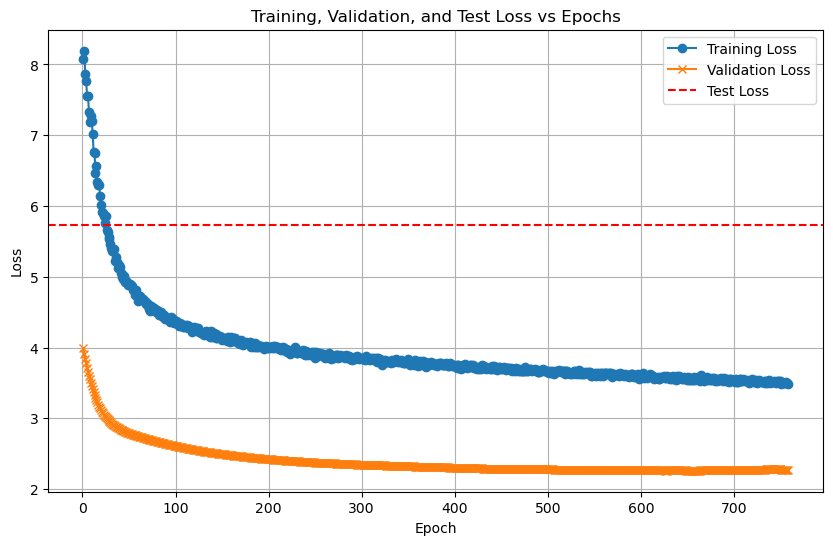

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.


  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.
  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.


  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.
  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.57      0.80      0.67         5
           2       1.00      0.60      0.75         5
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       0.57      0.80      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.86      0.82      0.83        45
weighted avg       0.86      0.82      0.83        45


LOG: Evaluating on the test set...
Test Accuracy: 76.17%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3188  |  Val Loss: 2.2667
Validation loss improved from inf to 2.2667.
[Epoch 2/1000] Train Loss: 2.2262  |  Val Loss: 2.1867
Validation loss improved from 2.2667 to 2.1867.
[Epoch 3/1000] Train Loss: 2.1478  |  Val Loss: 2.1122
Validation loss improved from 2.1867 to 2.1122.
[Epoch 4/1000] Train Loss: 2.0777  |  Val Loss: 2.0415
Validation loss improved from 2.1122 to 2.0415.
[Epoch 5/1000] Train Loss: 2.0095  |  Val Loss: 1.9792
Validation loss improved from 2.0415 to 1.9792.
[Epoch 6/1000] Train Loss: 1.9500  |  Val Loss: 1.9218
Validation loss improved from 1.9792 to 1.9218.
[Epoch 7/1000] Train Loss: 1.8975  |  Val Loss: 1.8691
Validation loss improved from 1.9218 to 1.8691.
[Epoch 8/1000] Train Loss: 1.8468  |  Val Loss: 1.8243
Validation loss improved from 1.8691 to 1.8243.
[Epoch 9/1000] Train Loss: 1.8042  |  Val Loss: 1.7842
Validation loss improved from 1.8243 to 1.7842.
[Epoch 10/1000] Train Loss: 1.7639  |  Val Loss: 1.7477
Validation loss impr

[Epoch 15/1000] Train Loss: 1.5987  |  Val Loss: 1.6017
Validation loss improved from 1.6270 to 1.6017.


[Epoch 16/1000] Train Loss: 1.5721  |  Val Loss: 1.5774
Validation loss improved from 1.6017 to 1.5774.
[Epoch 17/1000] Train Loss: 1.5470  |  Val Loss: 1.5537
Validation loss improved from 1.5774 to 1.5537.
[Epoch 18/1000] Train Loss: 1.5226  |  Val Loss: 1.5323
Validation loss improved from 1.5537 to 1.5323.
[Epoch 19/1000] Train Loss: 1.4998  |  Val Loss: 1.5116
Validation loss improved from 1.5323 to 1.5116.
[Epoch 20/1000] Train Loss: 1.4777  |  Val Loss: 1.4923
Validation loss improved from 1.5116 to 1.4923.
[Epoch 21/1000] Train Loss: 1.4568  |  Val Loss: 1.4730
Validation loss improved from 1.4923 to 1.4730.
[Epoch 22/1000] Train Loss: 1.4365  |  Val Loss: 1.4559
Validation loss improved from 1.4730 to 1.4559.
[Epoch 23/1000] Train Loss: 1.4168  |  Val Loss: 1.4384
Validation loss improved from 1.4559 to 1.4384.
[Epoch 24/1000] Train Loss: 1.3970  |  Val Loss: 1.4214
Validation loss improved from 1.4384 to 1.4214.
[Epoch 25/1000] Train Loss: 1.3784  |  Val Loss: 1.4044
Validati

[Epoch 33/1000] Train Loss: 1.2329  |  Val Loss: 1.2867
Validation loss improved from 1.3005 to 1.2867.
[Epoch 34/1000] Train Loss: 1.2161  |  Val Loss: 1.2724
Validation loss improved from 1.2867 to 1.2724.
[Epoch 35/1000] Train Loss: 1.2004  |  Val Loss: 1.2586
Validation loss improved from 1.2724 to 1.2586.
[Epoch 36/1000] Train Loss: 1.1854  |  Val Loss: 1.2454
Validation loss improved from 1.2586 to 1.2454.
[Epoch 37/1000] Train Loss: 1.1706  |  Val Loss: 1.2332
Validation loss improved from 1.2454 to 1.2332.
[Epoch 38/1000] Train Loss: 1.1561  |  Val Loss: 1.2194
Validation loss improved from 1.2332 to 1.2194.
[Epoch 39/1000] Train Loss: 1.1417  |  Val Loss: 1.2077
Validation loss improved from 1.2194 to 1.2077.
[Epoch 40/1000] Train Loss: 1.1280  |  Val Loss: 1.1954
Validation loss improved from 1.2077 to 1.1954.
[Epoch 41/1000] Train Loss: 1.1134  |  Val Loss: 1.1813
Validation loss improved from 1.1954 to 1.1813.
[Epoch 42/1000] Train Loss: 1.0994  |  Val Loss: 1.1692
Validati

[Epoch 49/1000] Train Loss: 1.0018  |  Val Loss: 1.0832
Validation loss improved from 1.0936 to 1.0832.
[Epoch 50/1000] Train Loss: 0.9885  |  Val Loss: 1.0716
Validation loss improved from 1.0832 to 1.0716.
[Epoch 51/1000] Train Loss: 0.9748  |  Val Loss: 1.0609
Validation loss improved from 1.0716 to 1.0609.
[Epoch 52/1000] Train Loss: 0.9616  |  Val Loss: 1.0494
Validation loss improved from 1.0609 to 1.0494.
[Epoch 53/1000] Train Loss: 0.9483  |  Val Loss: 1.0362
Validation loss improved from 1.0494 to 1.0362.
[Epoch 54/1000] Train Loss: 0.9342  |  Val Loss: 1.0238
Validation loss improved from 1.0362 to 1.0238.
[Epoch 55/1000] Train Loss: 0.9204  |  Val Loss: 1.0104
Validation loss improved from 1.0238 to 1.0104.
[Epoch 56/1000] Train Loss: 0.9070  |  Val Loss: 0.9973
Validation loss improved from 1.0104 to 0.9973.
[Epoch 57/1000] Train Loss: 0.8933  |  Val Loss: 0.9850
Validation loss improved from 0.9973 to 0.9850.
[Epoch 58/1000] Train Loss: 0.8802  |  Val Loss: 0.9724
Validati

[Epoch 66/1000] Train Loss: 0.7757  |  Val Loss: 0.8765
Validation loss improved from 0.8887 to 0.8765.
[Epoch 67/1000] Train Loss: 0.7631  |  Val Loss: 0.8640
Validation loss improved from 0.8765 to 0.8640.
[Epoch 68/1000] Train Loss: 0.7504  |  Val Loss: 0.8539
Validation loss improved from 0.8640 to 0.8539.
[Epoch 69/1000] Train Loss: 0.7379  |  Val Loss: 0.8446
Validation loss improved from 0.8539 to 0.8446.
[Epoch 70/1000] Train Loss: 0.7247  |  Val Loss: 0.8325
Validation loss improved from 0.8446 to 0.8325.
[Epoch 71/1000] Train Loss: 0.7120  |  Val Loss: 0.8188
Validation loss improved from 0.8325 to 0.8188.
[Epoch 72/1000] Train Loss: 0.6995  |  Val Loss: 0.8052
Validation loss improved from 0.8188 to 0.8052.
[Epoch 73/1000] Train Loss: 0.6867  |  Val Loss: 0.7918
Validation loss improved from 0.8052 to 0.7918.
[Epoch 74/1000] Train Loss: 0.6741  |  Val Loss: 0.7797
Validation loss improved from 0.7918 to 0.7797.
[Epoch 75/1000] Train Loss: 0.6613  |  Val Loss: 0.7725
Validati

[Epoch 84/1000] Train Loss: 0.5556  |  Val Loss: 0.6723
Validation loss improved from 0.6812 to 0.6723.
[Epoch 85/1000] Train Loss: 0.5448  |  Val Loss: 0.6637
Validation loss improved from 0.6723 to 0.6637.
[Epoch 86/1000] Train Loss: 0.5347  |  Val Loss: 0.6552
Validation loss improved from 0.6637 to 0.6552.
[Epoch 87/1000] Train Loss: 0.5249  |  Val Loss: 0.6458
Validation loss improved from 0.6552 to 0.6458.
[Epoch 88/1000] Train Loss: 0.5153  |  Val Loss: 0.6376
Validation loss improved from 0.6458 to 0.6376.
[Epoch 89/1000] Train Loss: 0.5057  |  Val Loss: 0.6280
Validation loss improved from 0.6376 to 0.6280.
[Epoch 90/1000] Train Loss: 0.4964  |  Val Loss: 0.6197
Validation loss improved from 0.6280 to 0.6197.
[Epoch 91/1000] Train Loss: 0.4878  |  Val Loss: 0.6138
Validation loss improved from 0.6197 to 0.6138.
[Epoch 92/1000] Train Loss: 0.4792  |  Val Loss: 0.6049
Validation loss improved from 0.6138 to 0.6049.
[Epoch 93/1000] Train Loss: 0.4708  |  Val Loss: 0.5960
Validati

[Epoch 102/1000] Train Loss: 0.4067  |  Val Loss: 0.5403
Validation loss improved from 0.5448 to 0.5403.
[Epoch 103/1000] Train Loss: 0.4009  |  Val Loss: 0.5333
Validation loss improved from 0.5403 to 0.5333.
[Epoch 104/1000] Train Loss: 0.3955  |  Val Loss: 0.5280
Validation loss improved from 0.5333 to 0.5280.
[Epoch 105/1000] Train Loss: 0.3895  |  Val Loss: 0.5256
Validation loss improved from 0.5280 to 0.5256.
[Epoch 106/1000] Train Loss: 0.3843  |  Val Loss: 0.5227
Validation loss improved from 0.5256 to 0.5227.
[Epoch 107/1000] Train Loss: 0.3792  |  Val Loss: 0.5182
Validation loss improved from 0.5227 to 0.5182.
[Epoch 108/1000] Train Loss: 0.3742  |  Val Loss: 0.5161
Validation loss improved from 0.5182 to 0.5161.
[Epoch 109/1000] Train Loss: 0.3693  |  Val Loss: 0.5149
Validation loss improved from 0.5161 to 0.5149.
[Epoch 110/1000] Train Loss: 0.3650  |  Val Loss: 0.5045
Validation loss improved from 0.5149 to 0.5045.
[Epoch 111/1000] Train Loss: 0.3600  |  Val Loss: 0.498

[Epoch 120/1000] Train Loss: 0.3260  |  Val Loss: 0.4755
Validation loss improved from 0.4808 to 0.4755.
[Epoch 121/1000] Train Loss: 0.3220  |  Val Loss: 0.4747
Validation loss improved from 0.4755 to 0.4747.
[Epoch 122/1000] Train Loss: 0.3184  |  Val Loss: 0.4723
Validation loss improved from 0.4747 to 0.4723.
[Epoch 123/1000] Train Loss: 0.3154  |  Val Loss: 0.4688
Validation loss improved from 0.4723 to 0.4688.
[Epoch 124/1000] Train Loss: 0.3122  |  Val Loss: 0.4661
Validation loss improved from 0.4688 to 0.4661.
[Epoch 125/1000] Train Loss: 0.3093  |  Val Loss: 0.4619
Validation loss improved from 0.4661 to 0.4619.
[Epoch 126/1000] Train Loss: 0.3062  |  Val Loss: 0.4617
Validation loss improved from 0.4619 to 0.4617.
[Epoch 127/1000] Train Loss: 0.3036  |  Val Loss: 0.4621
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.3013  |  Val Loss: 0.4639
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 0.2980  |  Val

[Epoch 138/1000] Train Loss: 0.2770  |  Val Loss: 0.4391
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 139/1000] Train Loss: 0.2755  |  Val Loss: 0.4403
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 140/1000] Train Loss: 0.2732  |  Val Loss: 0.4385
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 141/1000] Train Loss: 0.2710  |  Val Loss: 0.4401
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 142/1000] Train Loss: 0.2691  |  Val Loss: 0.4376
Validation loss improved from 0.4378 to 0.4376.
[Epoch 143/1000] Train Loss: 0.2678  |  Val Loss: 0.4343
Validation loss improved from 0.4376 to 0.4343.
[Epoch 144/1000] Train Loss: 0.2656  |  Val Loss: 0.4367
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 0.2638  |  Val Loss: 0.4391
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 146/1000] Train Loss: 0.2621  |  Val Loss: 0.4373
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 147/10

[Epoch 155/1000] Train Loss: 0.2483  |  Val Loss: 0.4276
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 0.2471  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 0.2459  |  Val Loss: 0.4247
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 158/1000] Train Loss: 0.2446  |  Val Loss: 0.4254
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 159/1000] Train Loss: 0.2432  |  Val Loss: 0.4247
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 160/1000] Train Loss: 0.2417  |  Val Loss: 0.4234
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 161/1000] Train Loss: 0.2410  |  Val Loss: 0.4246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 162/1000] Train Loss: 0.2392  |  Val Loss: 0.4230
Validation loss improved from 0.4233 to 0.4230.
[Epoch 163/1000] Train Loss: 0.2383  |  Val Loss: 0.4214
Validation loss improved from 0.4230 to 0.4214.
[Epoch 164/10

[Epoch 172/1000] Train Loss: 0.2289  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 173/1000] Train Loss: 0.2281  |  Val Loss: 0.4242
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 174/1000] Train Loss: 0.2266  |  Val Loss: 0.4258
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 175/1000] Train Loss: 0.2260  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 176/1000] Train Loss: 0.2246  |  Val Loss: 0.4243
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 177/1000] Train Loss: 0.2237  |  Val Loss: 0.4161
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 178/1000] Train Loss: 0.2227  |  Val Loss: 0.4181
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 179/1000] Train Loss: 0.2227  |  Val Loss: 0.4207
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 180/1000] Train Loss: 0.2211  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 189/1000] Train Loss: 0.2135  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 190/1000] Train Loss: 0.2127  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 191/1000] Train Loss: 0.2116  |  Val Loss: 0.4185
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 192/1000] Train Loss: 0.2114  |  Val Loss: 0.4201
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 193/1000] Train Loss: 0.2103  |  Val Loss: 0.4206
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 194/1000] Train Loss: 0.2096  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 195/1000] Train Loss: 0.2090  |  Val Loss: 0.4258
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 196/1000] Train Loss: 0.2081  |  Val Loss: 0.4261
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 197/1000] Train Loss: 0.2079  |  Val Loss: 0.4209
!! Validation loss did NOT improve !! Patience:

[Epoch 208/1000] Train Loss: 0.2004  |  Val Loss: 0.4252
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 209/1000] Train Loss: 0.2003  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 210/1000] Train Loss: 0.1995  |  Val Loss: 0.4239
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 211/1000] Train Loss: 0.1987  |  Val Loss: 0.4247
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 212/1000] Train Loss: 0.1979  |  Val Loss: 0.4261
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 213/1000] Train Loss: 0.1977  |  Val Loss: 0.4276
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 214/1000] Train Loss: 0.1968  |  Val Loss: 0.4285
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 215/1000] Train Loss: 0.1962  |  Val Loss: 0.4275
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 216/1000] Train Loss: 0.1959  |  Val Loss: 0.4263
!! Validation loss did NOT improve !! Patience:

[Epoch 226/1000] Train Loss: 0.1903  |  Val Loss: 0.4291
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 227/1000] Train Loss: 0.1901  |  Val Loss: 0.4303
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 228/1000] Train Loss: 0.1896  |  Val Loss: 0.4308
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 229/1000] Train Loss: 0.1891  |  Val Loss: 0.4321
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 230/1000] Train Loss: 0.1883  |  Val Loss: 0.4377
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 231/1000] Train Loss: 0.1877  |  Val Loss: 0.4344
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 232/1000] Train Loss: 0.1877  |  Val Loss: 0.4361
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 233/1000] Train Loss: 0.1872  |  Val Loss: 0.4363
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 234/1000] Train Loss: 0.1866  |  Val Loss: 0.4393
!! Validation loss did NOT improve !! Patience:

[Epoch 242/1000] Train Loss: 0.1829  |  Val Loss: 0.4391
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 243/1000] Train Loss: 0.1824  |  Val Loss: 0.4384
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 244/1000] Train Loss: 0.1823  |  Val Loss: 0.4384
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 245/1000] Train Loss: 0.1815  |  Val Loss: 0.4416
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 246/1000] Train Loss: 0.1818  |  Val Loss: 0.4466
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 247/1000] Train Loss: 0.1807  |  Val Loss: 0.4469
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 248/1000] Train Loss: 0.1806  |  Val Loss: 0.4475
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 249/1000] Train Loss: 0.1799  |  Val Loss: 0.4454
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 250/1000] Train Loss: 0.1793  |  Val Loss: 0.4443
!! Validation loss did NOT improve !! Patience:

[Epoch 259/1000] Train Loss: 0.1761  |  Val Loss: 0.4565
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 260/1000] Train Loss: 0.1762  |  Val Loss: 0.4537
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 261/1000] Train Loss: 0.1754  |  Val Loss: 0.4577
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 262/1000] Train Loss: 0.1748  |  Val Loss: 0.4575
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 263/1000] Train Loss: 0.1746  |  Val Loss: 0.4574
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 264/1000] Train Loss: 0.1744  |  Val Loss: 0.4589
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 265/1000] Train Loss: 0.1737  |  Val Loss: 0.4557
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 266/1000] Train Loss: 0.1734  |  Val Loss: 0.4562
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 267/1000] Train Loss: 0.1733  |  Val Loss: 0.4586
!! Validation loss did NOT improve !! Patience:

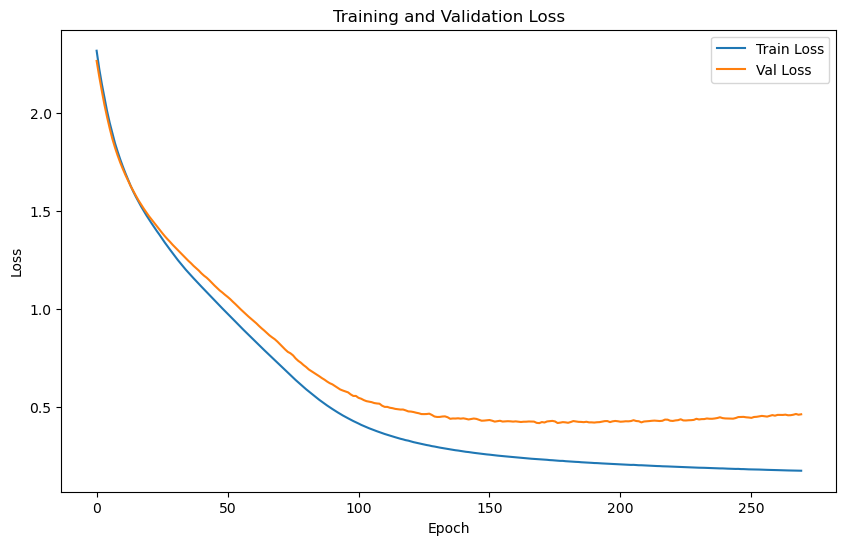

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0416 | Test Accuracy: 73.86%


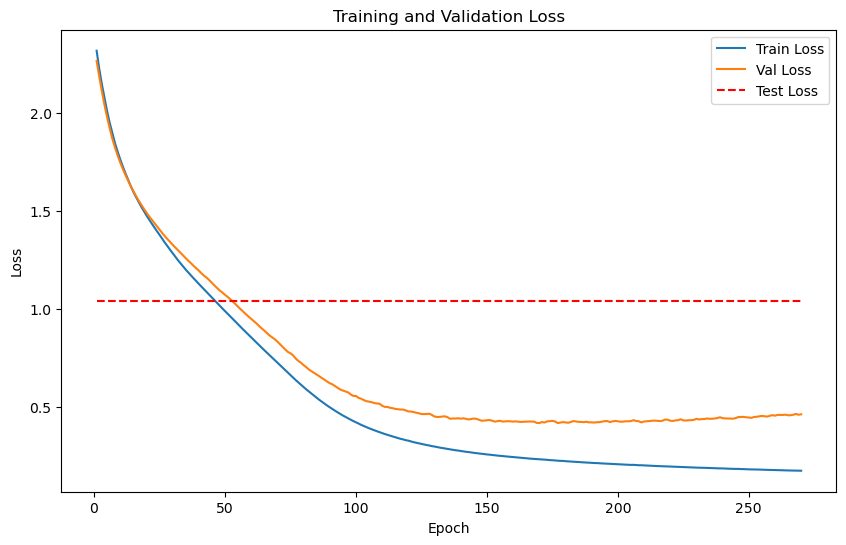

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4651


    Batch [2/2], Train Loss: 0.4625
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4181
Epoch [1/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4181

Validation loss improved from inf to 0.4181. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4637


    Batch [2/2], Train Loss: 0.4600
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4129
Epoch [2/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4129

Validation loss improved from 0.4181 to 0.4129. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4625
    Batch [2/2], Train Loss: 0.4558
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4094
Epoch [3/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4094

Validation loss improved from 0.4129 to 0.4094. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4566


    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4082
Epoch [4/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4082

Validation loss improved from 0.4094 to 0.4082. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4529
    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4058
Epoch [5/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4058

Validation loss improved from 0.4082 to 0.4058. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4550


    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4017
Epoch [6/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4017

Validation loss improved from 0.4058 to 0.4017. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4552


    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3983
Epoch [7/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3983

Validation loss improved from 0.4017 to 0.3983. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4467
    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [8/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.3951

Validation loss improved from 0.3983 to 0.3951. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [9/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3932

Validation loss improved from 0.3951 to 0.3932. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4435


    Batch [2/2], Train Loss: 0.4352
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [10/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3918

Validation loss improved from 0.3932 to 0.3918. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4429
    Batch [2/2], Train Loss: 0.4397
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [11/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3905

Validation loss improved from 0.3918 to 0.3905. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.4372
    Batch [2/2], Train Loss: 0.4427
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3895
Epoch [12/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3895

Validation loss improved from 0.3905 to 0.3895. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4439
    Batch [2/2], Train Loss: 0.4390
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [13/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3883

Validation loss improved from 0.3895 to 0.3883. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4317


    Batch [2/2], Train Loss: 0.4376
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [14/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3870

Validation loss improved from 0.3883 to 0.3870. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.3855
Epoch [15/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3855

Validation loss improved from 0.3870 to 0.3855. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4280
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [16/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3843

Validation loss improved from 0.3855 to 0.3843. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4295
    Batch [2/2], Train Loss: 0.4304
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3829
Epoch [17/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3829

Validation loss improved from 0.3843 to 0.3829. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4282


    Batch [2/2], Train Loss: 0.4286
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [18/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3817

Validation loss improved from 0.3829 to 0.3817. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4315
    Batch [2/2], Train Loss: 0.4253
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [19/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.3804

Validation loss improved from 0.3817 to 0.3804. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4259
    Batch [2/2], Train Loss: 0.4217
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3791
Epoch [20/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.3791

Validation loss improved from 0.3804 to 0.3791. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4208


    Batch [2/2], Train Loss: 0.4235
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [21/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3777

Validation loss improved from 0.3791 to 0.3777. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4268
    Batch [2/2], Train Loss: 0.4210
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [22/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3763

Validation loss improved from 0.3777 to 0.3763. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4241
    Batch [2/2], Train Loss: 0.4215
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [23/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3749

Validation loss improved from 0.3763 to 0.3749. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4177


    Batch [2/2], Train Loss: 0.4139
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3736
Epoch [24/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3736

Validation loss improved from 0.3749 to 0.3736. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4156
    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3722
Epoch [25/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3722

Validation loss improved from 0.3736 to 0.3722. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4154
    Batch [2/2], Train Loss: 0.4142
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3710
Epoch [26/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3710

Validation loss improved from 0.3722 to 0.3710. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4153
    Batch [2/2], Train Loss: 0.4159
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [27/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3698

Validation loss improved from 0.3710 to 0.3698. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4076


    Batch [2/2], Train Loss: 0.4166
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3688
Epoch [28/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3688

Validation loss improved from 0.3698 to 0.3688. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4116
    Batch [2/2], Train Loss: 0.4150
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [29/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3677

Validation loss improved from 0.3688 to 0.3677. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.4114
    Batch [2/2], Train Loss: 0.4137
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [30/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3665

Validation loss improved from 0.3677 to 0.3665. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4018


    Batch [2/2], Train Loss: 0.4118
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [31/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3653

Validation loss improved from 0.3665 to 0.3653. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.4089
    Batch [2/2], Train Loss: 0.4098
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3640
Epoch [32/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3640

Validation loss improved from 0.3653 to 0.3640. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4116
    Batch [2/2], Train Loss: 0.4053
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [33/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3631

Validation loss improved from 0.3640 to 0.3631. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.3994
    Batch [2/2], Train Loss: 0.3993
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [34/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3622

Validation loss improved from 0.3631 to 0.3622. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.4056


    Batch [2/2], Train Loss: 0.4084
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [35/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3611

Validation loss improved from 0.3622 to 0.3611. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4098
    Batch [2/2], Train Loss: 0.4013
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [36/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3600

Validation loss improved from 0.3611 to 0.3600. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4005
    Batch [2/2], Train Loss: 0.4074
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [37/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3589

Validation loss improved from 0.3600 to 0.3589. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4055


    Batch [2/2], Train Loss: 0.4015
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [38/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3581

Validation loss improved from 0.3589 to 0.3581. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.3979
    Batch [2/2], Train Loss: 0.4055
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3571
Epoch [39/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3571

Validation loss improved from 0.3581 to 0.3571. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.3948
    Batch [2/2], Train Loss: 0.3985
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [40/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3561

Validation loss improved from 0.3571 to 0.3561. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4007
    Batch [2/2], Train Loss: 0.3971
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [41/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3551

Validation loss improved from 0.3561 to 0.3551. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4068


    Batch [2/2], Train Loss: 0.4019
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [42/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3542

Validation loss improved from 0.3551 to 0.3542. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.3954
    Batch [2/2], Train Loss: 0.3966
LOG: Epoch [43/2000] - Validation


    Batch [1/1], Val Loss: 0.3533
Epoch [43/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3533

Validation loss improved from 0.3542 to 0.3533. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.3933
    Batch [2/2], Train Loss: 0.3999
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3524
Epoch [44/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3524

Validation loss improved from 0.3533 to 0.3524. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.4008
    Batch [2/2], Train Loss: 0.4032
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3512
Epoch [45/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3512

Validation loss improved from 0.3524 to 0.3512. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.3881


    Batch [2/2], Train Loss: 0.3955
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [46/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3505

Validation loss improved from 0.3512 to 0.3505. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.3932


    Batch [2/2], Train Loss: 0.3855
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [47/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3498

Validation loss improved from 0.3505 to 0.3498. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3939
    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3489
Epoch [48/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3489

Validation loss improved from 0.3498 to 0.3489. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.3866
    Batch [2/2], Train Loss: 0.3845
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3479
Epoch [49/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3479

Validation loss improved from 0.3489 to 0.3479. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3889
    Batch [2/2], Train Loss: 0.3806
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [50/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.3473

Validation loss improved from 0.3479 to 0.3473. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.3868


    Batch [2/2], Train Loss: 0.3783
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3467
Epoch [51/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3467

Validation loss improved from 0.3473 to 0.3467. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3925
    Batch [2/2], Train Loss: 0.3867
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [52/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3464

Validation loss improved from 0.3467 to 0.3464. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.3867
    Batch [2/2], Train Loss: 0.3848
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [53/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3457

Validation loss improved from 0.3464 to 0.3457. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.3824


    Batch [2/2], Train Loss: 0.3859
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [54/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3452

Validation loss improved from 0.3457 to 0.3452. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3857
    Batch [2/2], Train Loss: 0.3854
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.3445
Epoch [55/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3445

Validation loss improved from 0.3452 to 0.3445. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3906
    Batch [2/2], Train Loss: 0.3795
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [56/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.3437

Validation loss improved from 0.3445 to 0.3437. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3874
    Batch [2/2], Train Loss: 0.3797
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3428
Epoch [57/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3428

Validation loss improved from 0.3437 to 0.3428. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.3844


    Batch [2/2], Train Loss: 0.3821
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [58/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3421

Validation loss improved from 0.3428 to 0.3421. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3825
    Batch [2/2], Train Loss: 0.3792
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.3413
Epoch [59/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.3413

Validation loss improved from 0.3421 to 0.3413. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3784
    Batch [2/2], Train Loss: 0.3871
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [60/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.3407

Validation loss improved from 0.3413 to 0.3407. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.3898
    Batch [2/2], Train Loss: 0.3777
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [61/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3399

Validation loss improved from 0.3407 to 0.3399. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3780
    Batch [2/2], Train Loss: 0.3779
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [62/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3395

Validation loss improved from 0.3399 to 0.3395. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3753


    Batch [2/2], Train Loss: 0.3754
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3389
Epoch [63/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3389

Validation loss improved from 0.3395 to 0.3389. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3674
    Batch [2/2], Train Loss: 0.3784
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [64/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3383

Validation loss improved from 0.3389 to 0.3383. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3801
    Batch [2/2], Train Loss: 0.3783
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [65/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3376

Validation loss improved from 0.3383 to 0.3376. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3700
    Batch [2/2], Train Loss: 0.3746
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [66/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3371

Validation loss improved from 0.3376 to 0.3371. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.3721


    Batch [2/2], Train Loss: 0.3725
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [67/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3364

Validation loss improved from 0.3371 to 0.3364. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3727
    Batch [2/2], Train Loss: 0.3690
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3357
Epoch [68/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3357

Validation loss improved from 0.3364 to 0.3357. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3698
    Batch [2/2], Train Loss: 0.3702
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [69/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3351

Validation loss improved from 0.3357 to 0.3351. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3741
    Batch [2/2], Train Loss: 0.3790
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [70/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3344

Validation loss improved from 0.3351 to 0.3344. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3748


    Batch [2/2], Train Loss: 0.3610
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [71/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3340

Validation loss improved from 0.3344 to 0.3340. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3718
    Batch [2/2], Train Loss: 0.3663
LOG: Epoch [72/2000] - Validation


    Batch [1/1], Val Loss: 0.3335
Epoch [72/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.3335

Validation loss improved from 0.3340 to 0.3335. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3589
    Batch [2/2], Train Loss: 0.3648
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [73/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3327

Validation loss improved from 0.3335 to 0.3327. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3692
    Batch [2/2], Train Loss: 0.3707
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [74/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3322

Validation loss improved from 0.3327 to 0.3322. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3645


    Batch [2/2], Train Loss: 0.3600
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [75/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3318

Validation loss improved from 0.3322 to 0.3318. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3730
    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3309
Epoch [76/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3309

Validation loss improved from 0.3318 to 0.3309. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3619
    Batch [2/2], Train Loss: 0.3666
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [77/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3301

Validation loss improved from 0.3309 to 0.3301. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3730


    Batch [2/2], Train Loss: 0.3643
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [78/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3294

Validation loss improved from 0.3301 to 0.3294. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3613
    Batch [2/2], Train Loss: 0.3640
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [79/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3291

Validation loss improved from 0.3294 to 0.3291. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3609
    Batch [2/2], Train Loss: 0.3642
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3282
Epoch [80/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.3282

Validation loss improved from 0.3291 to 0.3282. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3524


    Batch [2/2], Train Loss: 0.3511
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3276
Epoch [81/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3276

Validation loss improved from 0.3282 to 0.3276. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3634
    Batch [2/2], Train Loss: 0.3487
LOG: Epoch [82/2000] - Validation


    Batch [1/1], Val Loss: 0.3271
Epoch [82/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3271

Validation loss improved from 0.3276 to 0.3271. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3571
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [83/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3264

Validation loss improved from 0.3271 to 0.3264. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3614
    Batch [2/2], Train Loss: 0.3590
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3258
Epoch [84/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3258

Validation loss improved from 0.3264 to 0.3258. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3686


    Batch [2/2], Train Loss: 0.3573
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [85/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3253

Validation loss improved from 0.3258 to 0.3253. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3576
    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3247
Epoch [86/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3247

Validation loss improved from 0.3253 to 0.3247. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3549
    Batch [2/2], Train Loss: 0.3544
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3242
Epoch [87/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3242

Validation loss improved from 0.3247 to 0.3242. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3513
    Batch [2/2], Train Loss: 0.3527
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [88/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.3235

Validation loss improved from 0.3242 to 0.3235. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3653


    Batch [2/2], Train Loss: 0.3440
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [89/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3227

Validation loss improved from 0.3235 to 0.3227. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3558
    Batch [2/2], Train Loss: 0.3467
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.3223
Epoch [90/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3223

Validation loss improved from 0.3227 to 0.3223. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3527
    Batch [2/2], Train Loss: 0.3451
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [91/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3217

Validation loss improved from 0.3223 to 0.3217. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3534
    Batch [2/2], Train Loss: 0.3608
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [92/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3214

Validation loss improved from 0.3217 to 0.3214. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3498


    Batch [2/2], Train Loss: 0.3512
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [93/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3207

Validation loss improved from 0.3214 to 0.3207. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3549
    Batch [2/2], Train Loss: 0.3544
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [94/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3201

Validation loss improved from 0.3207 to 0.3201. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3487
    Batch [2/2], Train Loss: 0.3514
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [95/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3197

Validation loss improved from 0.3201 to 0.3197. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3442


    Batch [2/2], Train Loss: 0.3576
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [96/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3193

Validation loss improved from 0.3197 to 0.3193. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3383
    Batch [2/2], Train Loss: 0.3526
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3186
Epoch [97/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3186

Validation loss improved from 0.3193 to 0.3186. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3366
    Batch [2/2], Train Loss: 0.3449
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [98/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3180

Validation loss improved from 0.3186 to 0.3180. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3450
    Batch [2/2], Train Loss: 0.3372
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [99/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3173

Validation loss improved from 0.3180 to 0.3173. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3437


    Batch [2/2], Train Loss: 0.3426
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [100/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3165

Validation loss improved from 0.3173 to 0.3165. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3422
    Batch [2/2], Train Loss: 0.3379
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3159
Epoch [101/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3159

Validation loss improved from 0.3165 to 0.3159. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3465
    Batch [2/2], Train Loss: 0.3436
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3153
Epoch [102/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.3153

Validation loss improved from 0.3159 to 0.3153. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3350
    Batch [2/2], Train Loss: 0.3408
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [103/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3149

Validation loss improved from 0.3153 to 0.3149. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3420


    Batch [2/2], Train Loss: 0.3466
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [104/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3145

Validation loss improved from 0.3149 to 0.3145. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3356
    Batch [2/2], Train Loss: 0.3431
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [105/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3141

Validation loss improved from 0.3145 to 0.3141. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.3375
    Batch [2/2], Train Loss: 0.3461
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [106/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3136

Validation loss improved from 0.3141 to 0.3136. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3336
    Batch [2/2], Train Loss: 0.3515
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3132
Epoch [107/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3132

Validation loss improved from 0.3136 to 0.3132. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3339


    Batch [2/2], Train Loss: 0.3459
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [108/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.3129

Validation loss improved from 0.3132 to 0.3129. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.3295
    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.3125
Epoch [109/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3125

Validation loss improved from 0.3129 to 0.3125. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3361
    Batch [2/2], Train Loss: 0.3343
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [110/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.3121

Validation loss improved from 0.3125 to 0.3121. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3416
    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3115
Epoch [111/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3115

Validation loss improved from 0.3121 to 0.3115. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3458


    Batch [2/2], Train Loss: 0.3394
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [112/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3109

Validation loss improved from 0.3115 to 0.3109. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3437


    Batch [2/2], Train Loss: 0.3385
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [113/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3103

Validation loss improved from 0.3109 to 0.3103. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3387
    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [114/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.3328
    Batch [2/2], Train Loss: 0.3344
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [115/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3094

Validation loss improved from 0.3099 to 0.3094. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3381
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [116/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3090

Validation loss improved from 0.3094 to 0.3090. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3360
    Batch [2/2], Train Loss: 0.3315
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [117/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3086

Validation loss improved from 0.3090 to 0.3086. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.3325
    Batch [2/2], Train Loss: 0.3332
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [118/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.3081

Validation loss improved from 0.3086 to 0.3081. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.3339


    Batch [2/2], Train Loss: 0.3402
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [119/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3076

Validation loss improved from 0.3081 to 0.3076. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3330
    Batch [2/2], Train Loss: 0.3419
LOG: Epoch [120/2000] - Validation


    Batch [1/1], Val Loss: 0.3070
Epoch [120/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.3070

Validation loss improved from 0.3076 to 0.3070. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3347
    Batch [2/2], Train Loss: 0.3348
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [121/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.3064

Validation loss improved from 0.3070 to 0.3064. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3282
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [122/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3060

Validation loss improved from 0.3064 to 0.3060. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.3264


    Batch [2/2], Train Loss: 0.3265
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [123/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3054

Validation loss improved from 0.3060 to 0.3054. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3305
    Batch [2/2], Train Loss: 0.3231
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [124/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3052

Validation loss improved from 0.3054 to 0.3052. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.3332
    Batch [2/2], Train Loss: 0.3188
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [125/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.3047

Validation loss improved from 0.3052 to 0.3047. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.3382


    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [126/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3042

Validation loss improved from 0.3047 to 0.3042. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3254
    Batch [2/2], Train Loss: 0.3276
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [127/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3037

Validation loss improved from 0.3042 to 0.3037. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.3287
    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [128/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3035

Validation loss improved from 0.3037 to 0.3035. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.3284


    Batch [2/2], Train Loss: 0.3266
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3032
Epoch [129/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3032

Validation loss improved from 0.3035 to 0.3032. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.3294


    Batch [2/2], Train Loss: 0.3359
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [130/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3028

Validation loss improved from 0.3032 to 0.3028. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3264
    Batch [2/2], Train Loss: 0.3330
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [131/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3023

Validation loss improved from 0.3028 to 0.3023. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.3234
    Batch [2/2], Train Loss: 0.3296
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3017
Epoch [132/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.3017

Validation loss improved from 0.3023 to 0.3017. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3196


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [133/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3013

Validation loss improved from 0.3017 to 0.3013. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.3217
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [134/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3007

Validation loss improved from 0.3013 to 0.3007. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.3310
    Batch [2/2], Train Loss: 0.3306
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [135/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3003

Validation loss improved from 0.3007 to 0.3003. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.3225


    Batch [2/2], Train Loss: 0.3243
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [136/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2997

Validation loss improved from 0.3003 to 0.2997. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3269
    Batch [2/2], Train Loss: 0.3192
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [137/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2993

Validation loss improved from 0.2997 to 0.2993. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.3135
    Batch [2/2], Train Loss: 0.3295
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [138/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.2989

Validation loss improved from 0.2993 to 0.2989. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.3327


    Batch [2/2], Train Loss: 0.3250
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [139/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2984

Validation loss improved from 0.2989 to 0.2984. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3159


    Batch [2/2], Train Loss: 0.3248
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2978
Epoch [140/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2978

Validation loss improved from 0.2984 to 0.2978. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.3200
    Batch [2/2], Train Loss: 0.3206
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [141/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2975

Validation loss improved from 0.2978 to 0.2975. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3312
    Batch [2/2], Train Loss: 0.3181
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2971
Epoch [142/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2971

Validation loss improved from 0.2975 to 0.2971. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3146


    Batch [2/2], Train Loss: 0.3220
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [143/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.3213
    Batch [2/2], Train Loss: 0.3197
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [144/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2966

Validation loss improved from 0.2969 to 0.2966. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3225
    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [145/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2960

Validation loss improved from 0.2966 to 0.2960. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.3200


    Batch [2/2], Train Loss: 0.3098
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [146/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2954

Validation loss improved from 0.2960 to 0.2954. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.3155
    Batch [2/2], Train Loss: 0.3114
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [147/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.2950

Validation loss improved from 0.2954 to 0.2950. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.3155
    Batch [2/2], Train Loss: 0.3073
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [148/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.2945

Validation loss improved from 0.2950 to 0.2945. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.3276


    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [149/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2941

Validation loss improved from 0.2945 to 0.2941. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3186
    Batch [2/2], Train Loss: 0.3150
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [150/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2936

Validation loss improved from 0.2941 to 0.2936. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3134
    Batch [2/2], Train Loss: 0.3240
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [151/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.2932

Validation loss improved from 0.2936 to 0.2932. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3293


    Batch [2/2], Train Loss: 0.3121
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [152/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2927

Validation loss improved from 0.2932 to 0.2927. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.3175
    Batch [2/2], Train Loss: 0.3120
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [153/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2923

Validation loss improved from 0.2927 to 0.2923. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3222
    Batch [2/2], Train Loss: 0.3124
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [154/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2920

Validation loss improved from 0.2923 to 0.2920. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3162


    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [155/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.2919

Validation loss improved from 0.2920 to 0.2919. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3091


    Batch [2/2], Train Loss: 0.3171
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [156/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2915

Validation loss improved from 0.2919 to 0.2915. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3122
    Batch [2/2], Train Loss: 0.3048
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [157/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2914

Validation loss improved from 0.2915 to 0.2914. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3029
    Batch [2/2], Train Loss: 0.3167
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [158/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2911

Validation loss improved from 0.2914 to 0.2911. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3004


    Batch [2/2], Train Loss: 0.3136
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [159/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2906

Validation loss improved from 0.2911 to 0.2906. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.3040
    Batch [2/2], Train Loss: 0.3021
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [160/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2903

Validation loss improved from 0.2906 to 0.2903. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.3040
    Batch [2/2], Train Loss: 0.3070
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [161/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2901

Validation loss improved from 0.2903 to 0.2901. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.3174


    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [162/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2900

Validation loss improved from 0.2901 to 0.2900. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3202
    Batch [2/2], Train Loss: 0.3022
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [163/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2896

Validation loss improved from 0.2900 to 0.2896. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.3159
    Batch [2/2], Train Loss: 0.3192
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [164/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3134


    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [165/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.2889

Validation loss improved from 0.2893 to 0.2889. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.2932
    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [166/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2883

Validation loss improved from 0.2889 to 0.2883. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3159
    Batch [2/2], Train Loss: 0.2946
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [167/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2879

Validation loss improved from 0.2883 to 0.2879. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3179


    Batch [2/2], Train Loss: 0.3014
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2876
Epoch [168/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2876

Validation loss improved from 0.2879 to 0.2876. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3133
    Batch [2/2], Train Loss: 0.3053
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.2875
Epoch [169/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2875

Validation loss improved from 0.2876 to 0.2875. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.2993
    Batch [2/2], Train Loss: 0.3011
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [170/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.3068
    Batch [2/2], Train Loss: 0.2992
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [171/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.2873

Validation loss improved from 0.2873 to 0.2873. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.3000


    Batch [2/2], Train Loss: 0.2993
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2872
Epoch [172/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2872

Validation loss improved from 0.2873 to 0.2872. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3119


    Batch [2/2], Train Loss: 0.2968
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2869
Epoch [173/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2869

Validation loss improved from 0.2872 to 0.2869. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3038
    Batch [2/2], Train Loss: 0.2916
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2866
Epoch [174/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.2866

Validation loss improved from 0.2869 to 0.2866. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.3027
    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2865
Epoch [175/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2865

Validation loss improved from 0.2866 to 0.2865. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2873


    Batch [2/2], Train Loss: 0.3049
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [176/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2864

Validation loss improved from 0.2865 to 0.2864. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.3099
    Batch [2/2], Train Loss: 0.2975
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2858


Epoch [177/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2858

Validation loss improved from 0.2864 to 0.2858. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.2914
    Batch [2/2], Train Loss: 0.3007
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [178/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2854

Validation loss improved from 0.2858 to 0.2854. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/2], Train Loss: 0.2933
    Batch [2/2], Train Loss: 0.3071
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2849
Epoch [179/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.2849

Validation loss improved from 0.2854 to 0.2849. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.3065


    Batch [2/2], Train Loss: 0.2985
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [180/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2844

Validation loss improved from 0.2849 to 0.2844. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3010
    Batch [2/2], Train Loss: 0.3014
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.2838
Epoch [181/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2838

Validation loss improved from 0.2844 to 0.2838. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2984
    Batch [2/2], Train Loss: 0.2917
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2833
Epoch [182/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2833

Validation loss improved from 0.2838 to 0.2833. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2966
    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [183/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2829

Validation loss improved from 0.2833 to 0.2829. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.2859


    Batch [2/2], Train Loss: 0.2909
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2823
Epoch [184/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2823

Validation loss improved from 0.2829 to 0.2823. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.2928
    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2821
Epoch [185/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2821

Validation loss improved from 0.2823 to 0.2821. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2890
    Batch [2/2], Train Loss: 0.2964
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [186/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.2817

Validation loss improved from 0.2821 to 0.2817. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2894
    Batch [2/2], Train Loss: 0.2929
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2815
Epoch [187/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.2815

Validation loss improved from 0.2817 to 0.2815. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.2942


    Batch [2/2], Train Loss: 0.2981
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [188/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2811

Validation loss improved from 0.2815 to 0.2811. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2876
    Batch [2/2], Train Loss: 0.2901
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [189/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2806

Validation loss improved from 0.2811 to 0.2806. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2907
    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2801
Epoch [190/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2801

Validation loss improved from 0.2806 to 0.2801. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2877
    Batch [2/2], Train Loss: 0.2992
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2798
Epoch [191/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.2798

Validation loss improved from 0.2801 to 0.2798. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.2896


    Batch [2/2], Train Loss: 0.2882
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2795
Epoch [192/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2795

Validation loss improved from 0.2798 to 0.2795. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.3040


    Batch [2/2], Train Loss: 0.2861
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [193/2000], Avg Train Loss: 0.2951, Avg Val Loss: 0.2792

Validation loss improved from 0.2795 to 0.2792. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2994


    Batch [2/2], Train Loss: 0.2940
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2793
Epoch [194/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2793

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.2963


    Batch [2/2], Train Loss: 0.2835
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [195/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2790

Validation loss improved from 0.2792 to 0.2790. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2909
    Batch [2/2], Train Loss: 0.2963
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [196/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2790

Validation loss improved from 0.2790 to 0.2790. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2993
    Batch [2/2], Train Loss: 0.2891
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [197/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2789

Validation loss improved from 0.2790 to 0.2789. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.2967


    Batch [2/2], Train Loss: 0.2978
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [198/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.2903
    Batch [2/2], Train Loss: 0.2856
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [199/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.2784

Validation loss improved from 0.2789 to 0.2784. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.2894
    Batch [2/2], Train Loss: 0.2983
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [200/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2782

Validation loss improved from 0.2784 to 0.2782. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.3108


    Batch [2/2], Train Loss: 0.2835
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [201/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2779

Validation loss improved from 0.2782 to 0.2779. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.2970
    Batch [2/2], Train Loss: 0.2967
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2778
Epoch [202/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2890
    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [203/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.2991


    Batch [2/2], Train Loss: 0.2839
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [204/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2776

Validation loss improved from 0.2777 to 0.2776. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2766


    Batch [2/2], Train Loss: 0.2912
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [205/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2773
    Batch [2/2], Train Loss: 0.2889
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.2776
Epoch [206/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2872
    Batch [2/2], Train Loss: 0.2884
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2775
Epoch [207/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.2831
    Batch [2/2], Train Loss: 0.3005
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [208/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2825


    Batch [2/2], Train Loss: 0.2787
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [209/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2771

Validation loss improved from 0.2774 to 0.2771. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.2949
    Batch [2/2], Train Loss: 0.2781
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2767
Epoch [210/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2767

Validation loss improved from 0.2771 to 0.2767. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2922
    Batch [2/2], Train Loss: 0.2867
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2765
Epoch [211/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2765

Validation loss improved from 0.2767 to 0.2765. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2805


    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [212/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2763

Validation loss improved from 0.2765 to 0.2763. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.2872
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.2763
Epoch [213/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.2805
    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [214/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.2797
    Batch [2/2], Train Loss: 0.2927
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [215/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2758

Validation loss improved from 0.2763 to 0.2758. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2879


    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [216/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2752

Validation loss improved from 0.2758 to 0.2752. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.2792
    Batch [2/2], Train Loss: 0.2878
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [217/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2748

Validation loss improved from 0.2752 to 0.2748. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2768
    Batch [2/2], Train Loss: 0.2713
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [218/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2743

Validation loss improved from 0.2748 to 0.2743. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2863


    Batch [2/2], Train Loss: 0.2803
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [219/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2740

Validation loss improved from 0.2743 to 0.2740. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2808
    Batch [2/2], Train Loss: 0.2847
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [220/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2701
    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [221/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2756


    Batch [2/2], Train Loss: 0.2982
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [222/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2737

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2853
    Batch [2/2], Train Loss: 0.2830
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [223/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2901
    Batch [2/2], Train Loss: 0.2838
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [224/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.2786


    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [225/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2731

Validation loss improved from 0.2734 to 0.2731. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2653
    Batch [2/2], Train Loss: 0.2742
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [226/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2729

Validation loss improved from 0.2731 to 0.2729. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.2694
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [227/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2915


    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [228/2000], Avg Train Loss: 0.2865, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2908
    Batch [2/2], Train Loss: 0.2863
LOG: Epoch [229/2000] - Validation


    Batch [1/1], Val Loss: 0.2731
Epoch [229/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2806
    Batch [2/2], Train Loss: 0.2628
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [230/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.2941
    Batch [2/2], Train Loss: 0.2839
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [231/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2840


    Batch [2/2], Train Loss: 0.2767
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [232/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2609
    Batch [2/2], Train Loss: 0.2774
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [233/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2750
    Batch [2/2], Train Loss: 0.2754
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [234/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2764


    Batch [2/2], Train Loss: 0.2744
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [235/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2706
    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.2730
Epoch [236/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2832
    Batch [2/2], Train Loss: 0.2651
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [237/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2751
    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [238/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2723

Validation loss improved from 0.2727 to 0.2723. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2800


    Batch [2/2], Train Loss: 0.2770
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [239/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2718

Validation loss improved from 0.2723 to 0.2718. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2773


    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [240/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2715

Validation loss improved from 0.2718 to 0.2715. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2742
    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [241/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2713

Validation loss improved from 0.2715 to 0.2713. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.2808
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [242/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2708

Validation loss improved from 0.2713 to 0.2708. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2635


    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [243/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.2723
    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [244/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2706

Validation loss improved from 0.2708 to 0.2706. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2615
    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [245/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2604


    Batch [2/2], Train Loss: 0.2696
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [246/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2636
    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2711
Epoch [247/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2767
    Batch [2/2], Train Loss: 0.2655
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [248/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2806
    Batch [2/2], Train Loss: 0.2881
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [249/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2708

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2730


    Batch [2/2], Train Loss: 0.2793
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [250/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2707

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2603
    Batch [2/2], Train Loss: 0.2789
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [251/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.2541
    Batch [2/2], Train Loss: 0.2747
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2703
Epoch [252/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2703

Validation loss improved from 0.2706 to 0.2703. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.2629


    Batch [2/2], Train Loss: 0.2756
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [253/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2700

Validation loss improved from 0.2703 to 0.2700. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2799
    Batch [2/2], Train Loss: 0.2568
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2695
Epoch [254/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2695

Validation loss improved from 0.2700 to 0.2695. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/2], Train Loss: 0.2572
    Batch [2/2], Train Loss: 0.2789
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [255/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2691

Validation loss improved from 0.2695 to 0.2691. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2796
    Batch [2/2], Train Loss: 0.2615
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2688
Epoch [256/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2688

Validation loss improved from 0.2691 to 0.2688. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2609


    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [257/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.2692
    Batch [2/2], Train Loss: 0.2697
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [258/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2676
    Batch [2/2], Train Loss: 0.2606
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [259/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.2756


    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [260/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2681

Validation loss improved from 0.2684 to 0.2681. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2748
    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2682
Epoch [261/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2682

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2612
    Batch [2/2], Train Loss: 0.2673
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [262/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.2679

Validation loss improved from 0.2681 to 0.2679. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2694


    Batch [2/2], Train Loss: 0.2770
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [263/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.2599
    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.2675
Epoch [264/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2675

Validation loss improved from 0.2677 to 0.2675. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2575
    Batch [2/2], Train Loss: 0.2570
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [265/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2672

Validation loss improved from 0.2675 to 0.2672. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.2667
    Batch [2/2], Train Loss: 0.2581
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [266/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2672

Validation loss improved from 0.2672 to 0.2672. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.2607


    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [267/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2677

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2624
    Batch [2/2], Train Loss: 0.2601
LOG: Epoch [268/2000] - Validation


    Batch [1/1], Val Loss: 0.2681
Epoch [268/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.2681

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2548
    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2678
Epoch [269/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2678

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2636
    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [270/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2613
    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [271/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2550


    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [272/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2674

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2621
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.2671
Epoch [273/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2484
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [274/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.2555
    Batch [2/2], Train Loss: 0.2632
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [275/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2672

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2622


    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [276/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2670

Validation loss improved from 0.2670 to 0.2670. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2554
    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [277/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.2667

Validation loss improved from 0.2670 to 0.2667. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2690
    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [278/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2661

Validation loss improved from 0.2667 to 0.2661. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2544


    Batch [2/2], Train Loss: 0.2683
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2656
Epoch [279/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2656

Validation loss improved from 0.2661 to 0.2656. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2686
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.2655
Epoch [280/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2573
    Batch [2/2], Train Loss: 0.2369
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2652
Epoch [281/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.2652

Validation loss improved from 0.2655 to 0.2652. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2644
    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [282/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2655


    Batch [2/2], Train Loss: 0.2521
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [283/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2651

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2609
    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [284/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2506
    Batch [2/2], Train Loss: 0.2486
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [285/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2557


    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [286/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2646

Validation loss improved from 0.2649 to 0.2646. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2450
    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [287/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2432
    Batch [2/2], Train Loss: 0.2427
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [288/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2640

Validation loss improved from 0.2644 to 0.2640. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [289/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.2497
    Batch [2/2], Train Loss: 0.2365
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [290/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.2635

Validation loss improved from 0.2639 to 0.2635. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.2525
    Batch [2/2], Train Loss: 0.2518
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [291/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2531


    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [292/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2635

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.2502
    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.2637
Epoch [293/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2637

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2602
    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [294/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2559
    Batch [2/2], Train Loss: 0.2605
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [295/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.2638

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2439


    Batch [2/2], Train Loss: 0.2316
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [296/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.2526


    Batch [2/2], Train Loss: 0.2629
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [297/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2543
    Batch [2/2], Train Loss: 0.2424
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.2632
Epoch [298/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2447
    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [299/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2629

Validation loss improved from 0.2632 to 0.2629. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2473
    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [300/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.2624

Validation loss improved from 0.2629 to 0.2624. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2694


    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [301/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2399
    Batch [2/2], Train Loss: 0.2501
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [302/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2539
    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [303/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2620

Validation loss improved from 0.2620 to 0.2620. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.2473


    Batch [2/2], Train Loss: 0.2400
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [304/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.2620

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2489
    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.2622
Epoch [305/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.2622

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2545
    Batch [2/2], Train Loss: 0.2412
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [306/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.2626

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2371
    Batch [2/2], Train Loss: 0.2523
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2628
Epoch [307/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.2424


    Batch [2/2], Train Loss: 0.2491
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [308/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2371
    Batch [2/2], Train Loss: 0.2455
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.2631
Epoch [309/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.2454
    Batch [2/2], Train Loss: 0.2411
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [310/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2634

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.2452
    Batch [2/2], Train Loss: 0.2442
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [311/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.2636

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.2495


    Batch [2/2], Train Loss: 0.2423
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [312/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.2635

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2489
    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.2632
Epoch [313/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.2632

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2592
    Batch [2/2], Train Loss: 0.2450
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [314/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2631

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2492
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2628
Epoch [315/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2628

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.2522


    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [316/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2624

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2558
    Batch [2/2], Train Loss: 0.2654
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [317/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.2615

Validation loss improved from 0.2620 to 0.2615. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.2580
    Batch [2/2], Train Loss: 0.2456
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [318/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.2610

Validation loss improved from 0.2615 to 0.2610. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.2427


    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [319/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2606

Validation loss improved from 0.2610 to 0.2606. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2547


    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [320/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2600

Validation loss improved from 0.2606 to 0.2600. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.2508
    Batch [2/2], Train Loss: 0.2324
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.2593
Epoch [321/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2593

Validation loss improved from 0.2600 to 0.2593. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.2453
    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [322/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2588

Validation loss improved from 0.2593 to 0.2588. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.2562
    Batch [2/2], Train Loss: 0.2400
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [323/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2586

Validation loss improved from 0.2588 to 0.2586. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [324/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.2579

Validation loss improved from 0.2586 to 0.2579. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2463
    Batch [2/2], Train Loss: 0.2413
LOG: Epoch [325/2000] - Validation


    Batch [1/1], Val Loss: 0.2581
Epoch [325/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.2461
    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [326/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training


    Batch [1/2], Train Loss: 0.2444
    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [327/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.2309


    Batch [2/2], Train Loss: 0.2377
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [328/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.2482
    Batch [2/2], Train Loss: 0.2443
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [329/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.2370
    Batch [2/2], Train Loss: 0.2309
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [330/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.2281
    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [331/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.2405


    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [332/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.2401
    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2588
Epoch [333/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2323
    Batch [2/2], Train Loss: 0.2474
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [334/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.2299
    Batch [2/2], Train Loss: 0.2361
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [335/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.2389


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [336/2000], Avg Train Loss: 0.2341, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.2408
    Batch [2/2], Train Loss: 0.2395
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2585
Epoch [337/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2585

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.2427
    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [338/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.2520


    Batch [2/2], Train Loss: 0.2445
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [339/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.2343
    Batch [2/2], Train Loss: 0.2284
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [340/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.2429
    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [341/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2586

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [342/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2312
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.2578
Epoch [343/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2354
    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.2576
Epoch [344/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2576

Validation loss improved from 0.2578 to 0.2576. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2256
    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [345/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [346/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.2361


    Batch [2/2], Train Loss: 0.2350
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [347/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.2350
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.2580
Epoch [348/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2580

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.2484
    Batch [2/2], Train Loss: 0.2288
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [349/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2583

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.2323
    Batch [2/2], Train Loss: 0.2364
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [350/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.2582

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [351/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.2292
    Batch [2/2], Train Loss: 0.2397
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.2584
Epoch [352/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2584

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2338
    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [353/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2581

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2195
    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [354/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2419
    Batch [2/2], Train Loss: 0.2328
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [355/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2304


    Batch [2/2], Train Loss: 0.2299
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [356/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.2242
    Batch [2/2], Train Loss: 0.2217
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [357/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2572

Validation loss improved from 0.2576 to 0.2572. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.2334
    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [358/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.2310


    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [359/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2565

Validation loss improved from 0.2571 to 0.2565. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2299
    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [360/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2554

Validation loss improved from 0.2565 to 0.2554. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.2242
    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [361/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2548

Validation loss improved from 0.2554 to 0.2548. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2263


    Batch [2/2], Train Loss: 0.2433
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [362/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2541

Validation loss improved from 0.2548 to 0.2541. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.2398
    Batch [2/2], Train Loss: 0.2325
LOG: Epoch [363/2000] - Validation


    Batch [1/1], Val Loss: 0.2540
Epoch [363/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2267
    Batch [2/2], Train Loss: 0.2274
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [364/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.2336
    Batch [2/2], Train Loss: 0.2172
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [365/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2541

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.2291


    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [366/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2542

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.2162
    Batch [2/2], Train Loss: 0.2334
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [367/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2315
    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [368/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2181


    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [369/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.2074
    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.2547
Epoch [370/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2547

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.2210
    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [371/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [372/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2550

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.2179


    Batch [2/2], Train Loss: 0.2237
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [373/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.2256
    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.2551
Epoch [374/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [375/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [376/2000] - Training


    Batch [1/2], Train Loss: 0.2274
    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [376/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.2246


    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [377/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.2170
    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [378/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2553

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2211
    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [379/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.2305


    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2556
Epoch [380/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.2556

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2211


    Batch [2/2], Train Loss: 0.2162
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [381/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.2150
    Batch [2/2], Train Loss: 0.2336
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [382/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2548

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.2217
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [383/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2549

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [384/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2546

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.2142
    Batch [2/2], Train Loss: 0.2211
LOG: Epoch [385/2000] - Validation


    Batch [1/1], Val Loss: 0.2540
Epoch [385/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2540

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.2242
    Batch [2/2], Train Loss: 0.2186
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [386/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.2533

Validation loss improved from 0.2539 to 0.2533. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.2309
    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [387/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.2522

Validation loss improved from 0.2533 to 0.2522. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2111


    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [388/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.2517

Validation loss improved from 0.2522 to 0.2517. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [389/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2512

Validation loss improved from 0.2517 to 0.2512. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.2090
    Batch [2/2], Train Loss: 0.2046
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2510
Epoch [390/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2510

Validation loss improved from 0.2512 to 0.2510. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.2222


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2510
Epoch [391/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.2510

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.2179
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [392/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2512

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2202
    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2515
Epoch [393/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.2515

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.2083
    Batch [2/2], Train Loss: 0.2079
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [394/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2251


    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [395/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.2523

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.2129
    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [396/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2528

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.2087
    Batch [2/2], Train Loss: 0.2033
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [397/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2528

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [398/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2331
    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [399/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2533

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [400/2000] - Training


    Batch [1/2], Train Loss: 0.2353
    Batch [2/2], Train Loss: 0.2208
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [400/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.2133


    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2536
Epoch [401/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2536

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.2132
    Batch [2/2], Train Loss: 0.2210
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.2531
Epoch [402/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.2531

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2043
    Batch [2/2], Train Loss: 0.2119
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [403/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2522

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.1940
    Batch [2/2], Train Loss: 0.2249
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [404/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.2087


    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [405/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2512

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2139
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.2509
Epoch [406/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [407/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.2333
    Batch [2/2], Train Loss: 0.2079
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [408/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2502

Validation loss improved from 0.2508 to 0.2502. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.2195


    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [409/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2495

Validation loss improved from 0.2502 to 0.2495. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.2057
    Batch [2/2], Train Loss: 0.2190
LOG: Epoch [410/2000] - Validation


    Batch [1/1], Val Loss: 0.2493
Epoch [410/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.2493

Validation loss improved from 0.2495 to 0.2493. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.2191
    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [411/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2319
    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [412/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2493

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.1979


    Batch [2/2], Train Loss: 0.2123
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [413/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.2042
    Batch [2/2], Train Loss: 0.1973
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [414/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2173
    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [415/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2508

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.2104


    Batch [2/2], Train Loss: 0.2050
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [416/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2051
    Batch [2/2], Train Loss: 0.2328
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.2514
Epoch [417/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2514

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.2325
    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2518
Epoch [418/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2518

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.1967
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [419/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.2134


    Batch [2/2], Train Loss: 0.2185
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [420/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [421/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2118
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [422/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.2517

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.2121


    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [423/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2511

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.2266
    Batch [2/2], Train Loss: 0.1955
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [424/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.2106
    Batch [2/2], Train Loss: 0.2128
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [425/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.2496

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2170


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [426/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2490

Validation loss improved from 0.2492 to 0.2490. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.2027


    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2485
Epoch [427/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2485

Validation loss improved from 0.2490 to 0.2485. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.2057
    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [428/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2482

Validation loss improved from 0.2485 to 0.2482. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.1960
    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [429/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2478

Validation loss improved from 0.2482 to 0.2478. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.1892


    Batch [2/2], Train Loss: 0.2121
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [430/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2482

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.2129


    Batch [2/2], Train Loss: 0.2127
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [431/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [432/2000] - Validation


    Batch [1/1], Val Loss: 0.2481
Epoch [432/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.2016
    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [433/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.2148
    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [434/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.2037


    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [435/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2482

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.1973
    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [436/2000] - Validation


    Batch [1/1], Val Loss: 0.2476
Epoch [436/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2476

Validation loss improved from 0.2478 to 0.2476. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.2074
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [437/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2465

Validation loss improved from 0.2476 to 0.2465. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/2], Train Loss: 0.1971
    Batch [2/2], Train Loss: 0.2144
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [438/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2457

Validation loss improved from 0.2465 to 0.2457. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [439/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2452

Validation loss improved from 0.2457 to 0.2452. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.2075
    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [440/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.2450

Validation loss improved from 0.2452 to 0.2450. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2071
    Batch [2/2], Train Loss: 0.2000
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [441/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.2001
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [442/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2447

Validation loss improved from 0.2450 to 0.2447. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.1914
    Batch [2/2], Train Loss: 0.1999
LOG: Epoch [443/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [443/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.1999
    Batch [2/2], Train Loss: 0.2025
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [444/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.1893
    Batch [2/2], Train Loss: 0.1845
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [445/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [446/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.2105
LOG: Epoch [447/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [447/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.1865
    Batch [2/2], Train Loss: 0.2003
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [448/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [449/2000] - Training


    Batch [1/2], Train Loss: 0.1943
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [449/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2050
    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [450/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.2026


    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [451/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1831
    Batch [2/2], Train Loss: 0.1996
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.2447
Epoch [452/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1975
    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [453/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [454/2000] - Training


    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [454/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2046


    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [455/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.1899
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [456/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.1844
    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [457/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.2057


    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [458/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.2107
    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [459/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.1836
    Batch [2/2], Train Loss: 0.1990
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [460/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.2013
    Batch [2/2], Train Loss: 0.1925
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [461/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.2096


    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [462/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.2090
    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [463/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2469

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.1833
    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [464/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2466

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1799
    Batch [2/2], Train Loss: 0.2051
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [465/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1921


    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [466/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2471

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1914
    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [467/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1924
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [468/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.1978


    Batch [2/2], Train Loss: 0.2074
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [469/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1768
    Batch [2/2], Train Loss: 0.1836
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.2465
Epoch [470/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2000
    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.2462
Epoch [471/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.1910
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [472/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.2003
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [473/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.2007


    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [474/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.1989


    Batch [2/2], Train Loss: 0.1921
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [475/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [476/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1979
    Batch [2/2], Train Loss: 0.1946
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [477/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2441

Validation loss improved from 0.2447 to 0.2441. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.2030
    Batch [2/2], Train Loss: 0.1842
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [478/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.2445

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.1844


    Batch [2/2], Train Loss: 0.1933
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [479/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1891
    Batch [2/2], Train Loss: 0.1946
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [480/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1885
    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [481/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [482/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 0.1684


    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [483/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1894
    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.2446
Epoch [484/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2446

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1715
    Batch [2/2], Train Loss: 0.1875
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [485/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.2052
    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [486/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.1899


    Batch [2/2], Train Loss: 0.1888
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [487/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1883
    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [488/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1857
    Batch [2/2], Train Loss: 0.2116
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [489/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.1909


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [490/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.1888
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [491/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1843
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [492/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1922


    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [493/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.1920
    Batch [2/2], Train Loss: 0.1912
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [494/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1829
    Batch [2/2], Train Loss: 0.1993
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [495/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1984


    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [496/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.1980
    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.2453
Epoch [497/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.1947
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [498/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1772
    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [499/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1877


    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [500/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.1731
    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [501/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [502/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.2015


    Batch [2/2], Train Loss: 0.2013
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [503/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.2058
    Batch [2/2], Train Loss: 0.1921
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [504/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1927
    Batch [2/2], Train Loss: 0.1861
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [505/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1982
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [506/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1969
    Batch [2/2], Train Loss: 0.2031
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [507/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [508/2000] - Training


    Batch [1/2], Train Loss: 0.1764
    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [508/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 0.1898


    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [509/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1803
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.2458
Epoch [510/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1967
    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.2456
Epoch [511/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.2024
    Batch [2/2], Train Loss: 0.1823
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [512/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.1926
    Batch [2/2], Train Loss: 0.1759
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [513/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1863
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [514/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [515/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.1850
    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2450
Epoch [516/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.2024
    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [517/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.1903


    Batch [2/2], Train Loss: 0.1765
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [518/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.2066
    Batch [2/2], Train Loss: 0.1866
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [519/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1809
    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [520/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [521/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [522/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.1869
    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [523/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1896
    Batch [2/2], Train Loss: 0.1930
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.2458
Epoch [524/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.1905
    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [525/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1911
    Batch [2/2], Train Loss: 0.1821
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [526/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 0.1803


    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [527/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.1742
    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [528/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1954
    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [529/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.2029
    Batch [2/2], Train Loss: 0.2022
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [530/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1754
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [531/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.2102
    Batch [2/2], Train Loss: 0.2061
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [532/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1985
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [533/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [534/2000] - Training


    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.1975
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [534/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 0.1868


    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [535/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1845
    Batch [2/2], Train Loss: 0.1888
LOG: Epoch [536/2000] - Validation


    Batch [1/1], Val Loss: 0.2455
Epoch [536/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.1853
    Batch [2/2], Train Loss: 0.1778
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [537/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [538/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1977


    Batch [2/2], Train Loss: 0.2013
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [539/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.2019
    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [540/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.1990
    Batch [2/2], Train Loss: 0.1878
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [541/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1955
    Batch [2/2], Train Loss: 0.2076
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [542/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.1859


    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [543/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1903
    Batch [2/2], Train Loss: 0.1788
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [544/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1832
    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [545/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.1953


    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [546/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 0.1915
    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.2460
Epoch [547/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.2018
    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [548/2000] - Validation


    Batch [1/1], Val Loss: 0.2460
Epoch [548/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.1990
    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [549/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.1910
    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [550/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.1788


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [551/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.2006
    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [552/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2465

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [553/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.2001


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [554/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.1782
    Batch [2/2], Train Loss: 0.1888
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [555/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1949
    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [556/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2463

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1699


    Batch [2/2], Train Loss: 0.1769
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [557/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1813
    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [558/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1862
    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [559/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1896
    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [560/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1794


    Batch [2/2], Train Loss: 0.1868
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [561/2000], Avg Train Loss: 0.1831, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.1949
    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.2454
Epoch [562/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2454

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.1756
    Batch [2/2], Train Loss: 0.1955
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [563/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.2001
    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [564/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.1875


    Batch [2/2], Train Loss: 0.1727
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [565/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.1912
    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [566/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [566/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 0.1913


    Batch [2/2], Train Loss: 0.1977
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [567/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2457

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.2007
    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [568/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [569/2000] - Training


    Batch [1/2], Train Loss: 0.1887
    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [569/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2455

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.2103


    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [570/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.1939
    Batch [2/2], Train Loss: 0.1957
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [571/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [572/2000] - Training


    Batch [1/2], Train Loss: 0.1969
    Batch [2/2], Train Loss: 0.1988
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [572/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 0.1902


    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2461
Epoch [573/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1869
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [574/2000] - Validation


    Batch [1/1], Val Loss: 0.2462
Epoch [574/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.1958
    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2459
Epoch [575/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [576/2000] - Training


    Batch [1/2], Train Loss: 0.1867
    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [576/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [577/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2456

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 577!!
No improvement for 100 epochs


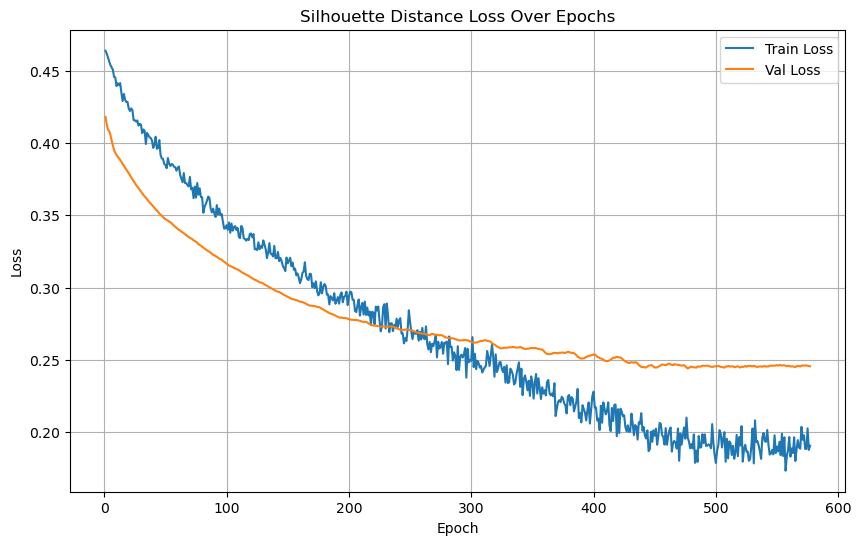

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/663], Loss: 0.2588


Test Batch [20/663], Loss: 0.2236
Test Batch [30/663], Loss: 0.2188


Test Batch [40/663], Loss: 0.5084
Test Batch [50/663], Loss: 0.2102


Test Batch [60/663], Loss: 0.2164
Test Batch [70/663], Loss: 0.1458


Test Batch [80/663], Loss: 0.2051
Test Batch [90/663], Loss: 0.1026


Test Batch [100/663], Loss: 0.1182
Test Batch [110/663], Loss: 0.1318
Test Batch [120/663], Loss: 0.1244


Test Batch [130/663], Loss: 0.1503


Test Batch [140/663], Loss: 0.2595
Test Batch [150/663], Loss: 0.1313
Test Batch [160/663], Loss: 0.1929
Test Batch [170/663], Loss: 0.2129
Test Batch [180/663], Loss: 0.5000


Test Batch [190/663], Loss: 0.5000
Test Batch [200/663], Loss: 0.0744


Test Batch [210/663], Loss: 0.5000
Test Batch [220/663], Loss: 0.5000
Test Batch [230/663], Loss: 0.0836
Test Batch [240/663], Loss: 0.5000
Test Batch [250/663], Loss: 0.5000
Test Batch [260/663], Loss: 0.5000
Test Batch [270/663], Loss: 0.5000
Test Batch [280/663], Loss: 0.5000


Test Batch [290/663], Loss: 0.5000
Test Batch [300/663], Loss: 0.2529


Test Batch [310/663], Loss: 0.1409
Test Batch [320/663], Loss: 0.2376
Test Batch [330/663], Loss: 0.1609


Test Batch [340/663], Loss: 0.1620


Test Batch [350/663], Loss: 0.1533
Test Batch [360/663], Loss: 0.1637


Test Batch [370/663], Loss: 0.1225


Test Batch [380/663], Loss: 0.1349
Test Batch [390/663], Loss: 0.1596


Test Batch [400/663], Loss: 0.0844


Test Batch [410/663], Loss: 0.1706
Test Batch [420/663], Loss: 0.1793


Test Batch [430/663], Loss: 0.2685


Test Batch [440/663], Loss: 0.3079
Test Batch [450/663], Loss: 0.3196
Test Batch [460/663], Loss: 0.2985


Test Batch [470/663], Loss: 0.2814
Test Batch [480/663], Loss: 0.2356
Test Batch [490/663], Loss: 0.1933
Test Batch [500/663], Loss: 0.1191


Test Batch [510/663], Loss: 0.1674
Test Batch [520/663], Loss: 0.2034
Test Batch [530/663], Loss: 0.2426


Test Batch [540/663], Loss: 0.3195
Test Batch [550/663], Loss: 0.2544
Test Batch [560/663], Loss: 0.2406


Test Batch [570/663], Loss: 0.2747
Test Batch [580/663], Loss: 0.1825
Test Batch [590/663], Loss: 0.2363
Test Batch [600/663], Loss: 0.3063


Test Batch [610/663], Loss: 0.2777
Test Batch [620/663], Loss: 0.1989
Test Batch [630/663], Loss: 0.2532
Test Batch [640/663], Loss: 0.3082


Test Batch [650/663], Loss: 0.3434
Test Batch [660/663], Loss: 0.4767

Test Loss: 0.2697


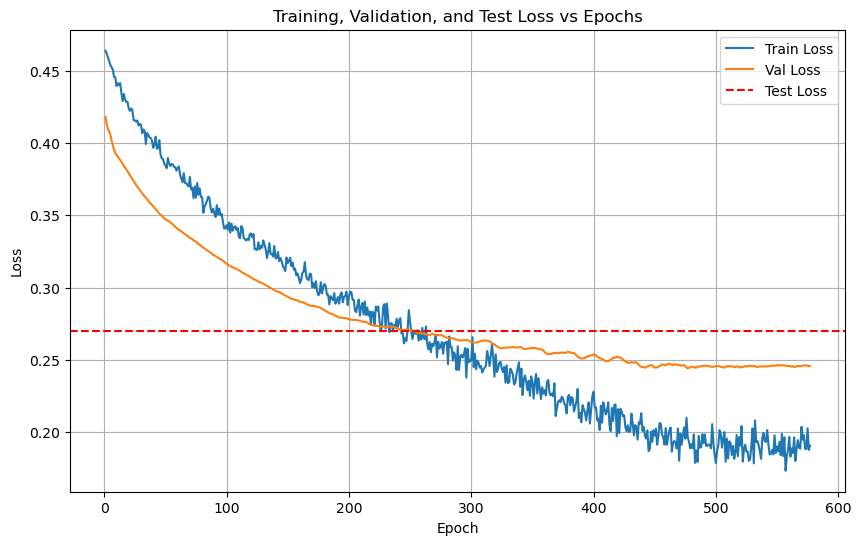

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/663 for test dataset.
  Processed batch 20/663 for test dataset.


  Processed batch 30/663 for test dataset.
  Processed batch 40/663 for test dataset.


  Processed batch 50/663 for test dataset.
  Processed batch 60/663 for test dataset.


  Processed batch 70/663 for test dataset.
  Processed batch 80/663 for test dataset.


  Processed batch 90/663 for test dataset.
  Processed batch 100/663 for test dataset.


  Processed batch 110/663 for test dataset.
  Processed batch 120/663 for test dataset.


  Processed batch 130/663 for test dataset.


  Processed batch 140/663 for test dataset.
  Processed batch 150/663 for test dataset.


  Processed batch 160/663 for test dataset.


  Processed batch 170/663 for test dataset.
  Processed batch 180/663 for test dataset.


  Processed batch 190/663 for test dataset.


  Processed batch 200/663 for test dataset.
  Processed batch 210/663 for test dataset.
  Processed batch 220/663 for test dataset.


  Processed batch 230/663 for test dataset.


  Processed batch 240/663 for test dataset.
  Processed batch 250/663 for test dataset.


  Processed batch 260/663 for test dataset.
  Processed batch 270/663 for test dataset.
  Processed batch 280/663 for test dataset.


  Processed batch 290/663 for test dataset.
  Processed batch 300/663 for test dataset.
  Processed batch 310/663 for test dataset.
  Processed batch 320/663 for test dataset.


  Processed batch 330/663 for test dataset.
  Processed batch 340/663 for test dataset.
  Processed batch 350/663 for test dataset.
  Processed batch 360/663 for test dataset.


  Processed batch 370/663 for test dataset.
  Processed batch 380/663 for test dataset.
  Processed batch 390/663 for test dataset.
  Processed batch 400/663 for test dataset.


  Processed batch 410/663 for test dataset.
  Processed batch 420/663 for test dataset.
  Processed batch 430/663 for test dataset.


  Processed batch 440/663 for test dataset.
  Processed batch 450/663 for test dataset.
  Processed batch 460/663 for test dataset.


  Processed batch 470/663 for test dataset.
  Processed batch 480/663 for test dataset.
  Processed batch 490/663 for test dataset.
  Processed batch 500/663 for test dataset.


  Processed batch 510/663 for test dataset.
  Processed batch 520/663 for test dataset.
  Processed batch 530/663 for test dataset.


  Processed batch 540/663 for test dataset.
  Processed batch 550/663 for test dataset.
  Processed batch 560/663 for test dataset.


  Processed batch 570/663 for test dataset.
  Processed batch 580/663 for test dataset.
  Processed batch 590/663 for test dataset.
  Processed batch 600/663 for test dataset.


  Processed batch 610/663 for test dataset.
  Processed batch 620/663 for test dataset.
  Processed batch 630/663 for test dataset.
  Processed batch 640/663 for test dataset.


  Processed batch 650/663 for test dataset.
  Processed batch 660/663 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.89        45
weighted avg       0.91      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 77.07%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3563  |  Val Loss: 2.2275
Validation loss improved from inf to 2.2275.
[Epoch 2/1000] Train Loss: 2.2138  |  Val Loss: 2.1099
Validation loss improved from 2.2275 to 2.1099.
[Epoch 3/1000] Train Loss: 2.1020  |  Val Loss: 2.0205
Validation loss improved from 2.1099 to 2.0205.
[Epoch 4/1000] Train Loss: 2.0033  |  Val Loss: 1.9378
Validation loss improved from 2.0205 to 1.9378.
[Epoch 5/1000] Train Loss: 1.9141  |  Val Loss: 1.8698
Validation loss improved from 1.9378 to 1.8698.
[Epoch 6/1000] Train Loss: 1.8455  |  Val Loss: 1.8136
Validation loss improved from 1.8698 to 1.8136.
[Epoch 7/1000] Train Loss: 1.7836  |  Val Loss: 1.7640
Validation loss improved from 1.8136 to 1.7640.
[Epoch 8/1000] Train Loss: 1.7317  |  Val Loss: 1.7186
Validation loss improved from 1.7640 to 1.7186.
[Epoch 9/1000] Train Loss: 1.6844  |  Val Loss: 1.6777
Validation loss improved from 1.7186 to 1.6777.
[Epoch 10/1000] Train Loss: 1.6393  |  Val Loss: 1.6411
Validation loss impr

[Epoch 14/1000] Train Loss: 1.4964  |  Val Loss: 1.5196
Validation loss improved from 1.5471 to 1.5196.
[Epoch 15/1000] Train Loss: 1.4667  |  Val Loss: 1.4941
Validation loss improved from 1.5196 to 1.4941.
[Epoch 16/1000] Train Loss: 1.4401  |  Val Loss: 1.4699
Validation loss improved from 1.4941 to 1.4699.
[Epoch 17/1000] Train Loss: 1.4134  |  Val Loss: 1.4476
Validation loss improved from 1.4699 to 1.4476.


[Epoch 18/1000] Train Loss: 1.3896  |  Val Loss: 1.4260
Validation loss improved from 1.4476 to 1.4260.
[Epoch 19/1000] Train Loss: 1.3662  |  Val Loss: 1.4052
Validation loss improved from 1.4260 to 1.4052.
[Epoch 20/1000] Train Loss: 1.3436  |  Val Loss: 1.3853
Validation loss improved from 1.4052 to 1.3853.
[Epoch 21/1000] Train Loss: 1.3218  |  Val Loss: 1.3657
Validation loss improved from 1.3853 to 1.3657.
[Epoch 22/1000] Train Loss: 1.3004  |  Val Loss: 1.3466
Validation loss improved from 1.3657 to 1.3466.
[Epoch 23/1000] Train Loss: 1.2788  |  Val Loss: 1.3280
Validation loss improved from 1.3466 to 1.3280.
[Epoch 24/1000] Train Loss: 1.2583  |  Val Loss: 1.3093
Validation loss improved from 1.3280 to 1.3093.
[Epoch 25/1000] Train Loss: 1.2377  |  Val Loss: 1.2908
Validation loss improved from 1.3093 to 1.2908.
[Epoch 26/1000] Train Loss: 1.2169  |  Val Loss: 1.2726
Validation loss improved from 1.2908 to 1.2726.
[Epoch 27/1000] Train Loss: 1.1966  |  Val Loss: 1.2543
Validati

[Epoch 31/1000] Train Loss: 1.1158  |  Val Loss: 1.1828
Validation loss improved from 1.2003 to 1.1828.
[Epoch 32/1000] Train Loss: 1.0964  |  Val Loss: 1.1652
Validation loss improved from 1.1828 to 1.1652.
[Epoch 33/1000] Train Loss: 1.0765  |  Val Loss: 1.1477
Validation loss improved from 1.1652 to 1.1477.
[Epoch 34/1000] Train Loss: 1.0568  |  Val Loss: 1.1300
Validation loss improved from 1.1477 to 1.1300.


[Epoch 35/1000] Train Loss: 1.0369  |  Val Loss: 1.1128
Validation loss improved from 1.1300 to 1.1128.
[Epoch 36/1000] Train Loss: 1.0167  |  Val Loss: 1.0953
Validation loss improved from 1.1128 to 1.0953.
[Epoch 37/1000] Train Loss: 0.9966  |  Val Loss: 1.0782
Validation loss improved from 1.0953 to 1.0782.
[Epoch 38/1000] Train Loss: 0.9769  |  Val Loss: 1.0610
Validation loss improved from 1.0782 to 1.0610.
[Epoch 39/1000] Train Loss: 0.9566  |  Val Loss: 1.0439
Validation loss improved from 1.0610 to 1.0439.
[Epoch 40/1000] Train Loss: 0.9368  |  Val Loss: 1.0269
Validation loss improved from 1.0439 to 1.0269.
[Epoch 41/1000] Train Loss: 0.9170  |  Val Loss: 1.0102
Validation loss improved from 1.0269 to 1.0102.
[Epoch 42/1000] Train Loss: 0.8967  |  Val Loss: 0.9935
Validation loss improved from 1.0102 to 0.9935.
[Epoch 43/1000] Train Loss: 0.8771  |  Val Loss: 0.9767
Validation loss improved from 0.9935 to 0.9767.
[Epoch 44/1000] Train Loss: 0.8572  |  Val Loss: 0.9604
Validati

[Epoch 48/1000] Train Loss: 0.7787  |  Val Loss: 0.8963
Validation loss improved from 0.9121 to 0.8963.
[Epoch 49/1000] Train Loss: 0.7586  |  Val Loss: 0.8810
Validation loss improved from 0.8963 to 0.8810.


[Epoch 50/1000] Train Loss: 0.7396  |  Val Loss: 0.8656
Validation loss improved from 0.8810 to 0.8656.
[Epoch 51/1000] Train Loss: 0.7209  |  Val Loss: 0.8509
Validation loss improved from 0.8656 to 0.8509.
[Epoch 52/1000] Train Loss: 0.7016  |  Val Loss: 0.8367
Validation loss improved from 0.8509 to 0.8367.
[Epoch 53/1000] Train Loss: 0.6832  |  Val Loss: 0.8225
Validation loss improved from 0.8367 to 0.8225.
[Epoch 54/1000] Train Loss: 0.6650  |  Val Loss: 0.8087
Validation loss improved from 0.8225 to 0.8087.
[Epoch 55/1000] Train Loss: 0.6473  |  Val Loss: 0.7954
Validation loss improved from 0.8087 to 0.7954.
[Epoch 56/1000] Train Loss: 0.6298  |  Val Loss: 0.7826
Validation loss improved from 0.7954 to 0.7826.
[Epoch 57/1000] Train Loss: 0.6125  |  Val Loss: 0.7699
Validation loss improved from 0.7826 to 0.7699.
[Epoch 58/1000] Train Loss: 0.5959  |  Val Loss: 0.7574
Validation loss improved from 0.7699 to 0.7574.
[Epoch 59/1000] Train Loss: 0.5796  |  Val Loss: 0.7456
Validati

[Epoch 64/1000] Train Loss: 0.5040  |  Val Loss: 0.6928
Validation loss improved from 0.7025 to 0.6928.
[Epoch 65/1000] Train Loss: 0.4904  |  Val Loss: 0.6835
Validation loss improved from 0.6928 to 0.6835.
[Epoch 66/1000] Train Loss: 0.4768  |  Val Loss: 0.6745
Validation loss improved from 0.6835 to 0.6745.


[Epoch 67/1000] Train Loss: 0.4641  |  Val Loss: 0.6657
Validation loss improved from 0.6745 to 0.6657.
[Epoch 68/1000] Train Loss: 0.4514  |  Val Loss: 0.6573
Validation loss improved from 0.6657 to 0.6573.
[Epoch 69/1000] Train Loss: 0.4396  |  Val Loss: 0.6498
Validation loss improved from 0.6573 to 0.6498.
[Epoch 70/1000] Train Loss: 0.4275  |  Val Loss: 0.6419
Validation loss improved from 0.6498 to 0.6419.
[Epoch 71/1000] Train Loss: 0.4162  |  Val Loss: 0.6345
Validation loss improved from 0.6419 to 0.6345.
[Epoch 72/1000] Train Loss: 0.4055  |  Val Loss: 0.6274
Validation loss improved from 0.6345 to 0.6274.
[Epoch 73/1000] Train Loss: 0.3949  |  Val Loss: 0.6206
Validation loss improved from 0.6274 to 0.6206.
[Epoch 74/1000] Train Loss: 0.3845  |  Val Loss: 0.6136
Validation loss improved from 0.6206 to 0.6136.
[Epoch 75/1000] Train Loss: 0.3749  |  Val Loss: 0.6071
Validation loss improved from 0.6136 to 0.6071.
[Epoch 76/1000] Train Loss: 0.3654  |  Val Loss: 0.6017
Validati

[Epoch 81/1000] Train Loss: 0.3235  |  Val Loss: 0.5767
Validation loss improved from 0.5811 to 0.5767.


[Epoch 82/1000] Train Loss: 0.3159  |  Val Loss: 0.5720
Validation loss improved from 0.5767 to 0.5720.
[Epoch 83/1000] Train Loss: 0.3086  |  Val Loss: 0.5680
Validation loss improved from 0.5720 to 0.5680.
[Epoch 84/1000] Train Loss: 0.3018  |  Val Loss: 0.5645
Validation loss improved from 0.5680 to 0.5645.
[Epoch 85/1000] Train Loss: 0.2948  |  Val Loss: 0.5602
Validation loss improved from 0.5645 to 0.5602.
[Epoch 86/1000] Train Loss: 0.2884  |  Val Loss: 0.5576
Validation loss improved from 0.5602 to 0.5576.
[Epoch 87/1000] Train Loss: 0.2821  |  Val Loss: 0.5540
Validation loss improved from 0.5576 to 0.5540.
[Epoch 88/1000] Train Loss: 0.2763  |  Val Loss: 0.5512
Validation loss improved from 0.5540 to 0.5512.
[Epoch 89/1000] Train Loss: 0.2703  |  Val Loss: 0.5479
Validation loss improved from 0.5512 to 0.5479.
[Epoch 90/1000] Train Loss: 0.2649  |  Val Loss: 0.5443
Validation loss improved from 0.5479 to 0.5443.
[Epoch 91/1000] Train Loss: 0.2592  |  Val Loss: 0.5417
Validati

[Epoch 98/1000] Train Loss: 0.2264  |  Val Loss: 0.5262
Validation loss improved from 0.5282 to 0.5262.
[Epoch 99/1000] Train Loss: 0.2221  |  Val Loss: 0.5235
Validation loss improved from 0.5262 to 0.5235.
[Epoch 100/1000] Train Loss: 0.2183  |  Val Loss: 0.5220
Validation loss improved from 0.5235 to 0.5220.
[Epoch 101/1000] Train Loss: 0.2142  |  Val Loss: 0.5195
Validation loss improved from 0.5220 to 0.5195.
[Epoch 102/1000] Train Loss: 0.2106  |  Val Loss: 0.5183
Validation loss improved from 0.5195 to 0.5183.
[Epoch 103/1000] Train Loss: 0.2069  |  Val Loss: 0.5170
Validation loss improved from 0.5183 to 0.5170.
[Epoch 104/1000] Train Loss: 0.2034  |  Val Loss: 0.5156
Validation loss improved from 0.5170 to 0.5156.
[Epoch 105/1000] Train Loss: 0.2001  |  Val Loss: 0.5140
Validation loss improved from 0.5156 to 0.5140.
[Epoch 106/1000] Train Loss: 0.1970  |  Val Loss: 0.5131
Validation loss improved from 0.5140 to 0.5131.
[Epoch 107/1000] Train Loss: 0.1938  |  Val Loss: 0.5105


[Epoch 116/1000] Train Loss: 0.1689  |  Val Loss: 0.5013
Validation loss improved from 0.5013 to 0.5013.
[Epoch 117/1000] Train Loss: 0.1665  |  Val Loss: 0.5007
Validation loss improved from 0.5013 to 0.5007.
[Epoch 118/1000] Train Loss: 0.1641  |  Val Loss: 0.4996
Validation loss improved from 0.5007 to 0.4996.
[Epoch 119/1000] Train Loss: 0.1619  |  Val Loss: 0.4986
Validation loss improved from 0.4996 to 0.4986.
[Epoch 120/1000] Train Loss: 0.1597  |  Val Loss: 0.4973
Validation loss improved from 0.4986 to 0.4973.
[Epoch 121/1000] Train Loss: 0.1576  |  Val Loss: 0.4958
Validation loss improved from 0.4973 to 0.4958.
[Epoch 122/1000] Train Loss: 0.1554  |  Val Loss: 0.4953
Validation loss improved from 0.4958 to 0.4953.
[Epoch 123/1000] Train Loss: 0.1534  |  Val Loss: 0.4941
Validation loss improved from 0.4953 to 0.4941.
[Epoch 124/1000] Train Loss: 0.1516  |  Val Loss: 0.4925
Validation loss improved from 0.4941 to 0.4925.
[Epoch 125/1000] Train Loss: 0.1495  |  Val Loss: 0.492

[Epoch 133/1000] Train Loss: 0.1362  |  Val Loss: 0.4884
Validation loss improved from 0.4890 to 0.4884.
[Epoch 134/1000] Train Loss: 0.1347  |  Val Loss: 0.4882
Validation loss improved from 0.4884 to 0.4882.
[Epoch 135/1000] Train Loss: 0.1334  |  Val Loss: 0.4873
Validation loss improved from 0.4882 to 0.4873.
[Epoch 136/1000] Train Loss: 0.1320  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 137/1000] Train Loss: 0.1306  |  Val Loss: 0.4874
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 138/1000] Train Loss: 0.1292  |  Val Loss: 0.4868
Validation loss improved from 0.4873 to 0.4868.
[Epoch 139/1000] Train Loss: 0.1279  |  Val Loss: 0.4866
Validation loss improved from 0.4868 to 0.4866.
[Epoch 140/1000] Train Loss: 0.1267  |  Val Loss: 0.4863
Validation loss improved from 0.4866 to 0.4863.
[Epoch 141/1000] Train Loss: 0.1254  |  Val Loss: 0.4864
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.1242  

[Epoch 148/1000] Train Loss: 0.1175  |  Val Loss: 0.4831
Validation loss improved from 0.4841 to 0.4831.
[Epoch 149/1000] Train Loss: 0.1165  |  Val Loss: 0.4838
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.1154  |  Val Loss: 0.4837
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 151/1000] Train Loss: 0.1145  |  Val Loss: 0.4833
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 152/1000] Train Loss: 0.1135  |  Val Loss: 0.4824
Validation loss improved from 0.4831 to 0.4824.
[Epoch 153/1000] Train Loss: 0.1125  |  Val Loss: 0.4827
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 0.1117  |  Val Loss: 0.4828
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 0.1107  |  Val Loss: 0.4832
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 156/1000] Train Loss: 0.1098  |  Val Loss: 0.4832
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 157/10

[Epoch 164/1000] Train Loss: 0.1034  |  Val Loss: 0.4820
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 165/1000] Train Loss: 0.1027  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 166/1000] Train Loss: 0.1019  |  Val Loss: 0.4811
Validation loss improved from 0.4815 to 0.4811.
[Epoch 167/1000] Train Loss: 0.1012  |  Val Loss: 0.4816
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 0.1005  |  Val Loss: 0.4827
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 169/1000] Train Loss: 0.0998  |  Val Loss: 0.4831
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 170/1000] Train Loss: 0.0992  |  Val Loss: 0.4828
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 171/1000] Train Loss: 0.0985  |  Val Loss: 0.4831
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 172/1000] Train Loss: 0.0978  |  Val Loss: 0.4831
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 180/1000] Train Loss: 0.0931  |  Val Loss: 0.4837
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 181/1000] Train Loss: 0.0926  |  Val Loss: 0.4839
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 182/1000] Train Loss: 0.0920  |  Val Loss: 0.4848
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 183/1000] Train Loss: 0.0915  |  Val Loss: 0.4848
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 184/1000] Train Loss: 0.0910  |  Val Loss: 0.4850
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 185/1000] Train Loss: 0.0905  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 186/1000] Train Loss: 0.0901  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 187/1000] Train Loss: 0.0895  |  Val Loss: 0.4847
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 188/1000] Train Loss: 0.0891  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.0850  |  Val Loss: 0.4884
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 198/1000] Train Loss: 0.0846  |  Val Loss: 0.4885
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 199/1000] Train Loss: 0.0842  |  Val Loss: 0.4882
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 200/1000] Train Loss: 0.0838  |  Val Loss: 0.4882
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 201/1000] Train Loss: 0.0834  |  Val Loss: 0.4881
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 202/1000] Train Loss: 0.0831  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 203/1000] Train Loss: 0.0827  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 204/1000] Train Loss: 0.0823  |  Val Loss: 0.4902
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 205/1000] Train Loss: 0.0820  |  Val Loss: 0.4902
!! Validation loss did NOT improve !! Patience:

[Epoch 213/1000] Train Loss: 0.0793  |  Val Loss: 0.4916
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 214/1000] Train Loss: 0.0791  |  Val Loss: 0.4923
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 215/1000] Train Loss: 0.0787  |  Val Loss: 0.4932
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 216/1000] Train Loss: 0.0784  |  Val Loss: 0.4933
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 217/1000] Train Loss: 0.0782  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 218/1000] Train Loss: 0.0778  |  Val Loss: 0.4941
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 219/1000] Train Loss: 0.0775  |  Val Loss: 0.4935
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 220/1000] Train Loss: 0.0772  |  Val Loss: 0.4939
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 221/1000] Train Loss: 0.0770  |  Val Loss: 0.4950
!! Validation loss did NOT improve !! Patience:

[Epoch 229/1000] Train Loss: 0.0749  |  Val Loss: 0.4963
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 230/1000] Train Loss: 0.0746  |  Val Loss: 0.4968
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 231/1000] Train Loss: 0.0743  |  Val Loss: 0.4972
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 232/1000] Train Loss: 0.0742  |  Val Loss: 0.4977
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 233/1000] Train Loss: 0.0740  |  Val Loss: 0.4986
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 234/1000] Train Loss: 0.0737  |  Val Loss: 0.4992
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 235/1000] Train Loss: 0.0734  |  Val Loss: 0.4994
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 236/1000] Train Loss: 0.0733  |  Val Loss: 0.4985
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 237/1000] Train Loss: 0.0730  |  Val Loss: 0.4987
!! Validation loss did NOT improve !! Patience:

[Epoch 245/1000] Train Loss: 0.0712  |  Val Loss: 0.5034
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 246/1000] Train Loss: 0.0710  |  Val Loss: 0.5039
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 247/1000] Train Loss: 0.0708  |  Val Loss: 0.5042
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 248/1000] Train Loss: 0.0706  |  Val Loss: 0.5048
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 249/1000] Train Loss: 0.0705  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 250/1000] Train Loss: 0.0702  |  Val Loss: 0.5050
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 251/1000] Train Loss: 0.0701  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 252/1000] Train Loss: 0.0698  |  Val Loss: 0.5063
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 253/1000] Train Loss: 0.0697  |  Val Loss: 0.5062
!! Validation loss did NOT improve !! Patience:

[Epoch 262/1000] Train Loss: 0.0680  |  Val Loss: 0.5111
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 263/1000] Train Loss: 0.0678  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 264/1000] Train Loss: 0.0677  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 265/1000] Train Loss: 0.0675  |  Val Loss: 0.5118
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 266/1000] Train Loss: 0.0674  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 266 !!
No improvement for 100 epochs.


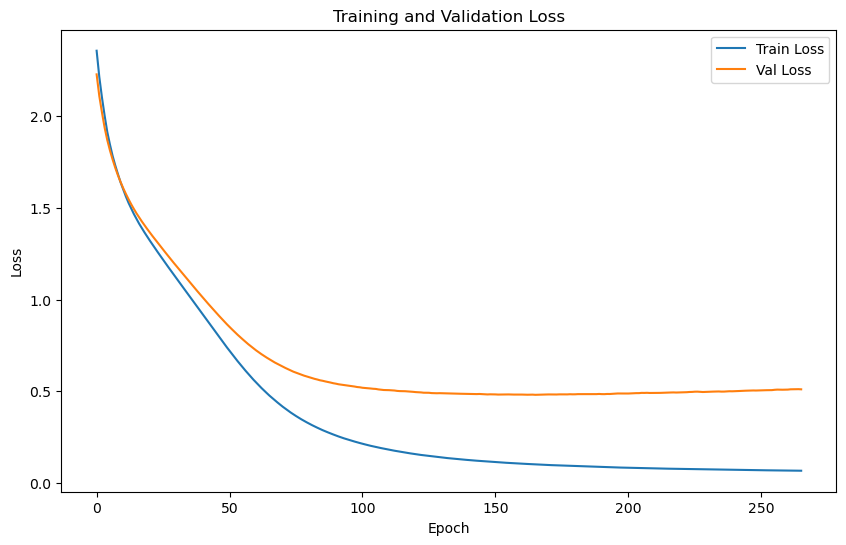

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8902 | Test Accuracy: 78.08%


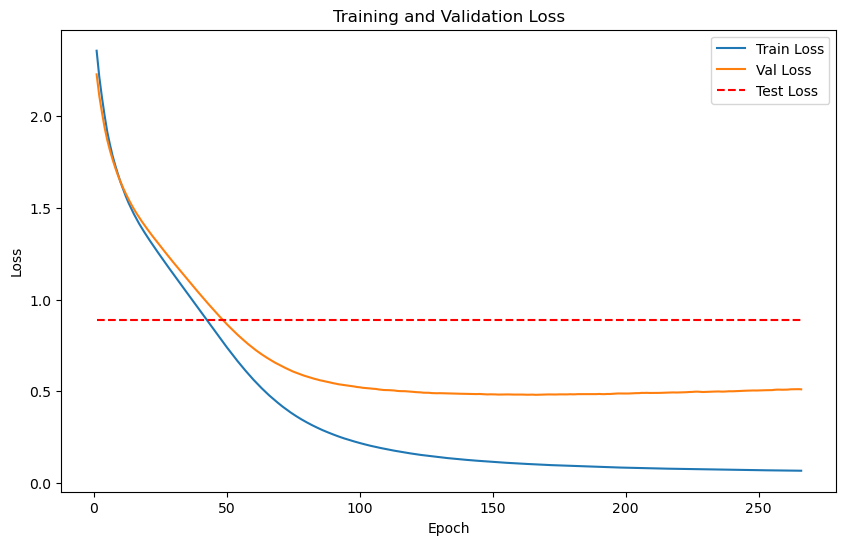

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


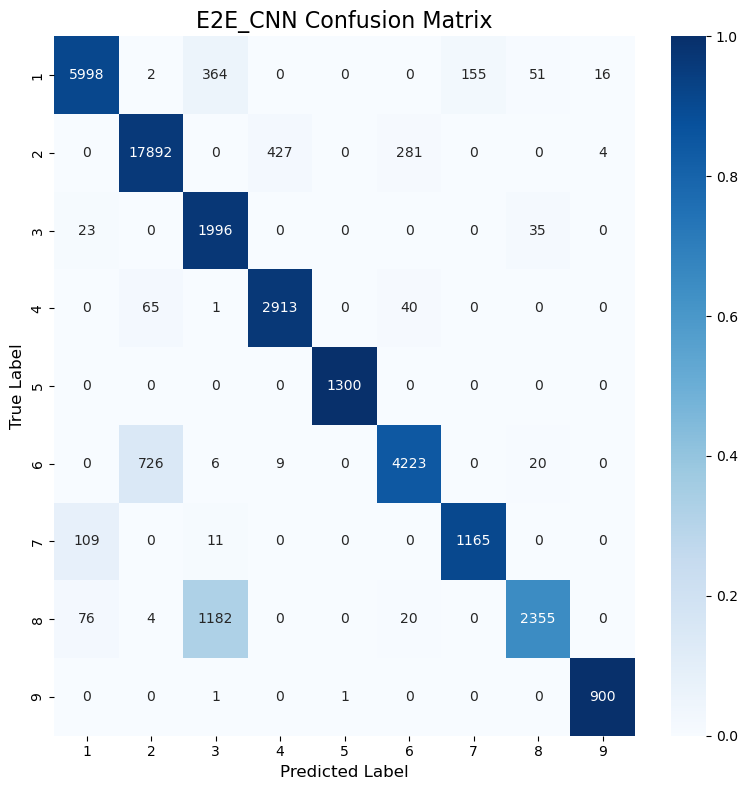

Classification Accuracy: 91.44%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


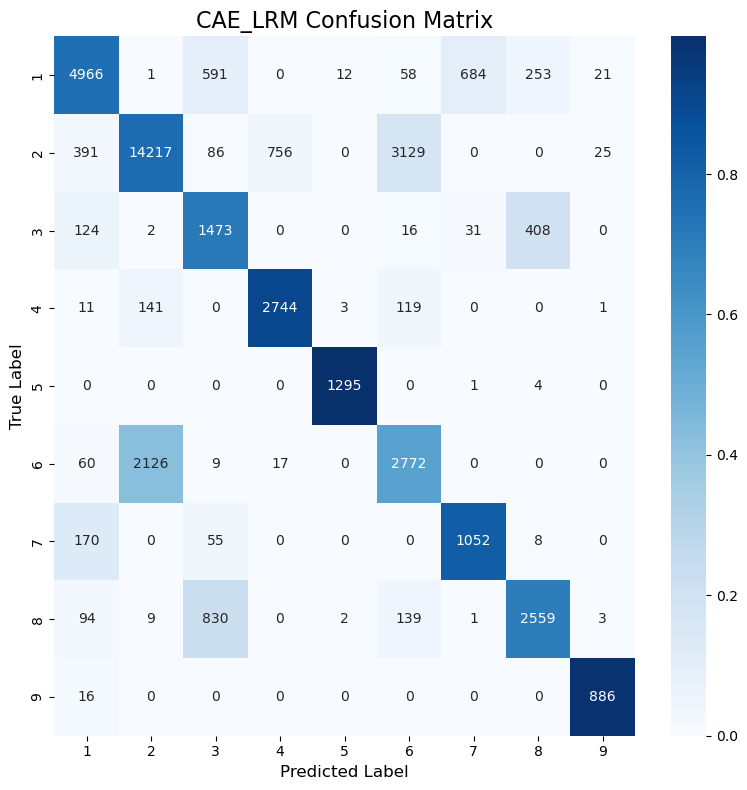

Classification Accuracy: 75.44%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


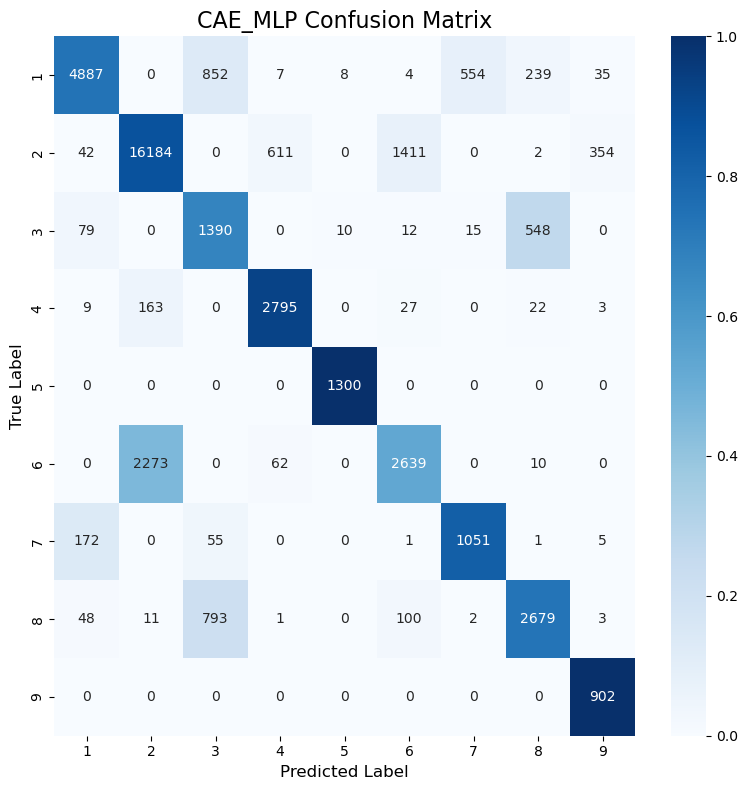

Classification Accuracy: 79.84%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


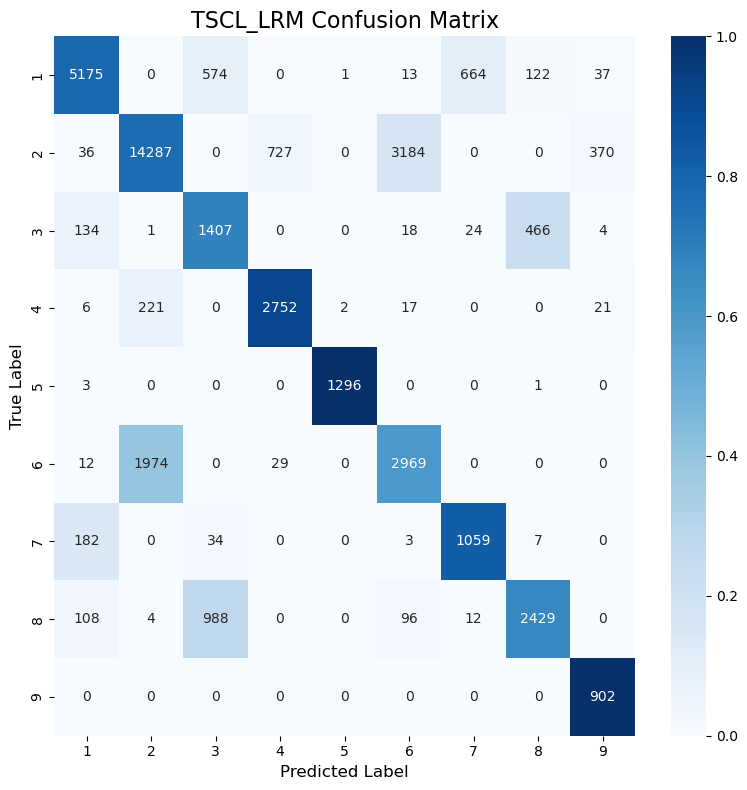

Classification Accuracy: 76.17%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


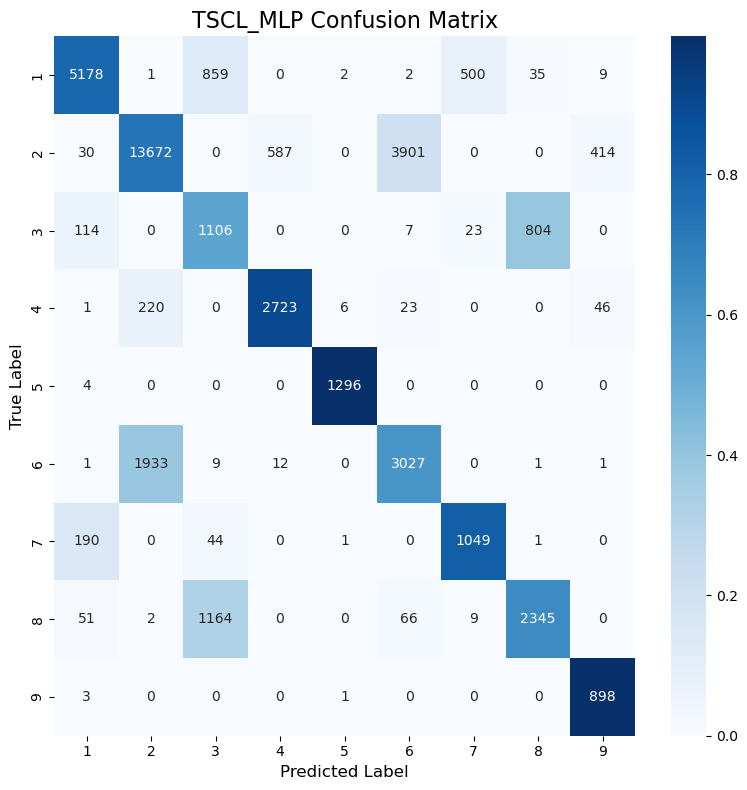

Classification Accuracy: 73.86%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


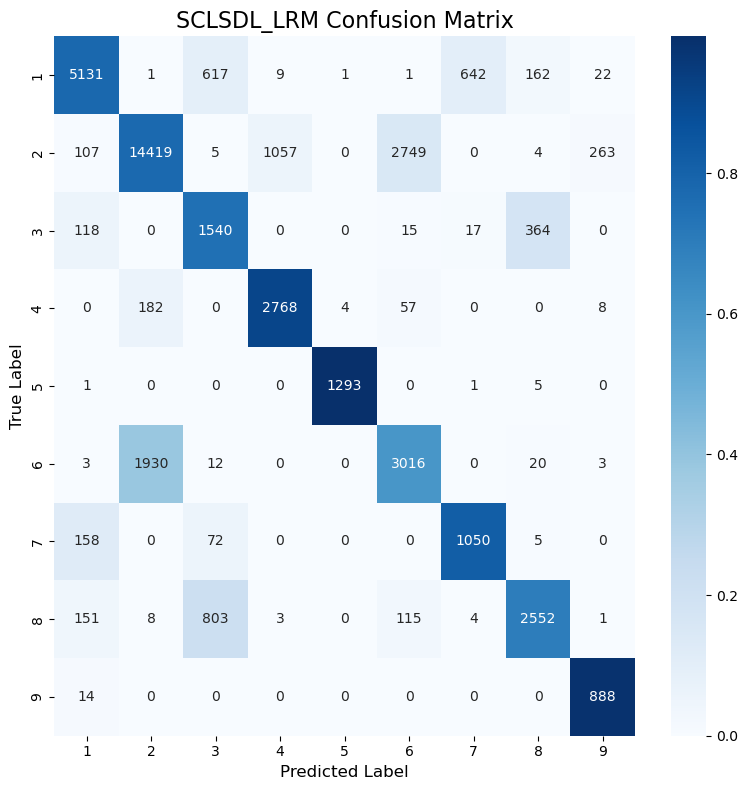

Classification Accuracy: 77.07%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


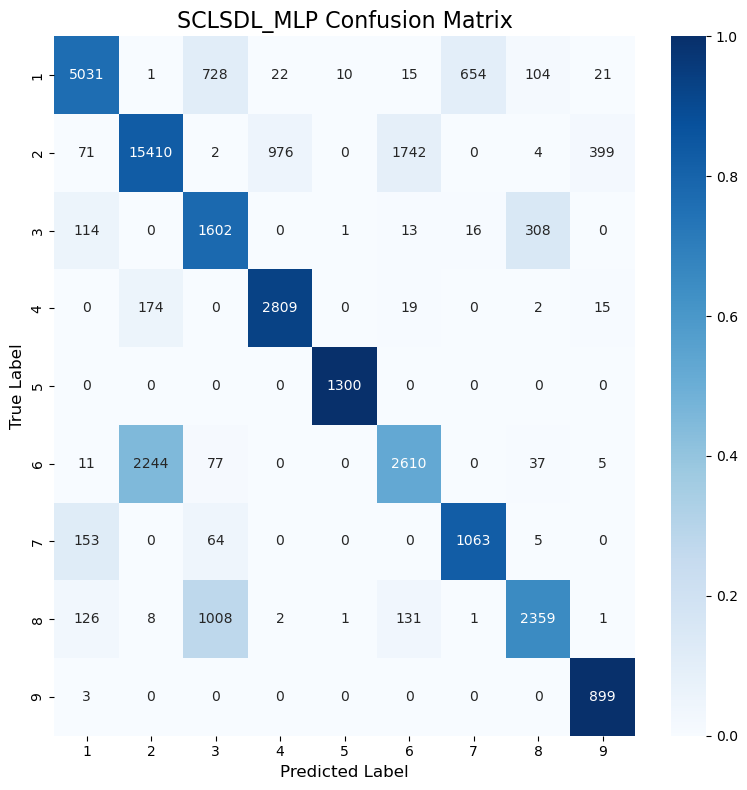

Classification Accuracy: 78.08%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          91.44
1    LRM (CAE)          75.44
2    MLP (CAE)          79.84
3     TSCL LRM          76.17
4     TSCL MLP          73.86
5  SCL_SDL LRM          77.07
6  SCL_SDL MLP          78.08

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          91.44
2    MLP (CAE)          79.84
6  SCL_SDL MLP          78.08
5  SCL_SDL LRM          77.07
3     TSCL LRM          76.17
1    LRM (CAE)          75.44
4     TSCL MLP          73.86
